## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import requests
import math
from bs4 import BeautifulSoup as bs
import googlemaps
import plotly.graph_objects as go
import plotly.express as px
import streamlit as st
import json
import folium
from folium.features import DivIcon
import geojson

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], 'creds.py'))
import creds

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns= 100

In [3]:
df_sake = pd.read_csv('../data/sake_list.csv', index_col='id')#.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [4]:
df_sake.head()

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories
id,,,,,,,,,,,,,,,,,,,,
5,久保田 萬寿,くぼた まんじゅ,Kubota Manju,純米大吟醸酒,五百万石,新潟県,協会9号(熊本酵母・香露酵母),35,15.0,1.20,-,2.0,1800ml/720ml,新潟県,長岡市,朝日酒造株式会社,〒949-5494新潟県長岡市朝日880-1,http://www.asahi-shuzo.co.jp,久保田(くぼた),協会系酵母>協会9号(熊本酵母・香露酵母) / 特定名称酒>純米系>純米大吟醸酒 / 酒造好...
6,酔鯨 純米吟醸 吟麗,すいげい じゅんまいぎんじょう ぎんれい,Suigei Junmaiginjou Ginrei,純米吟醸酒,松山三井 / 中生新千本,愛媛県 / 広島県,熊本1号(KA-1),50,16.0,1.70,1.15,6.5,1800ml/720ml/300ml,高知県,高知市,酔鯨酒造株式会社,〒781-0270高知県高知市長浜566-1,http://www.suigei.jp,酔鯨(すいげい),自治体系酵母>熊本1号(KA-1) / 特定名称酒>純米系>純米吟醸酒 / 酒造適正米・一般...
7,酔鯨 純米大吟醸 山田錦50％,すいげい じゅんまいだいぎんじょう やまだにしき50％,Suigei Junmaidaiginjou Yamadanishiki50％,純米大吟醸酒,山田錦,兵庫県,熊本1号(KA-1),50,16.0~17.0,1.70,1.20,6.0,1800ml/720ml,高知県,高知市,酔鯨酒造株式会社,〒781-0270高知県高知市長浜566-1,http://www.suigei.jp,酔鯨(すいげい),自治体系酵母>熊本1号(KA-1) / 特定名称酒>純米系>純米大吟醸酒 / 酒造好適米(醸...
8,酔鯨 純米大吟醸 吟の冴,すいげい じゅんまいだいぎんじょう ぎんのさえ,Suigei Junmaidaiginjou Ginnosae,純米大吟醸酒,山田錦,兵庫県,熊本1号(KA-1),40,16.0,1.50,1.10,6.5,1800ml/720ml,高知県,高知市,酔鯨酒造株式会社,〒781-0270高知県高知市長浜566-1,http://www.suigei.jp,酔鯨(すいげい),自治体系酵母>熊本1号(KA-1) / 特定名称酒>純米系>純米大吟醸酒 / 酒造好適米(醸...
9,酔鯨 純米大吟醸 旭友,すいげい じゅんまいだいぎんじょう きょくゆう,Suigei Junmaidaiginjou Kyokuyuu,純米大吟醸酒,八反錦,広島県,熊本1号(KA-1),40,16.0,1.60,1.10,6.5,1800ml/720ml,高知県,高知市,酔鯨酒造株式会社,〒781-0270高知県高知市長浜566-1,http://www.suigei.jp,酔鯨(すいげい),自治体系酵母>熊本1号(KA-1) / 特定名称酒>純米系>純米大吟醸酒 / 酒造好適米(醸...


In [ ]:
df_sake.loc[14841]

## stakeholders and project value

stakeholders
- me - my own interest
- foreigners - want to learn more about sake in English
- sake sommeliers / experts - want to explore sake data
- sake brewers - want to know where sake is being brewed

what I'm interested in learning from the data
- which prefectures have many breweries / sake?
- where is a higher rate of high / low quality sake produced?  
- are there defining features of sake for different prefectures (eg sake type, abv, acidity, etc)?  If so, what are they?  What features aren't unique?
- what climate and geographic factors play in brewery / sake production density?

## data cleaning

In [5]:
def clean_df(df_sake):
    # replace "-" with NAs
    df_sake = df_sake.replace("-", np.nan)

    # clean yeast strings
    df_sake['yeast'] = df_sake.yeast.replace(to_replace="[  *\n\r]", value="", regex=True)

    # change rice polishing rate from string to float
    df_sake['rice_polishing_rate'] = df_sake.rice_polishing_rate.astype('float')

    # clean and create high, low, and avg columns for abv, acidity, amino, and gravity, all as floats
    df_sake['abv_low'] = df_sake.abv.str.split("~").str[0].astype('float')
    df_sake['abv_high'] = df_sake.abv.str.split("~").str[-1].astype('float')
    df_sake['abv_avg'] = df_sake[['abv_low', 'abv_high']].mean(axis=1)

    df_sake['acidity'] = df_sake.acidity.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['acidity_low'] = df_sake.acidity.str.split("~").str[0].astype('float')
    df_sake['acidity_high'] = df_sake.acidity.str.split("~").str[-1].astype('float')
    df_sake['acidity_avg'] = df_sake[['acidity_low', 'acidity_high']].mean(axis=1)

    df_sake['amino'] = df_sake.amino.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['amino_low'] = df_sake.amino.str.split("~").str[0].astype('float')
    df_sake['amino_high'] = df_sake.amino.str.split("~").str[-1].astype('float')
    df_sake['amino_avg'] = df_sake[['amino_low', 'amino_high']].mean(axis=1)

    df_sake['gravity'] = df_sake.gravity.replace(to_replace="[  *\n\r]", value="", regex=True)
    df_sake['gravity_low'] = df_sake.gravity.str.split("~").str[0].astype('float')
    df_sake['gravity_high'] = df_sake.gravity.str.split("~").str[-1].astype('float')
    df_sake['gravity_avg'] = df_sake[['gravity_low', 'gravity_high']].mean(axis=1)
    
    return df_sake

In [6]:
df_sake = clean_df(df_sake)
df_sake.tail(3)

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories,abv_low,abv_high,abv_avg,acidity_low,acidity_high,acidity_avg,amino_low,amino_high,amino_avg,gravity_low,gravity_high,gravity_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14841,純米大吟醸 蔵,じゅんまいだいぎんじょう くら,Junmaidaiginjou Kura,純米大吟醸酒,美山錦,長野県,NaN,49.0,16.0,1.00~1.30,NaN,0.0~3.0,1800ml/720ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,蔵(くら),特定名称酒>純米系>純米大吟醸酒 / 酒造好適米(醸造用玄米)>美山錦,16.0,16.0,16.0,1.0,1.3,1.15,NaN,NaN,NaN,0.0,3.0,1.5
14842,純米大吟醸 銀の蔵,じゅんまいだいぎんじょう ぎんのくら,Junmaidaiginjou GinnoKura,純米大吟醸酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,蔵(くら),特定名称酒>純米系>純米大吟醸酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14843,菊秀 純米酒,きくひで じゅんまいしゅ,Kikuhide Junmaishu,純米酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,菊秀(きくひで),特定名称酒>純米系>純米酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## missingness

### missing company and location

In [7]:
df_sake[df_sake['company'].isna()]

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories,abv_low,abv_high,abv_avg,acidity_low,acidity_high,acidity_avg,amino_low,amino_high,amino_avg,gravity_low,gravity_high,gravity_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
386,大吟醸 生酒 吟のかほり,だいぎんじょう なまざけ ぎんのかほり,Daiginjou Namazake GinnoKaori,大吟醸酒,山田錦,兵庫県,NaN,40.0,15.0,1.30,NaN,5.0,300ml,NaN,NaN,NaN,NaN,NaN,NaN,特定名称酒>本醸造系>大吟醸酒 / 期間/数量限定 / 特殊工程・部位>酒槽しぼり / 特殊...,15.0,15.0,15.0,1.3,1.3,1.30,NaN,NaN,NaN,5.0,5.0,5.0
588,純天山,じゅんてんざん,Juntenzan,特別純米酒,山田錦 / レイホウ / さがの華 / 西海134号,兵庫県 / 佐賀県農業試験研究センター / 九州農業試験場,NaN,60.0,15.0,1.50~1.80,1.70,2.0~3.0,1800ml/720ml/300ml,NaN,NaN,NaN,NaN,NaN,NaN,特定名称酒>純米系>特別純米酒 / 酒造好適米(醸造用玄米)>山田錦 / 酒造適正米・一般米...,15.0,15.0,15.0,1.5,1.8,1.65,1.7,1.7,1.7,2.0,3.0,2.5
7843,純米 白銀蔵王,じゅんまい はくぎんざおう,Junmai Hakuginzaou,純米酒,美山錦,長野県,NaN,70.0,15.3,1.50,NaN,3.0,1800ml,NaN,NaN,NaN,NaN,NaN,NaN,特定名称酒>純米系>純米酒 / 酒造好適米(醸造用玄米)>美山錦,15.3,15.3,15.3,1.5,1.5,1.50,NaN,NaN,NaN,3.0,3.0,3.0
9545,特別本醸造 生貯蔵酒 副将軍,とくべつほんじょうぞう なまちょぞうしゅ ふくしょうぐん,Tokubetsuhonjouzou Namachozoushu Fukushougun,特別本醸造酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720ml,NaN,NaN,NaN,NaN,NaN,NaN,特定名称酒>本醸造系>特別本醸造酒 / 特殊貯蔵>生貯蔵酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10007,燦爛 ひやおろし,さんらん ひやおろし,Sanran Hiyaoroshi,普通酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720ml,NaN,NaN,NaN,NaN,NaN,NaN,普通酒 / 期間/数量限定>ひやおろし・秋あがり / 特殊貯蔵>生詰め酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# {sake name: company}
missing_brewery_dict = {
    '大吟醸 生酒 吟のかほり': '梅ヶ枝酒造株式会社',
    '純天山': '天山酒造株式会社',
    '純米 白銀蔵王': '嵐山酒造株式会社',
    '燦爛 ひやおろし': '株式会社外池酒造店',
    '特別本醸造 生貯蔵酒 副将軍': '明利酒類株式会社'
}

In [9]:
def impute_brewery_info(df_sake, dict_missing_brewery):
    for sake, company in dict_missing_brewery.items():
        brewery_info = df_sake[df_sake['company'] == company].iloc[0, 13:18]
        row_index = df_sake[df_sake['name'] == sake].index
        df_sake.loc[row_index, ['prefecture', 'city', 'company', 'address', 'website']] = brewery_info.values
    return df_sake

In [10]:
df_sake = impute_brewery_info(df_sake, missing_brewery_dict)

In [11]:
df_sake[df_sake['name'] == '燦爛 ひやおろし']

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories,abv_low,abv_high,abv_avg,acidity_low,acidity_high,acidity_avg,amino_low,amino_high,amino_avg,gravity_low,gravity_high,gravity_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10007,燦爛 ひやおろし,さんらん ひやおろし,Sanran Hiyaoroshi,普通酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720ml,栃木県,芳賀郡,株式会社外池酒造店,〒321-4216栃木県芳賀郡益子町塙333-1,http://tonoike.jp/,NaN,普通酒 / 期間/数量限定>ひやおろし・秋あがり / 特殊貯蔵>生詰め酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### mislabeled company / location values

In [12]:
df_sake.groupby("company").name.count().head()

company
http://59jo.com/                      5
http://www.koyumitsuru.jp/            3
https://r.goope.jp/nakagaki-syuzo     7
あい娘酒造合資会社                            10
かち鶴酒造株式会社                             9
Name: name, dtype: int64

In [13]:
df_sake[df_sake['company'] == 'http://www.koyumitsuru.jp/'].loc[:, ['prefecture', 'city', 'company', 'address', 'website']]

,prefecture,city,company,address,website
id,,,,,
13418,愛知県,小弓鶴酒造株式会社,http://www.koyumitsuru.jp/,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/
13419,愛知県,小弓鶴酒造株式会社,http://www.koyumitsuru.jp/,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/
13420,愛知県,小弓鶴酒造株式会社,http://www.koyumitsuru.jp/,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/


In [14]:
# a few companies have their website in the company column and company in the city column, so these are dictionaries I can use to fix that

company_dict = {
    'https://r.goope.jp/nakagaki-syuzo': '中垣酒造株式会社', # change city to 豊田市 (currently company name)
    'http://59jo.com/': '信州59年醸造会',  # group of 5 brewers from different breweries in Nagano - change city to NA, address is ... Nagano's lat lon?
    'http://www.koyumitsuru.jp/': '小弓鶴酒造株式会社',  # change city to 犬山市 (currently company name)
}

city_dict = {
    '中垣酒造株式会社': '豊田市',
    '小弓鶴酒造株式会社': '犬山市',
    '59醸': np.nan,
}

In [15]:
df_sake = df_sake.replace({'company': company_dict, 'city': city_dict})

In [16]:
df_sake[df_sake['company'] == '小弓鶴酒造株式会社']

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories,abv_low,abv_high,abv_avg,acidity_low,acidity_high,acidity_avg,amino_low,amino_high,amino_avg,gravity_low,gravity_high,gravity_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13418,山廃原酒,やまはいげんしゅ,YamahaiGenshu,本醸造酒,NaN,NaN,NaN,70.0,19.0~20.0,NaN,NaN,NaN,720ml,愛知県,犬山市,小弓鶴酒造株式会社,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/,小弓鶴(こゆみつる),生酛系酒母>山廃酛 / 特定名称酒>本醸造系>本醸造酒 / 原酒,19.0,20.0,19.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13419,小弓鶴上撰,こゆみつるじょうせん,KoyumitsuruJousen,本醸造酒,NaN,NaN,NaN,70.0,15.0~16.0,NaN,NaN,NaN,1800ml/720ml,愛知県,犬山市,小弓鶴酒造株式会社,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/,小弓鶴(こゆみつる),生酛系酒母>山廃酛 / 特定名称酒>本醸造系>本醸造酒,15.0,16.0,15.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13420,琥珀酔,こはくすい,Kohakusui,純米酒,山田錦,兵庫県,NaN,70.0,15.0,NaN,NaN,NaN,300ml,愛知県,犬山市,小弓鶴酒造株式会社,〒484-0894愛知県犬山市大字羽黒字成海郷70,http://www.koyumitsuru.jp/,小弓鶴(こゆみつる),特定名称酒>純米系>純米酒 / 酒造好適米(醸造用玄米)>山田錦 / 特殊貯蔵>古酒,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### TODO: missing sake types 
(not a priority - maybe can't infer sake type, and more important are sake type columns - nigori, genshu, nama, shiboritate, etc., which I do below)

In [ ]:
df_sake.isna().sum()

In [ ]:
df_sake[df_sake.sake_type.isna()]

In [ ]:
df_sake[df_sake.company == "越後・謙信SAKEまつり"]

In [ ]:
"特殊工程・部位" in df_sake.categories

In [ ]:
wikidf_pref = get_wikidf_pref()
wikidf_pref.columns

In [ ]:
wikidf_pref.Region.unique()

## adding columns

### prefecture, region, and sake type columns in English

In [17]:
def get_wikidf_pref():
    # get table from wikipedia
    wikiurl="https://en.wikipedia.org/wiki/Prefectures_of_Japan"
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    soup = bs(response.text, 'html.parser')
    table=soup.find('table',{'class':"wikitable"})

    # convert table to df
    df_pref=pd.read_html(str(table))
    
    return pd.DataFrame(df_pref[0])

In [18]:
def get_wikidf_sake_types():
    # get table from wikipedia
    wikiurl="https://en.wikipedia.org/wiki/Sake"
    table_class="wikitable sortable jquery-tablesorter"
    response=requests.get(wikiurl)
    soup = bs(response.text, 'html.parser')
    table=soup.find('table',{'class':"wikitable"})
    
    # convert table to df
    df=pd.read_html(str(table))
    
    return pd.DataFrame(df[0])

In [19]:
def add_columns(df_sake):
    # get prefecture and sake type dfs
    df_pref = get_wikidf_pref()
    df_sake_types = get_wikidf_sake_types()
    
    # create mapping dictionaries for English names for prefectures, regions, and sake types
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)
    sake_type_dict = {val[1]: val[0].strip() for val in df_sake_types['Special Designation'].str.replace('(', ',', regex=False).str.split(',').str[:2]}
    
    # add missing sake types to dict
    sake_type_dict['普通酒'] = 'Futsū-shu'
    sake_type_dict['貴醸酒'] = 'Kijō-shu'
    sake_type_dict['純米系'] = 'Junmai-kei'
    sake_type_dict['本醸造系'] = 'Honjōzō-kei'
    
    # add prefecture, region, and sake type columns to df
    df_sake['prefecture_eng'] = df_sake.prefecture.map(pref_mapping)
    df_sake['region'] = df_sake.prefecture.map(region_mapping)
    df_sake['sake_type_eng'] = df_sake.sake_type.map(sake_type_dict)

    return df_sake

In [20]:
df_sake = add_columns(df_sake)
df_sake.tail(3)

,name,name_kana,name_romaji,sake_type,rice_type,rice_origin,yeast,rice_polishing_rate,abv,acidity,amino,gravity,volume,prefecture,city,company,address,website,brand,categories,abv_low,abv_high,abv_avg,acidity_low,acidity_high,acidity_avg,amino_low,amino_high,amino_avg,gravity_low,gravity_high,gravity_avg,prefecture_eng,region,sake_type_eng
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14841,純米大吟醸 蔵,じゅんまいだいぎんじょう くら,Junmaidaiginjou Kura,純米大吟醸酒,美山錦,長野県,NaN,49.0,16.0,1.00~1.30,NaN,0.0~3.0,1800ml/720ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,蔵(くら),特定名称酒>純米系>純米大吟醸酒 / 酒造好適米(醸造用玄米)>美山錦,16.0,16.0,16.0,1.0,1.3,1.15,NaN,NaN,NaN,0.0,3.0,1.5,Nagano,Chūbu,Junmai Daiginjō-shu
14842,純米大吟醸 銀の蔵,じゅんまいだいぎんじょう ぎんのくら,Junmaidaiginjou GinnoKura,純米大吟醸酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,蔵(くら),特定名称酒>純米系>純米大吟醸酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nagano,Chūbu,Junmai Daiginjō-shu
14843,菊秀 純米酒,きくひで じゅんまいしゅ,Kikuhide Junmaishu,純米酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800ml,長野県,佐久市,橘倉酒造株式会社,〒384-0301長野県佐久市臼田653-2,http://kitsukura.co.jp/,菊秀(きくひで),特定名称酒>純米系>純米酒,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nagano,Chūbu,Junmai-shu


### more sake type columns

In [ ]:
# use this to get dataframe of all namazake
# df_sake[(df_sake['categories'] != np.nan) & (df_sake['categories'].str.contains('特殊貯蔵>生'))]

In [21]:
def label_nama(val):
    if isinstance(val, float) or '特殊貯蔵>生' not in val:
        return 0
    return 1

df_sake['is_nama'] = df_sake.categories.apply(lambda x: label_nama(x))

In [22]:
def label_genshu(val):
    if isinstance(val, float) or '原酒' not in val:
        return 0
    return 1

df_sake['is_genshu'] = df_sake.categories.apply(lambda x: label_genshu(x))

In [23]:
def label_kijoshu(val):
    if isinstance(val, float) or '貴醸酒' not in val:
        return 0
    return 1

df_sake['is_kijoshu'] = df_sake.categories.apply(lambda x: label_kijoshu(x))

In [24]:
def label_futsushu(val):
    if isinstance(val, float) or '普通酒' not in val:
        return 0
    return 1

df_sake['is_futsu'] = df_sake.categories.apply(lambda x: label_futsushu(x))

In [25]:
def label_special_designation(val):
    if isinstance(val, float) or '普通酒' in val or '貴醸酒' in val:
        return 0
    return 1

df_sake['is_special_designation'] = df_sake.sake_type.apply(lambda x: label_special_designation(x))

In [26]:
def label_junmai(val):
    if isinstance(val, float):
        return 0
    elif '純米' in val:
        return 1
    return 0

df_sake['is_junmai'] = df_sake.sake_type.apply(lambda x: label_junmai(x))

In [27]:
def label_non_junmai(val):
    if isinstance(val, float):
        return 0
    elif '本醸造' in val or '吟醸' in val and '純米' not in val:
        return 1
    return 0

df_sake['is_non_junmai'] = df_sake.sake_type.apply(lambda x: label_non_junmai(x))

In [28]:
def label_dai(val):
    if isinstance(val, float) or '大' not in val:
        return 0
    return 1

df_sake['is_dai'] = df_sake.sake_type.apply(lambda x: label_dai(x))

In [29]:
def label_nigori(val):
    if isinstance(val, float) or 'にごり' not in val:
        return 0
    return 1

df_sake['is_nigori'] = df_sake.categories.apply(lambda x: label_nigori(x))

In [30]:
def label_koshu(val):
    if isinstance(val, float) or '古酒' not in val:
        return 0
    return 1

df_sake['is_koshu'] = df_sake.categories.apply(lambda x: label_koshu(x))

In [31]:
def label_muroka(val):
    if isinstance(val, float) or '無濾過' not in val:
        return 0
    return 1

df_sake['is_muroka'] = df_sake.categories.apply(lambda x: label_muroka(x))

In [32]:
def label_sakabune(val):
    if isinstance(val, float) or '酒槽しぼり' not in val:
        return 0
    return 1

df_sake['is_sakabune'] = df_sake.categories.apply(lambda x: label_sakabune(x))

In [33]:
def label_shiboritate(val):
    if isinstance(val, float) or 'しぼりたて' not in val:
        return 0
    return 1

df_sake['is_shiboritate'] = df_sake.categories.apply(lambda x: label_shiboritate(x))

In [34]:
df_sake.columns

Index(['name', 'name_kana', 'name_romaji', 'sake_type', 'rice_type',
       'rice_origin', 'yeast', 'rice_polishing_rate', 'abv', 'acidity',
       'amino', 'gravity', 'volume', 'prefecture', 'city', 'company',
       'address', 'website', 'brand', 'categories', 'abv_low', 'abv_high',
       'abv_avg', 'acidity_low', 'acidity_high', 'acidity_avg', 'amino_low',
       'amino_high', 'amino_avg', 'gravity_low', 'gravity_high', 'gravity_avg',
       'prefecture_eng', 'region', 'sake_type_eng', 'is_nama', 'is_genshu',
       'is_kijoshu', 'is_futsu', 'is_special_designation', 'is_junmai',
       'is_non_junmai', 'is_dai', 'is_nigori', 'is_koshu', 'is_muroka',
       'is_sakabune', 'is_shiboritate'],
      dtype='object')

In [35]:
df_sake.sake_type_eng.value_counts()

Junmai-shu               2694
Junmai Ginjō-shu         2674
Futsū-shu                2529
Junmai Daiginjō-shu      1822
Daiginjō-shu             1426
Honjōzō-shu              1426
Tokubetsu Junmai-shu     1106
Ginjō-shu                 689
Tokubetsu Honjōzō-shu     353
Kijō-shu                   30
Junmai-kei                  4
Honjōzō-kei                 1
Name: sake_type_eng, dtype: int64

In [36]:
df_sake[(df_sake['categories'] != np.nan) & (df_sake['categories'].str.contains('古酒'))].shape

(431, 48)

### more sake_df columns added in section 6.2.6

## charts for dashboard

### charts showing stats on data

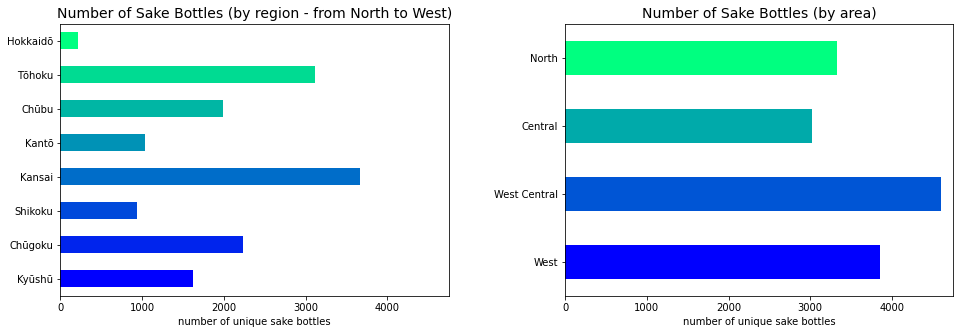

In [37]:
def make_sake_count_charts(df_sake):
    # region prep
    regions = ['Kyūshū', 'Chūgoku', 'Shikoku', 'Kansai', 'Kantō', 'Chūbu', 'Tōhoku', 'Hokkaidō']
    r_mapping = {region: i for i, region in enumerate(regions)}
    region_counts = pd.DataFrame(df_sake.groupby('region').name.count()).rename({'name': 'num_sake'}, axis=1)
    r_key = region_counts.index.map(r_mapping)

    # area prep
    areas = ['West', 'West Central', 'Central', 'North']
    areas_dict = {'Kyūshū': 'West', 'Chūgoku': 'West', 
                  'Shikoku': 'West Central', 'Kansai': 'West Central', 
                  'Kantō': 'Central', 'Chūbu': 'Central', 
                  'Tōhoku': 'North', 'Hokkaidō': 'North'}
    a_mapping = {area: i for i, area in enumerate(areas)}
    region_counts['area'] = region_counts.index.map(areas_dict)
    area_counts = pd.DataFrame(region_counts.groupby('area').num_sake.sum())
    a_key = area_counts.index.map(a_mapping)

    # charts
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    xlim = (0, 4750)
    xlabel = 'number of unique sake bottles'
    fd = {'fontsize': 14}
    
    r_colors = cm.winter(np.linspace(0,1,len(region_counts)))
    region_counts.iloc[r_key.argsort()].num_sake.plot(kind='barh', legend=False, ax=axs[0], xlim=xlim, xlabel='', color=r_colors)
    axs[0].set_title('Number of Sake Bottles (by region - from North to West)', fontdict=fd)
    axs[0].set_xlabel(xlabel)

    a_colors = cm.winter(np.linspace(0,1,len(area_counts)))
    area_counts.iloc[a_key.argsort()].num_sake.plot(kind='barh', legend=False, ax=axs[1], xlim=xlim, xlabel='', color=a_colors)
    axs[1].set_title('Number of Sake Bottles (by area)', fontdict=fd)
    axs[1].set_xlabel(xlabel)
    
    plt.subplots_adjust(wspace=0.3)
    
make_sake_count_charts(df_sake)

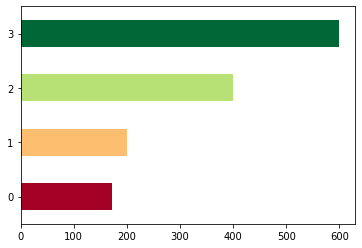

In [38]:
# example from stack overflow - note that specifying the column of the df is needed to get 'colors' to work right
df = pd.DataFrame({'days':[172, 200, 400, 600]})
colors = cm.RdYlGn(np.linspace(0,1,len(df)))
df['days'].plot(kind='barh', color=colors)
plt.show()

### gravity / acidity chart and column

#### confusion matrix for smv / acidity

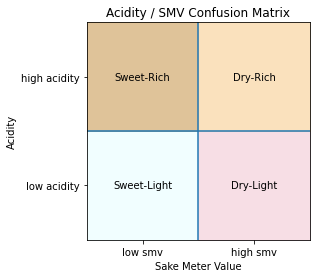

In [39]:
def make_smv_acid_matrix():
    # figure
    fig, ax = plt.subplots(figsize=(4,4))
    plt.plot()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline()
    plt.axvline()
    
    # ticks
    plt.xticks([-0.5, 0.5])
    plt.yticks([-0.5, 0.5])
    ax.set_xticklabels(['low smv', 'high smv'])
    ax.set_yticklabels(['low acidity', 'high acidity'])
    
    # text
    plt.xlabel('Sake Meter Value')
    plt.ylabel('Acidity')
    plt.text(-0.5, 0.5, "Sweet-Rich", horizontalalignment='center', verticalalignment='center')
    plt.text(0.5, 0.5, "Dry-Rich", horizontalalignment='center', verticalalignment='center')
    plt.text(-0.5, -0.5, "Sweet-Light", horizontalalignment='center', verticalalignment='center')
    plt.text(0.5, -0.5, "Dry-Light", horizontalalignment='center', verticalalignment='center')
    plt.title("Acidity / SMV Confusion Matrix")
    
    # color
    alpha=0.7
    ax.fill_between([-1, 0], -1, 0, alpha=alpha, color='#ECFEFF')  # sweet-light (light blue)
    ax.fill_between([-1, 0], 0, 1, alpha=alpha, color='#D2AA6E')  # sweet-rich (brown)
    ax.fill_between([0, 1], -1, 0, alpha=alpha, color='#F5D1DB')  # dry_rich (pink)
    ax.fill_between([0, 1], 0, 1, alpha=alpha, color='#F9D5A2')  # dry_light (orange)

make_smv_acid_matrix()

#### straight vs. skewed plots

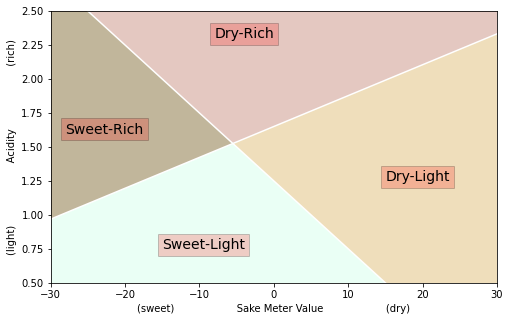

In [156]:
def skewed_smv_acid_matrix():
    # setup figure
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.xlim(-30, 30)
    plt.ylim(0.5, 2.5)
    
    # scatter plot that won't appear (for some reason, not using a scatter plot changes the colors)
    plt.scatter(0, 5)

    # add text
    plt.ylabel('(light)                    Acidity                    (rich)')
    plt.xlabel('(sweet)                    Sake Meter Value                    (dry)')

    # create fill colors
    x = np.arange(-35, 35, 0.5)
    y1 = (0.5/22) * x + 1.65
    y2 = (-0.5/10) * x + 1.25
    
    ax.set_facecolor('#eafff5')
    plt.fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    plt.fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    plt.fill_between(x, y1, np.max(y2), alpha=0.25)
    plt.plot(x, y1, color='white')
    plt.plot(x, y2, color='white')

    # add all text
    plt.text(-8, 2.3, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(-28, 1.6, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(-15, 0.75, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(15, 1.25, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    
    plt.savefig("skewed.png")
    
skewed_smv_acid_matrix()

In [154]:
x = np.arange(-35, 35, 0.5)
y1 = (0.5/22) * x + 1.65
y2 = (-0.5/10) * x + 1.25

m = (0.5/22) + (0.5/10)
b = 1.25 - 1.65
x_int = b / m
y_int = (0.5/22) * x_int + 1.65

print(x_int, y_int)

-5.499999999999999 1.525


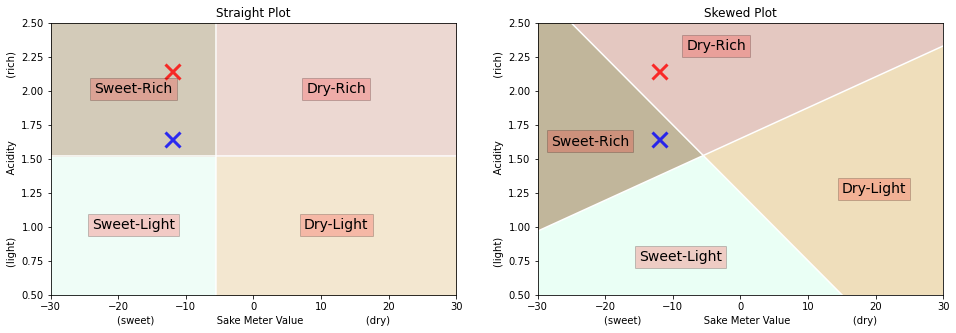

In [160]:
def make_straight_vs_skewed():
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # saving lines
    x = np.arange(-35, 35, 0.5)
    y1 = (0.5/22) * x + 1.65
    y2 = (-0.5/10) * x + 1.25

    m = (0.5/22) + (0.5/10)
    b = 1.25 - 1.65
    x_int = b / m
    y_int = (0.5/22) * x_int + 1.65

    # straight plot
    axs[0].plot()
    axs[0].set_xlim(-30, 30)
    axs[0].set_ylim(0.5, 2.5)
    axs[0].set_title("Straight Plot")

    axs[0].axhline(y=y_int, color='w')
    axs[0].axvline(x=x_int, color='w')

    axs[0].set_ylabel('(light)                    Acidity                    (rich)')
    axs[0].set_xlabel('(sweet)                    Sake Meter Value                    (dry)')

    alpha=0.7
    axs[0].fill_between([-30, x_int], 0.5, y_int, alpha=alpha, color='#e9fdf4') # sweet-light (light blue)
    axs[0].fill_between([-30, x_int], y_int, 2.5, alpha=alpha, color='#c1b69c') # sweet-rich (brown)
    axs[0].fill_between([x_int, 30], 0.5, y_int, alpha=alpha, color='#efdebc') # dry_light (pink)
    axs[0].fill_between([x_int, 30], y_int, 2.5, alpha=alpha, color='#e4c8c0') # dry_rich (orange)

    axs[0].text((30 + x_int) / 2, (2.5 + y_int) / 2, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2), horizontalalignment='center', verticalalignment='center')
    axs[0].text((-30 + x_int) / 2, (2.5 + y_int) / 2, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2), horizontalalignment='center', verticalalignment='center')
    axs[0].text((-30 + x_int) / 2, (0.5 + y_int) / 2, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2), horizontalalignment='center', verticalalignment='center')
    axs[0].text((30 + x_int) / 2, (0.5 + y_int) / 2, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2), horizontalalignment='center', verticalalignment='center')

    # skewed plot
    axs[1].scatter(0, 5)
    axs[1].set_xlim(-30, 30)
    axs[1].set_ylim(0.5, 2.5)
    axs[1].set_title("Skewed Plot")

    axs[1].set_ylabel('(light)                    Acidity                    (rich)')
    axs[1].set_xlabel('(sweet)                    Sake Meter Value                    (dry)')

    axs[1].set_facecolor('#eafff5')
    axs[1].fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    axs[1].fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    axs[1].fill_between(x, y1, np.max(y2), alpha=0.25)
    axs[1].plot(x, y1, color='white')
    axs[1].plot(x, y2, color='white')

    axs[1].text(-8, 2.3, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[1].text(-28, 1.6, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[1].text(-15, 0.75, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[1].text(15, 1.25, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))

    # plot two sake bottles
    smv = -12
    acid_1 = 1.65
    acid_2 = acid_1 + 0.5

    for i in range(2):
        axs[i].plot(
            smv,
            acid_2,
            marker='x',
            label='sake 1',
            markersize=15,
            markeredgewidth=3,
            markeredgecolor='red',
            alpha=0.8
        )
        axs[i].plot(
            smv,
            acid_1,
            marker='x',
            label='sake 2',
            markersize=15,
            markeredgewidth=3,
            markeredgecolor='blue',
            alpha=0.8
        )
#         axs[i].legend(loc='upper right')

make_straight_vs_skewed()

#### smv / acidity for each region

In [43]:
list(df_sake.region.unique())

['Chūbu',
 'Shikoku',
 'Kyūshū',
 'Hokkaidō',
 'Kantō',
 'Tōhoku',
 'Chūgoku',
 'Kansai']

In [44]:
x = np.arange(-35, 35, 0.5)
y1 = (0.5/22) * x + 1.65
y2 = (-0.5/10) * x + 1.25

# m = (0.5/22) + (0.5/10)
# b = 1.25 - 1.65
# x_intercept = b / m

regions = ['Hokkaidō', 'Tōhoku', 'Chūbu', 'Kantō', 'Kansai', 'Shikoku', 'Chūgoku', 'Kyūshū']

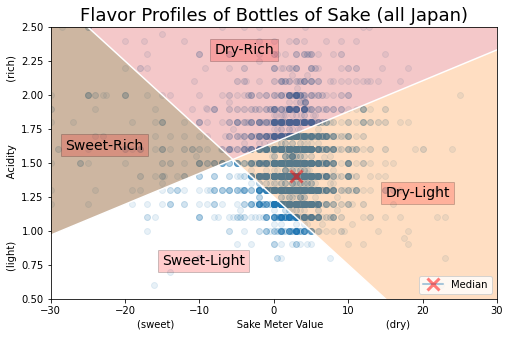

In [45]:
def acid_smv_scatter_Japan(df_sake):
    # setup figure
    plt.figure(figsize=(8, 5))
    plt.xlim(-30, 30)
    plt.ylim(0.5, 2.5)
    
    # make plot
    plt.scatter(
        df_sake['gravity_avg'],
        df_sake['acidity_avg'],
        alpha=0.1)
    
    # plot median value
    plt.plot(
        df_sake['gravity_avg'].median(),
        df_sake['acidity_avg'].median(),
        marker='x',
        label='Median',
        markersize=12,
        markeredgewidth=3,
        markeredgecolor='red',
        alpha=0.5
    )
    plt.legend(loc='lower right')

    # add titles
    plt.title('Flavor Profiles of Bottles of Sake (all Japan)', fontsize=18)
    plt.ylabel('(light)                    Acidity                    (rich)')
    plt.xlabel('(sweet)                    Sake Meter Value                    (dry)')

    # create fill colors
    x = np.arange(-35, 35, 0.5)
    y1 = (0.5/22) * x + 1.65
    y2 = (-0.5/10) * x + 1.25
    
    plt.fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    plt.fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    plt.fill_between(x, y1, np.max(y2), alpha=0.25)
    plt.plot(x, y1, color='white')
    plt.plot(x, y2, color='white')

    # add all text
    plt.text(-8, 2.3, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(-28, 1.6, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(-15, 0.75, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    plt.text(15, 1.25, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    
acid_smv_scatter_Japan(df_sake)

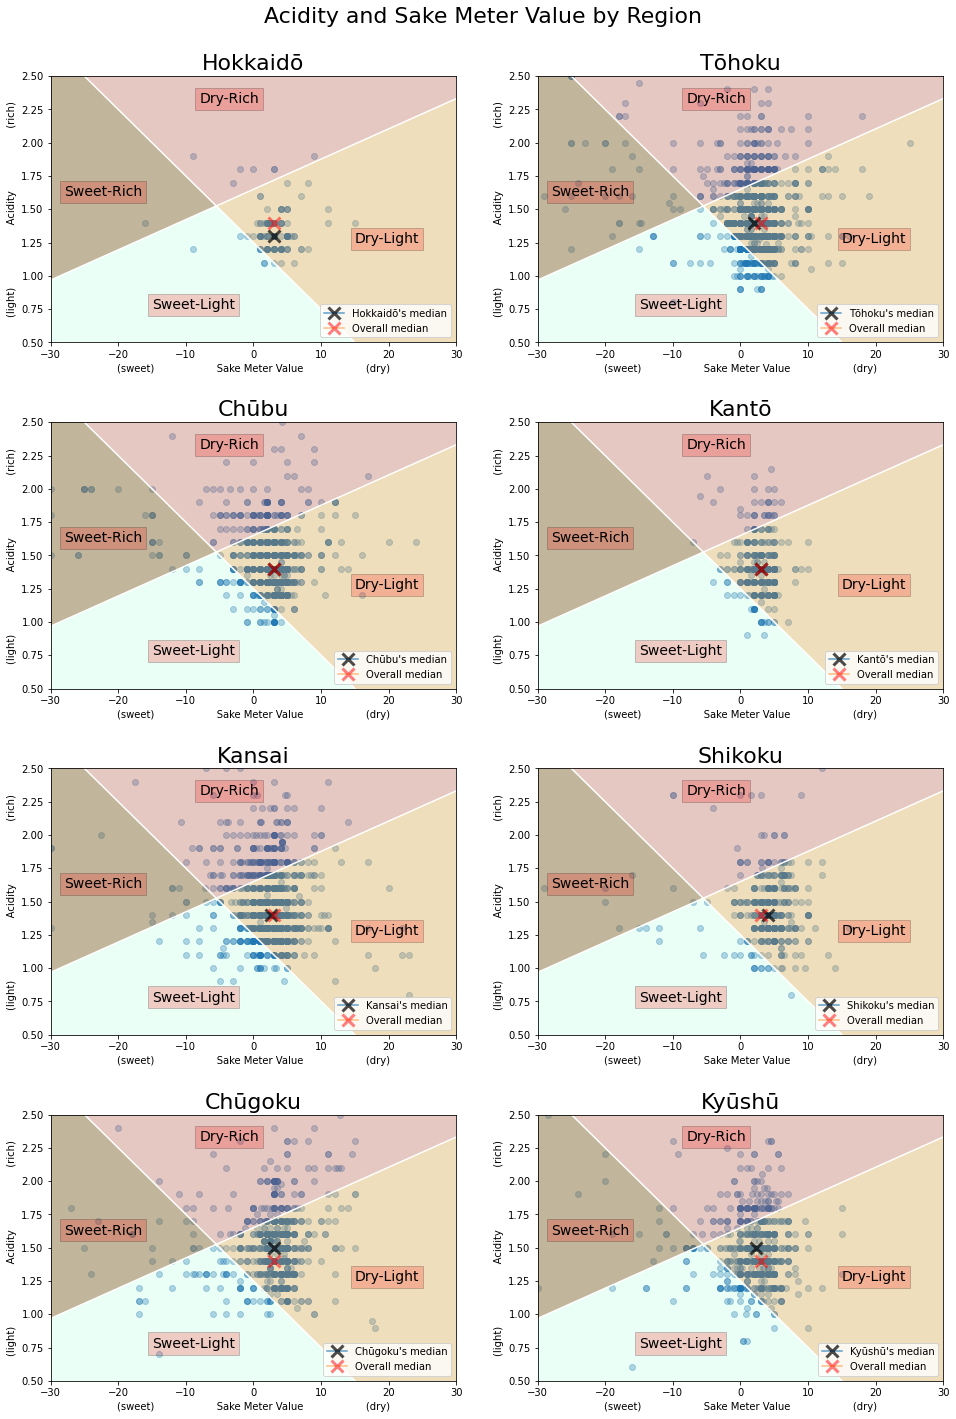

In [46]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 24))
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Acidity and Sake Meter Value by Region", fontsize=22, y=0.92)

for region, ax in zip(regions, axs.ravel()):
    # plot acidity and smv
    ax.scatter(
        df_sake[df_sake['region'] == region]['gravity_avg'], 
        df_sake[df_sake['region'] == region]['acidity_avg'], 
        alpha=0.3
    )
    
    # plot region's median value
    ax.plot(
        df_sake[df_sake['region'] == region]['gravity_avg'].median(),
        df_sake[df_sake['region'] == region]['acidity_avg'].median(),
        marker='x',
        label=f"{region}'s median",
        markersize=12,
        markeredgewidth=3,
        markeredgecolor='black',
        alpha=0.7
    )
    
    # plot overall median value
    ax.plot(
        df_sake['gravity_avg'].median(),
        df_sake['acidity_avg'].median(),
        marker='x',
        label='Overall median',
        markersize=12,
        markeredgewidth=3,
        markeredgecolor='red',
        alpha=0.5
    )
    ax.legend(loc='lower right')
    
    # set limit
    ax.set_xlim(-30, 30)
    ax.set_ylim(0.5, 2.5)
    
    # add titles
    ax.set_title(region, fontsize=22)
    ax.set_ylabel('(light)                    Acidity                    (rich)')
    ax.set_xlabel('(sweet)                    Sake Meter Value                    (dry)')
    
    # create fill colors
    ax.set_facecolor('#eafff5')
    ax.fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    ax.fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    ax.fill_between(x, y1, np.max(y2), alpha=0.25)
    ax.plot(x, y1, color='white')
    ax.plot(x, y2, color='white')
    
    # add all text
    ax.text(-8, 2.3, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    ax.text(-28, 1.6, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    ax.text(-15, 0.75, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    ax.text(15, 1.25, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))

#### smv / acidity median and mean by region

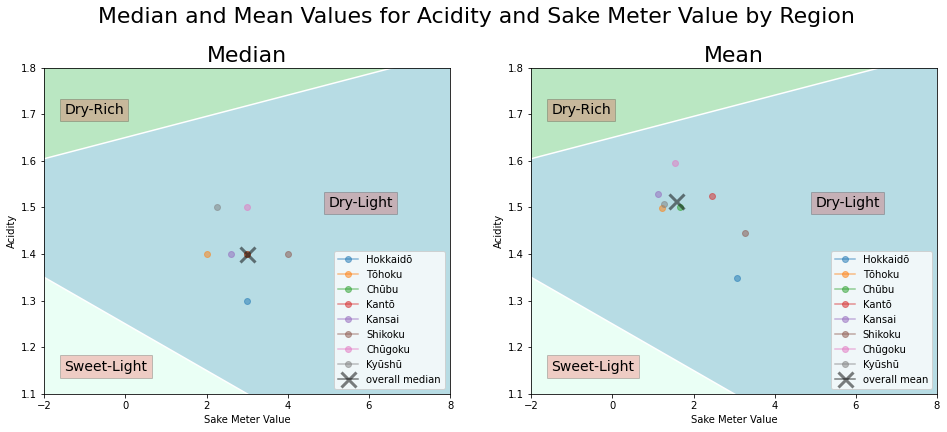

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle("Median and Mean Values for Acidity and Sake Meter Value by Region", fontsize=22, y=1.02)
axs[0].set_title('Median', fontsize=22)
axs[1].set_title('Mean', fontsize=22)

for i in range(2):
    # set limits
    axs[i].set_xlim(-2, 8)
    axs[i].set_ylim(1.1, 1.8)
    
    # create fill colors
    axs[i].set_facecolor('#eafff5')
    axs[i].fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    axs[i].fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    axs[i].fill_between(x, y1, np.max(y2), alpha=0.25)
    axs[i].plot(x, y1, color='white')
    axs[i].plot(x, y2, color='white')
    
    # add labels and text
    axs[i].set_xlabel('Sake Meter Value')
    axs[i].set_ylabel('Acidity')
    axs[i].text(5, 1.5, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[i].text(-1.5, 1.15, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[i].text(-1.5, 1.7, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))

for region in regions:
    axs[0].plot(
        df_sake[df_sake['region'] == region]['gravity_avg'].median(), 
        df_sake[df_sake['region'] == region]['acidity_avg'].median(), 
        marker='o',
        label=region,
        alpha=0.5
    )
#     axs[0].legend()
    
for region in regions:
    axs[1].plot(
        df_sake[df_sake['region'] == region]['gravity_avg'].mean(), 
        df_sake[df_sake['region'] == region]['acidity_avg'].mean(), 
        marker='o',
        label=region,
        alpha=0.5
    )
#     axs[1].legend()
    
axs[0].plot(
    df_sake['gravity_avg'].median(),
    df_sake['acidity_avg'].median(),
    marker='x',
    label='overall median',
    color='black',
    markersize=15,
    alpha=0.5,
    markeredgewidth=3
)

axs[1].plot(
    df_sake['gravity_avg'].mean(),
    df_sake['acidity_avg'].mean(),
    marker='x',
    label='overall mean',
    color='black',
    markersize=15,
    alpha=0.5,
    markeredgewidth=3
)

axs[0].legend()
axs[1].legend();

#### smv/acidity median and mean by prefecture
TODO: Try using plotly for this

In [48]:
def get_top_x_dist(x):   
    """
    Calculates the euclidean distance of each prefecture's median and mean smv / acidity from the 
    global median and mean.
    Returns a dataframe and two numpy arrays of the top x furthest prefectures from the global median and mean. 
    
    args
        x: how many top x furthest prefectures to include
    """
    
    pref_list = list(df_sake.prefecture_eng.unique())
    pref_dict = {'prefecture': [], 'smv_med': [], 'acidity_med': [], 'smv_mean': [], 'acidity_mean': [], 'median_dist': [], 'mean_dist': []}
    median_point = df_sake['acidity_avg'].median()
    mean_point = df_sake['acidity_avg'].mean()
#     median_point = [df_sake['gravity_avg'].median(), df_sake['acidity_avg'].median()]
#     mean_point = [df_sake['gravity_avg'].mean(), df_sake['acidity_avg'].mean()]

    for pref in pref_list:
        smv_med = df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].median()
        acidity_med = df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].median()
        smv_mean = df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].mean()
        acidity_mean = df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].mean()
        pref_median = acidity_med
        pref_mean = acidity_mean
#         pref_median = [smv_med, acidity_med]
#         pref_mean = [smv_mean, acidity_mean]
        
        pref_dict['prefecture'].append(pref)
        pref_dict['smv_med'].append(smv_med)
        pref_dict['acidity_med'].append(acidity_med)
        pref_dict['smv_mean'].append(smv_mean)
        pref_dict['acidity_mean'].append(acidity_mean)
        pref_dict['median_dist'].append(math.dist([median_point], [pref_median]))
        pref_dict['mean_dist'].append(math.dist([mean_point], [pref_mean]))
        

    df_pref_dist = pd.DataFrame(pref_dict)
    top_x_median = np.array(df_pref_dist.sort_values('median_dist', ascending=False).iloc[:x])
    top_x_mean = np.array(df_pref_dist.sort_values('mean_dist', ascending=False).iloc[:x])
#     top_x_median = list(df_pref_dist.sort_values('median_dist', ascending=False).iloc[:x, 0].values)
#     top_x_mean = list(df_pref_dist.sort_values('mean_dist', ascending=False).iloc[:x, 0].values)
    
    return df_pref_dist, top_x_median, top_x_mean

In [49]:
def get_top_x_vals(x):   
    """
    Calculates the x number highest / lowest smv and acidity (median and mean) by prefecture.
    Returns a dataframe and two numpy arrays of the top x furthest prefectures from the global median and mean. 
    
    args
        x: how many top x prefectures to include
    """
    
    pref_list = list(df_sake.prefecture_eng.unique())
    pref_dict = {'prefecture': [], 'smv_med': [], 'acidity_med': [], 'smv_mean': [], 'acidity_mean': []}

    for pref in pref_list:
        pref_dict['prefecture'].append(pref)
        pref_dict['smv_med'].append(df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].median())
        pref_dict['acidity_med'].append(df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].median())
        pref_dict['smv_mean'].append(df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].mean())
        pref_dict['acidity_mean'].append(df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].mean())

    df_pref_dist = pd.DataFrame(pref_dict)
    
    # create arrays for x number highest / lowest acidity and smv values
    top_x_median = []
    top_x_mean = []
    
    top_x_median = np.array(df_pref_dist.sort_values('smv_med', ascending=False).iloc[:x])
    top_x_median = np.append(top_x_median, np.array(df_pref_dist.sort_values('smv_med', ascending=True).iloc[:x]), axis=0)
    top_x_median = np.append(top_x_median, np.array(df_pref_dist.sort_values('acidity_med', ascending=False).iloc[:x]), axis=0)
    top_x_median = np.append(top_x_median, np.array(df_pref_dist.sort_values('acidity_med', ascending=True).iloc[:x]), axis=0)

    top_x_mean = np.array(df_pref_dist.sort_values('smv_mean', ascending=False).iloc[:x])
    top_x_mean = np.append(top_x_mean, np.array(df_pref_dist.sort_values('smv_mean', ascending=True).iloc[:x]), axis=0)
    top_x_mean = np.append(top_x_mean, np.array(df_pref_dist.sort_values('acidity_mean', ascending=False).iloc[:x]), axis=0)
    top_x_mean = np.append(top_x_mean, np.array(df_pref_dist.sort_values('acidity_mean', ascending=True).iloc[:x]), axis=0)
    
    # removing duplicates (np.unique won't work for arrays with mixed dtypes)
    prefs_med = []
    del_med = []
    prefs_mean = []
    del_mean = []

    for ix in np.ndindex(top_x_median.shape[0]):
        if top_x_median[ix][0] in prefs_med:
            del_med.append(ix)
        else:
            prefs_med.append(top_x_median[ix][0])
            
    for ix in np.ndindex(top_x_mean.shape[0]):
        if top_x_mean[ix][0] in prefs_mean:
            del_mean.append(ix)
        else:
            prefs_mean.append(top_x_mean[ix][0])
    
    return df_pref_dist, np.delete(top_x_median, del_med, axis=0), np.delete(top_x_mean, del_mean, axis=0)

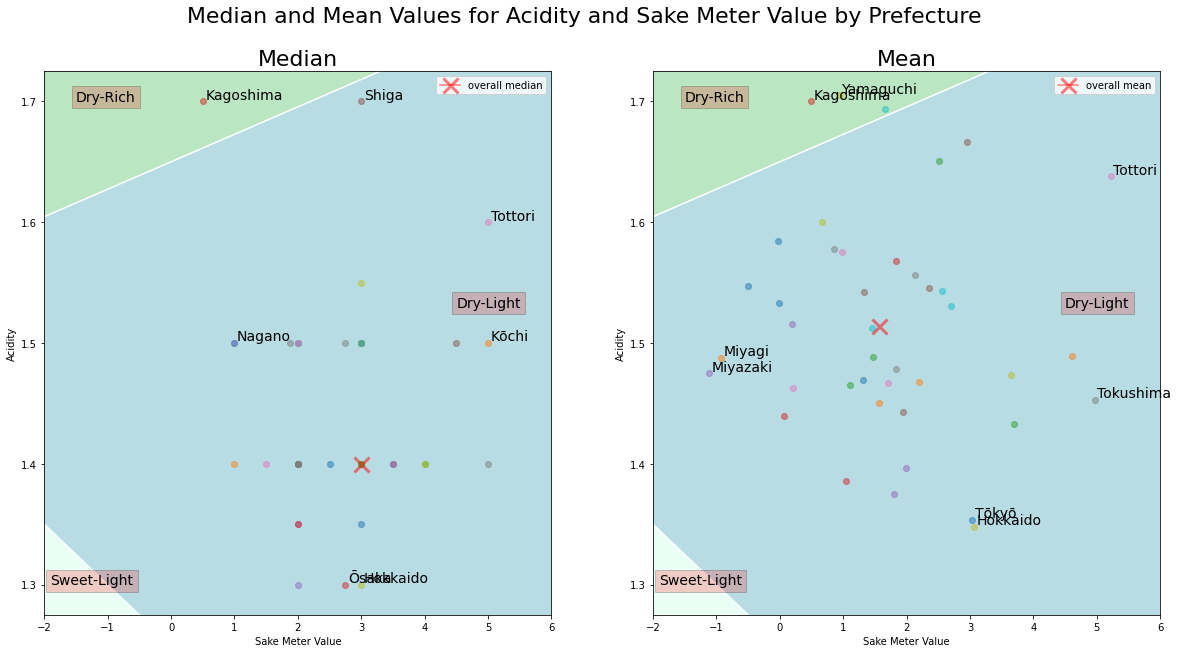

In [50]:
pref_list = list(df_sake.prefecture_eng.unique())

fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle("Median and Mean Values for Acidity and Sake Meter Value by Prefecture", fontsize=22, y=0.97)
axs[0].set_title('Median', fontsize=22)
axs[1].set_title('Mean', fontsize=22)

for i in range(2):
    # set limits
    axs[i].set_xlim(-2, 6)
    axs[i].set_ylim(1.275, 1.725)
    
    # create fill colors
    axs[i].set_facecolor('#eafff5')
    axs[i].fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
    axs[i].fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
    axs[i].fill_between(x, y1, np.max(y2), alpha=0.25)
    axs[i].plot(x, y1, color='white')
    axs[i].plot(x, y2, color='white')
    
    # add labels and text
    axs[i].set_xlabel('Sake Meter Value')
    axs[i].set_ylabel('Acidity')
    axs[i].text(4.5, 1.53, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[i].text(-1.9, 1.3, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
    axs[i].text(-1.5, 1.7, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))

for pref in pref_list:
    axs[0].plot(
        df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].median(), 
        df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].median(), 
        marker='o',
        #label=pref,
        alpha=0.5
    )
    
for pref in pref_list:
    axs[1].plot(
        df_sake[df_sake['prefecture_eng'] == pref]['gravity_avg'].mean(), 
        df_sake[df_sake['prefecture_eng'] == pref]['acidity_avg'].mean(), 
        marker='o',
        #label=pref,
        alpha=0.5
    )
    
axs[0].plot(
    df_sake['gravity_avg'].median(),
    df_sake['acidity_avg'].median(),
    marker='x',
    label='overall median',
    color='r',
    markersize=15,
    alpha=0.5,
    markeredgewidth=3
)

axs[1].plot(
    df_sake['gravity_avg'].mean(),
    df_sake['acidity_avg'].mean(),
    marker='x',
    label='overall mean',
    color='r',
    markersize=15,
    alpha=0.5,
    markeredgewidth=3
)

### Trying to make annotate look good ... I should just use plotly!  Maybe later

# df_pref_dist, top_x_median, top_x_mean = get_top_x_dist(20)

# pref_dist_med = [0]
# pref_dist_mean = [0]

# for pref in top_x_median:
#     if math.dist([pref[5]], [pref_dist_med[-1]]) < 0.001:
#         continue
#     print(math.sqrt((pref[5] - pref_dist_med[-1]) ** 2))
#     axs[0].annotate(pref[0], (pref[1]+0.04, pref[2]+0.002), fontsize=14)
#     pref_median_dist.append(pref[5])
# for pref in top_x_mean:
#     if pref[6] == pref_dist_mean[-1]:
#         continue
#     axs[1].annotate(pref[0], (pref[3]+0.04, pref[4]+0.002), fontsize=14)
#     pref_mean_dist.append(pref[6]);

df_pref_dist, top_x_median, top_x_mean = get_top_x_vals(2)

for pref in top_x_median:
    axs[0].annotate(pref[0], (pref[1]+0.04, pref[2]+0.002), fontsize=14)
for pref in top_x_mean:
    axs[1].annotate(pref[0], (pref[3]+0.04, pref[4]+0.002), fontsize=14)
    
axs[0].legend()
axs[1].legend();

#### counting sweet / dry + rich / light by region and area

In [51]:
def get_rlds(x, y):
    # handling nan
    if pd.isna(x) == True or pd.isna(y) == True:
        return np.nan
    
    # categorizing sake as rich / light and dry / sweet based on SMV and acidity values
    rich_light_y = (0.5/22) * x + 1.65
    dry_sweet_y = (-0.5/10) * x + 1.25
    
    if rich_light_y > y and dry_sweet_y > y:
        return "sweet-light"
    elif rich_light_y < y and dry_sweet_y > y:
        return "sweet-rich"
    elif rich_light_y > y and dry_sweet_y < y:
        return "dry-light"
    else:
        return "dry-rich"

In [52]:
df_sake['flavor_category'] = df_sake.apply(lambda x: get_rlds(x['gravity_avg'], x['acidity_avg']), axis=1)

**checking time for map vs. replace**

In [53]:
%%time
flavor_map = {"dry-light": 1, "sweet-rich": 0, "sweet-light": 0, "dry-rich": 0, np.nan: 0}
df_sake['flavor_category'].map(flavor_map).value_counts()

CPU times: user 4.39 ms, sys: 1.19 ms, total: 5.58 ms
Wall time: 5.7 ms


0    10634
1     4172
Name: flavor_category, dtype: int64

In [54]:
%%time
df_sake['flavor_category'].replace('dry-light', 1).replace([np.nan, "sweet-light", "sweet-rich", "dry-rich"], 0).value_counts()

CPU times: user 12.8 ms, sys: 2.65 ms, total: 15.4 ms
Wall time: 13.1 ms


0    10634
1     4172
Name: flavor_category, dtype: int64

**creating 0 / 1 flavor category columns**

In [55]:
def add_flavor_cats(df_sake):
    dry_light = {"dry-light": 1, "sweet-rich": 0, "sweet-light": 0, "dry-rich": 0, np.nan: 0}
    dry_rich = {"dry-light": 0, "sweet-rich": 0, "sweet-light": 0, "dry-rich": 1, np.nan: 0}
    sweet_light = {"dry-light": 0, "sweet-rich": 0, "sweet-light": 1, "dry-rich": 0, np.nan: 0}
    sweet_rich = {"dry-light": 0, "sweet-rich": 1, "sweet-light": 0, "dry-rich": 0, np.nan: 0}
    
    df_sake['dry_light'] = df_sake['flavor_category'].map(dry_light)
    df_sake['dry_rich'] = df_sake['flavor_category'].map(dry_rich)
    df_sake['sweet_light'] = df_sake['flavor_category'].map(sweet_light)
    df_sake['sweet_rich'] = df_sake['flavor_category'].map(sweet_rich)
    
    return df_sake

In [56]:
df_sake = add_flavor_cats(df_sake)

In [57]:
def make_df_flavor(df_sake):
    """
    Create two dataframes that show various aggregates of dry / sweet and light / rich matrix
    - 1 dataframe for 8 regions
    - 1 dataframe for 4 larger areas (four groups of 2 smaller regions)
    """
    # group df_sake by region
    df_flavor = df_sake.groupby('region').agg(
        {
        'name': 'count',
        'company': 'nunique',
        'dry_light': 'sum', 
        'dry_rich': 'sum', 
        'sweet_light': 'sum', 
        'sweet_rich': 'sum'
        }
    ).rename({'name': 'num_sake', 'company': 'num_company'}, axis=1)

    # add rows for 4 larger areas
    West = ["Kyūshū", "Chūgoku"]
    West_Central = ["Shikoku", "Kansai"]
    Central = ["Chūbu", "Kantō"]
    North = ["Tōhoku", "Hokkaidō"]

    df_flavor.loc['West'] = df_flavor.loc[West, :].sum()
    df_flavor.loc['West_Central'] = df_flavor.loc[West_Central, :].sum()
    df_flavor.loc['Central'] = df_flavor.loc[Central, :].sum()
    df_flavor.loc['North'] = df_flavor.loc[North, :].sum()
    df_flavor

    # adding columns 
    df_flavor['total'] = df_flavor['dry_light'] + df_flavor['dry_rich'] + df_flavor['sweet_light'] + df_flavor['sweet_rich']
    df_flavor['dry'] = df_flavor['dry_light'] + df_flavor['dry_rich']
    df_flavor['sweet'] = df_flavor['sweet_light'] + df_flavor['sweet_rich']
    df_flavor['light'] = df_flavor['dry_light'] + df_flavor['sweet_light']
    df_flavor['rich'] = df_flavor['dry_rich'] + df_flavor['sweet_rich']
    df_flavor['dry_ratio'] = df_flavor['dry'] / df_flavor['total']
    df_flavor['sweet_ratio'] = df_flavor['sweet'] / df_flavor['total']
    df_flavor['light_ratio'] = df_flavor['light'] / df_flavor['total']
    df_flavor['rich_ratio'] = df_flavor['rich'] / df_flavor['total']
    df_flavor['dry_light_ratio'] = df_flavor['dry_light'] / df_flavor['total']
    df_flavor['dry_rich_ratio'] = df_flavor['dry_rich'] / df_flavor['total']
    df_flavor['sweet_light_ratio'] = df_flavor['sweet_light'] / df_flavor['total']
    df_flavor['sweet_rich_ratio'] = df_flavor['sweet_rich'] / df_flavor['total']

    return df_flavor.head(8), df_flavor.tail(4)

In [66]:
df_flavor, df_flavor_area = make_df_flavor(df_sake)

In [67]:
df_flavor

,num_sake,num_company,dry_light,dry_rich,sweet_light,sweet_rich,total,dry,sweet,light,rich,dry_ratio,sweet_ratio,light_ratio,rich_ratio,dry_light_ratio,dry_rich_ratio,sweet_light_ratio,sweet_rich_ratio
region,,,,,,,,,,,,,,,,,,,
Chūbu,1992,106,551,150,47,30,778,701,77,598,180,0.901028,0.098972,0.768638,0.231362,0.708226,0.192802,0.060411,0.038560
Chūgoku,2233,124,570,140,52,29,791,710,81,622,169,0.897598,0.102402,0.786346,0.213654,0.720607,0.176991,0.065740,0.036662
Hokkaidō,220,10,102,10,4,1,117,112,5,106,11,0.957265,0.042735,0.905983,0.094017,0.871795,0.085470,0.034188,0.008547
Kansai,3663,192,853,305,76,28,1262,1158,104,929,333,0.917591,0.082409,0.736133,0.263867,0.675911,0.241680,0.060222,0.022187
Kantō,1029,66,277,49,22,0,348,326,22,299,49,0.936782,0.063218,0.859195,0.140805,0.795977,0.140805,0.063218,0.000000
Kyūshū,1617,113,466,143,55,27,691,609,82,521,170,0.881331,0.118669,0.753980,0.246020,0.674385,0.206946,0.079595,0.039074
Shikoku,939,52,343,40,22,8,413,383,30,365,48,0.927361,0.072639,0.883777,0.116223,0.830508,0.096852,0.053269,0.019370
Tōhoku,3113,176,1010,255,99,32,1396,1265,131,1109,287,0.906160,0.093840,0.794413,0.205587,0.723496,0.182665,0.070917,0.022923


In [68]:
df_flavor_area

,num_sake,num_company,dry_light,dry_rich,sweet_light,sweet_rich,total,dry,sweet,light,rich,dry_ratio,sweet_ratio,light_ratio,rich_ratio,dry_light_ratio,dry_rich_ratio,sweet_light_ratio,sweet_rich_ratio
region,,,,,,,,,,,,,,,,,,,
West,3850,237,1036,283,107,56,1482,1319,163,1143,339,0.890013,0.109987,0.771255,0.228745,0.699055,0.190958,0.072200,0.037787
West_Central,4602,244,1196,345,98,36,1675,1541,134,1294,381,0.920000,0.080000,0.772537,0.227463,0.714030,0.205970,0.058507,0.021493
Central,3021,172,828,199,69,30,1126,1027,99,897,229,0.912078,0.087922,0.796625,0.203375,0.735346,0.176732,0.061279,0.026643
North,3333,186,1112,265,103,33,1513,1377,136,1215,298,0.910112,0.089888,0.803040,0.196960,0.734964,0.175149,0.068077,0.021811


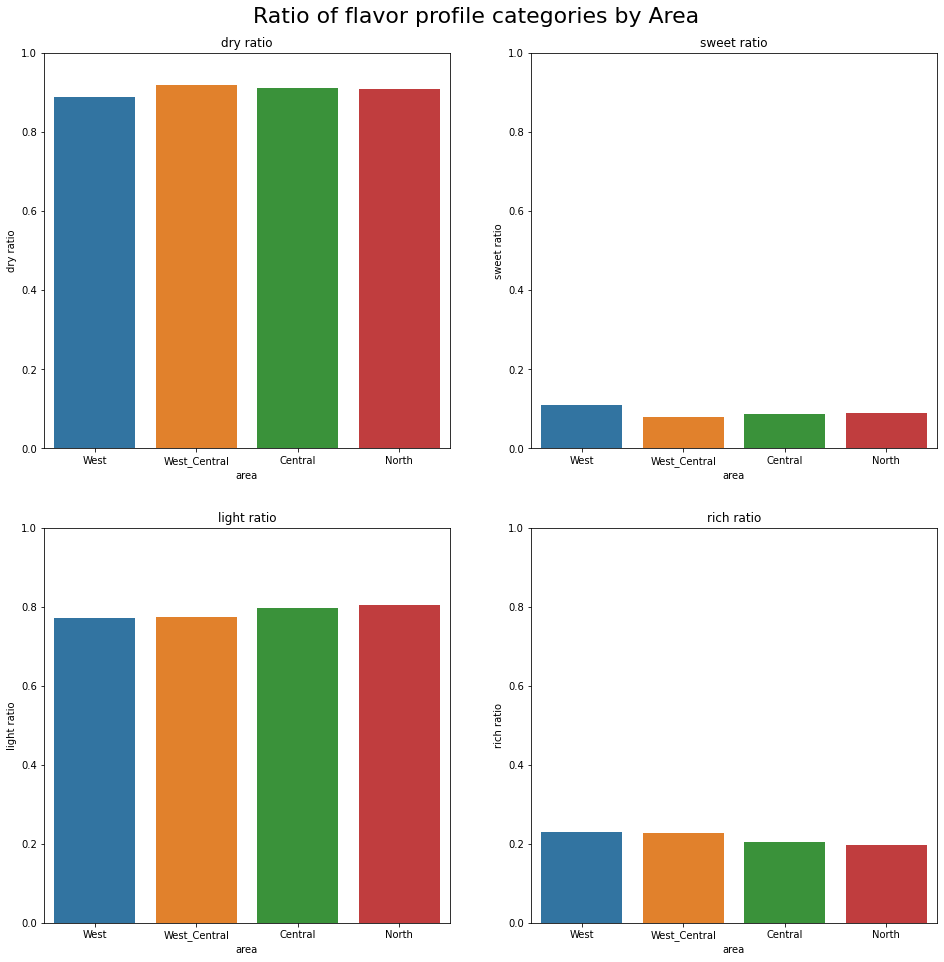

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
# plt.subplots_adjust(hspace=0.3)
fig.suptitle("Ratio of flavor profile categories by Area", fontsize=22, y=0.92)

flavors = ['dry_ratio', 'sweet_ratio', 'light_ratio', 'rich_ratio']

for flavor, ax in zip(flavors, axs.ravel()):
    # plot acidity and smv
    sns.barplot(data = df_flavor_area, x=df_flavor_area.index, y=flavor, ax=ax)
    ax.set_ylim(0, 1.0)
    ax.set_title(flavor.replace("_", " "))
    ax.set_xlabel("area")
    ax.set_ylabel(f"{flavor.replace('_', ' ')}")

# plt.
# sns.barplot(data=df_flavor, x=df_flavor.index, y='dry_ratio')

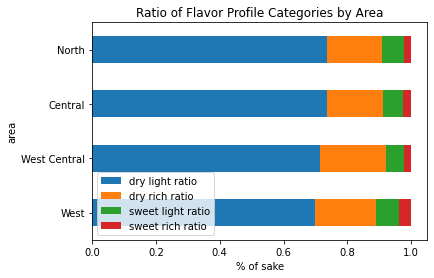

In [70]:
def flavor_stacked_area(df_flavor_area):
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_flavor_area.columns}
    regions = {name: name.replace("_", " ") for name in df_flavor_area.index}
    df_flavor_area = df_flavor_area.rename(columns, axis=1)
    df_flavor_area = df_flavor_area.rename(regions, axis=0)
    
    # make stacked bar plot
    df_flavor_area[['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio']].plot(
        kind='barh', 
        stacked=True, 
        figsize=(6,4),
        legend=True
    ).legend(loc='lower left')
    
    # add labels
    plt.title("Ratio of Flavor Profile Categories by Area")
    plt.xlabel("% of sake")
    plt.ylabel("area")

flavor_stacked_area(df_flavor_area)

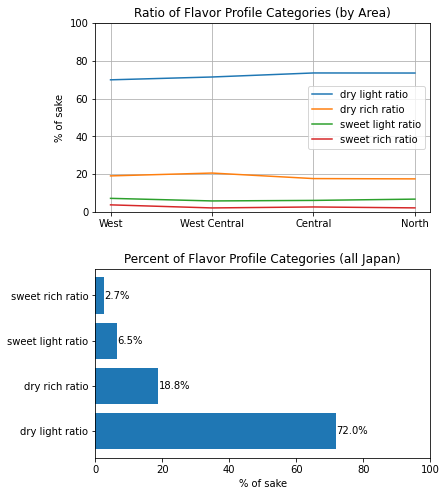

In [71]:
def flavor_line_area(df_flavor_area):
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_flavor_area.columns}
    regions = {name: name.replace("_", " ") for name in df_flavor_area.index}
    df_flavor_area = df_flavor_area.rename(columns, axis=1)
    df_flavor_area = df_flavor_area.rename(regions, axis=0)
    
    fig, axs = plt.subplots(2, 1, figsize=(6,8))
    
    # make line plot for areas
    df_flavor_area[['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio']].mul(100).plot(
        kind='line', 
        legend=True,
        ax=axs[0],
        ylim=(0,100),
        xticks=[0, 1, 2, 3],
        grid=True
    ).legend(loc='center right')
    
    # calculate totals for Japan
    df_flavor_area.loc['total'] = df_flavor_area.sum(axis=0)
    df_flavor_area.loc['total', 'dry light ratio'] = df_flavor_area.loc['total', 'dry light'] / df_flavor_area.loc['total', 'total']
    df_flavor_area.loc['total', 'dry rich ratio'] = df_flavor_area.loc['total', 'dry rich'] / df_flavor_area.loc['total', 'total']
    df_flavor_area.loc['total', 'sweet light ratio'] = df_flavor_area.loc['total', 'sweet light'] / df_flavor_area.loc['total', 'total']
    df_flavor_area.loc['total', 'sweet rich ratio'] = df_flavor_area.loc['total', 'sweet rich'] / df_flavor_area.loc['total', 'total']

    
    # make bar plot for all Japan
    bars = axs[1].barh(
        ['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio'],
        df_flavor_area.loc['total', ['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio']].mul(100)
    )
    axs[1].bar_label(bars, fmt="%.1f%%")
    axs[1].set_xlim(0, 100)
    
    # add labels
    axs[0].set_title("Ratio of Flavor Profile Categories (by Area)")
    axs[0].set_ylabel("% of sake")
    axs[0].set_xlabel("")
    
    axs[1].set_title("Percent of Flavor Profile Categories (all Japan)")
    axs[1].set_xlabel("% of sake")
    
    plt.subplots_adjust(hspace=0.3)

flavor_line_area(df_flavor_area)

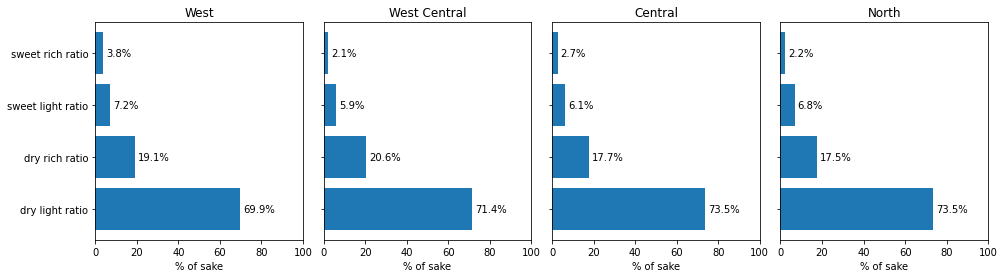

In [72]:
def flavor_bar_area_charts(df_flavor_area):
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_flavor_area.columns}
    areas = {name: name.replace("_", " ") for name in df_flavor_area.index}
    df_flavor_area = df_flavor_area.rename(columns, axis=1)
    df_flavor_area = df_flavor_area.rename(areas, axis=0)
    
    # make bar plots
    fig, axs = plt.subplots(1, 4, figsize=(16,4), sharey=True)
    col = ['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio']
    
    for area, ax in zip(list(areas.values()), axs.ravel()):
        bars = ax.barh(
            col,
            df_flavor_area.loc[area, col].mul(100)
        )
        ax.bar_label(bars, fmt="%.1f%%", padding=3)
        ax.set_xlim(0, 100)
        ax.set_title(f"{area}")
        ax.set_xlabel("% of sake")
        
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
        
flavor_bar_area_charts(df_flavor_area)

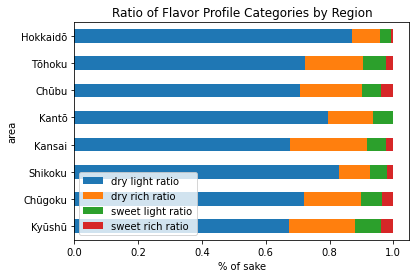

In [73]:
def flavor_stacked_region(df_flavor):
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_flavor.columns}
    regions = {name: name.replace("_", " ") for name in df_flavor.index}
    df_flavor = df_flavor.rename(columns, axis=1)
    df_flavor = df_flavor.rename(regions, axis=0)
    
    # sort regions
    regions = ['Kyūshū', 'Chūgoku', 'Shikoku', 'Kansai', 'Kantō', 'Chūbu', 'Tōhoku', 'Hokkaidō']
    r_mapping = {region: i for i, region in enumerate(regions)}
    r_key = df_flavor.index.map(r_mapping)
    
    # make stacked bar plot
    df_flavor.iloc[r_key.argsort()][['dry light ratio', 'dry rich ratio', 'sweet light ratio', 'sweet rich ratio']].plot(
        kind='barh', 
        stacked=True, 
        figsize=(6,4),
        legend=True
    ).legend(loc='lower left')
    
    # add labels
    plt.title("Ratio of Flavor Profile Categories by Region")
    plt.xlabel("% of sake")
    plt.ylabel("area")
    
    fig = plt.gcf()

flavor_stacked_region(df_flavor)

In [74]:
df_flavor.dry_ratio.mul(100).astype(int)

region
Chūbu       90
Chūgoku     89
Hokkaidō    95
Kansai      91
Kantō       93
Kyūshū      88
Shikoku     92
Tōhoku      90
Name: dry_ratio, dtype: int64

In [75]:
df_flavor.light_ratio.mul(100).astype(int)

region
Chūbu       76
Chūgoku     78
Hokkaidō    90
Kansai      73
Kantō       85
Kyūshū      75
Shikoku     88
Tōhoku      79
Name: light_ratio, dtype: int64

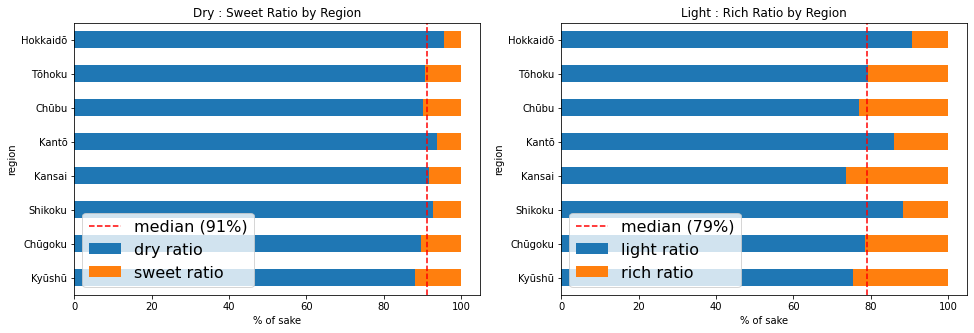

In [76]:
def flavor_stacked_region_2(df_flavor):
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_flavor.columns}
    regions = {name: name.replace("_", " ") for name in df_flavor.index}
    df_flavor = df_flavor.rename(columns, axis=1)
    df_flavor = df_flavor.rename(regions, axis=0)
    
    # sort regions
    regions = ['Kyūshū', 'Chūgoku', 'Shikoku', 'Kansai', 'Kantō', 'Chūbu', 'Tōhoku', 'Hokkaidō']
    r_mapping = {region: i for i, region in enumerate(regions)}
    r_key = df_flavor.index.map(r_mapping)
    
    # make stacked bar plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    df_flavor.iloc[r_key.argsort()][['dry ratio', 'sweet ratio']].mul(100).plot(
        kind='barh', 
        stacked=True, 
        title="Dry : Sweet Ratio by Region",
        ylabel="% of sake",
        legend=True,
        ax=axs[0]
    )#.legend(loc='lower left')
    
    
    df_flavor.iloc[r_key.argsort()][['light ratio', 'rich ratio']].mul(100).plot(
        kind='barh', 
        stacked=True, 
        title="Light : Rich Ratio by Region",
        ylabel="% of sake",
        legend=True,
        ax=axs[1]
    )#.legend(loc='lower left', fontsize=16)
    
    dry_rat = df_flavor['dry ratio'].mul(100).median()
    light_rat = df_flavor['light ratio'].mul(100).median()
    axs[0].axvline(dry_rat, label=f'median ({int(dry_rat)}%)', color='r', linestyle='dashed')
    axs[1].axvline(light_rat, label=f'median ({int(light_rat)}%)', color='r', linestyle='dashed')
    
    axs[0].legend(loc='lower left', fontsize=16)
    axs[1].legend(loc='lower left', fontsize=16)
    
    axs[0].set_xlabel("% of sake")
    axs[1].set_xlabel("% of sake")
    
    plt.subplots_adjust(wspace=0.2)

flavor_stacked_region_2(df_flavor)

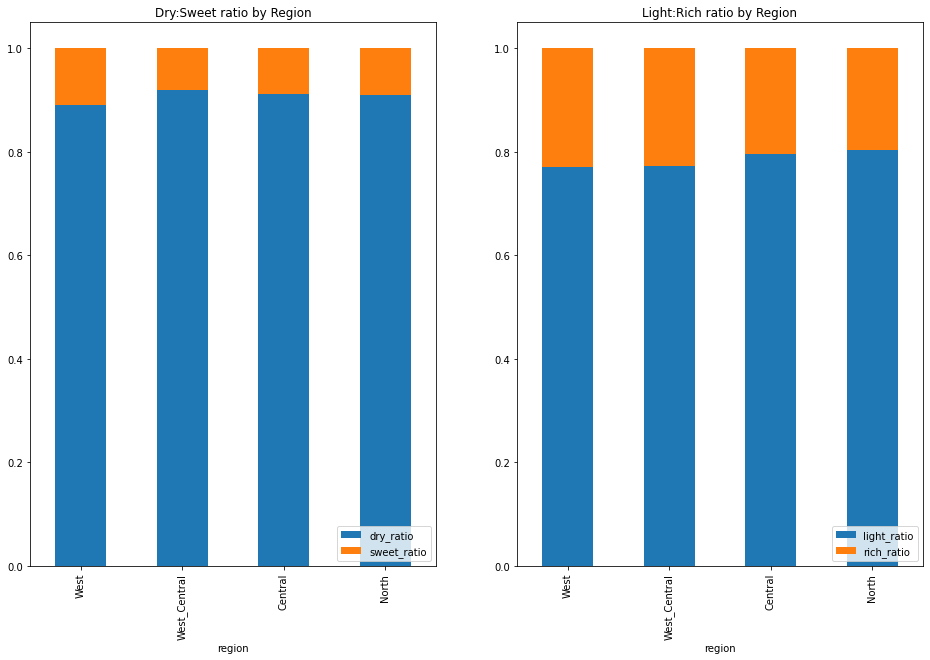

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
df_flavor_area[['dry_ratio', 'sweet_ratio']].plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Dry:Sweet ratio by Region')
axs[0].legend(loc=4)
df_flavor_area[['light_ratio', 'rich_ratio']].plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Light:Rich ratio by Region')
axs[1].legend(loc=4);

#### num of sake bottles with acidity / smv values

In [78]:
df_flavor_area

,num_sake,num_company,dry_light,dry_rich,sweet_light,sweet_rich,total,dry,sweet,light,rich,dry_ratio,sweet_ratio,light_ratio,rich_ratio,dry_light_ratio,dry_rich_ratio,sweet_light_ratio,sweet_rich_ratio
region,,,,,,,,,,,,,,,,,,,
West,3850,237,1036,283,107,56,1482,1319,163,1143,339,0.890013,0.109987,0.771255,0.228745,0.699055,0.190958,0.072200,0.037787
West_Central,4602,244,1196,345,98,36,1675,1541,134,1294,381,0.920000,0.080000,0.772537,0.227463,0.714030,0.205970,0.058507,0.021493
Central,3021,172,828,199,69,30,1126,1027,99,897,229,0.912078,0.087922,0.796625,0.203375,0.735346,0.176732,0.061279,0.026643
North,3333,186,1112,265,103,33,1513,1377,136,1215,298,0.910112,0.089888,0.803040,0.196960,0.734964,0.175149,0.068077,0.021811


In [79]:
regions = ['Kyūshū', 'Chūgoku', 'Shikoku', 'Kansai', 'Kantō', 'Chūbu', 'Tōhoku', 'Hokkaidō']
r_mapping = {region: i for i, region in enumerate(regions)}
r_key = df_flavor.index.map(r_mapping)

areas = ['West', 'West Central', 'Central', 'North']
a_mapping = {area: i for i, area in enumerate(areas)}
a_key = df_flavor_area.index.map(a_mapping)

a_key

Float64Index([0.0, nan, 2.0, 3.0], dtype='float64', name='region')

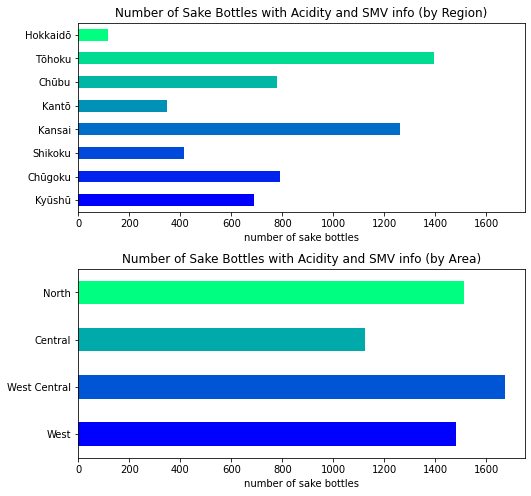

In [80]:
def num_of_sake_bottles_asmv(df_flavor, df_flavor_area):
    # putting regions in the right order
    regions = ['Kyūshū', 'Chūgoku', 'Shikoku', 'Kansai', 'Kantō', 'Chūbu', 'Tōhoku', 'Hokkaidō']
    r_mapping = {region: i for i, region in enumerate(regions)}
    r_key = df_flavor.index.map(r_mapping)
    
    # remove underscores
    areas = {name: name.replace("_", " ") for name in df_flavor_area.index}
    df_flavor_area = df_flavor_area.rename(areas, axis=0)
    
    # putting areas in the right order
    areas = ['West', 'West Central', 'Central', 'North']
    a_mapping = {area: i for i, area in enumerate(areas)}
    a_key = df_flavor_area.index.map(a_mapping)

    # charts
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
    xlim = (0, 1750)
    xlabel = 'number of sake bottles'

    r_colors = cm.winter(np.linspace(0,1,len(df_flavor)))
    df_flavor.iloc[r_key.argsort()].total.plot(kind='barh', legend=False, ax=axs[0], xlim=xlim, xlabel='', color=r_colors)
    axs[0].set_title('Number of Sake Bottles with Acidity and SMV info (by Region)')
    axs[0].set_xlabel(xlabel)

    a_colors = cm.winter(np.linspace(0,1,len(df_flavor_area)))
    df_flavor_area.iloc[a_key.argsort()].total.plot(kind='barh', legend=False, ax=axs[1], xlim=xlim, xlabel='', color=a_colors)
    axs[1].set_title('Number of Sake Bottles with Acidity and SMV info (by Area)')
    axs[1].set_xlabel(xlabel)

    plt.subplots_adjust(hspace=0.3)
    
num_of_sake_bottles_asmv(df_flavor, df_flavor_area)

#### types of sake charts

In [81]:
df_sake.columns

Index(['name', 'name_kana', 'name_romaji', 'sake_type', 'rice_type',
       'rice_origin', 'yeast', 'rice_polishing_rate', 'abv', 'acidity',
       'amino', 'gravity', 'volume', 'prefecture', 'city', 'company',
       'address', 'website', 'brand', 'categories', 'abv_low', 'abv_high',
       'abv_avg', 'acidity_low', 'acidity_high', 'acidity_avg', 'amino_low',
       'amino_high', 'amino_avg', 'gravity_low', 'gravity_high', 'gravity_avg',
       'prefecture_eng', 'region', 'sake_type_eng', 'is_nama', 'is_genshu',
       'is_kijoshu', 'is_futsu', 'is_special_designation', 'is_junmai',
       'is_non_junmai', 'is_dai', 'is_nigori', 'is_koshu', 'is_muroka',
       'is_sakabune', 'is_shiboritate', 'flavor_category', 'dry_light',
       'dry_rich', 'sweet_light', 'sweet_rich'],
      dtype='object')

In [82]:
df_sake.gravity_avg.mean()

1.5576618478944062

In [83]:
df_sake[df_sake['is_kijoshu'] == 1].gravity_avg.median()

-47.0

In [84]:
df_sake[df_sake['is_koshu'] == 1].gravity_avg.mean()

-0.9310256410256409

koshu categories


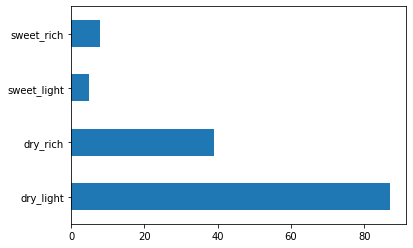

In [85]:
print('koshu categories')
df_sake[(df_sake['is_koshu'] == 1) & (~df_sake['flavor_category'].isnull())][['dry_light', 'dry_rich', 'sweet_light', 'sweet_rich']].sum().plot(kind='barh');

#### Amakarado

In [86]:
smv = -12
acidity = 2.5
(193593 / (1443 + smv)) - (1.16 * acidity) - 132.57

-0.18488469601678048

In [380]:
smv = -12
acid_1 = 1.65
acid_2 = acid_1 + 0.5
(193593 / (1443 + smv)) - (1.16 * acid_1) - 132.57

0.8011153039832379

In [381]:
(193593 / (1443 + smv)) - (1.16 * acid_2) - 132.57

0.22111530398322543

#### exporting csvs

In [ ]:
df_flavor.to_csv('../data/df_flavor.csv')
df_flavor_area.to_csv('../data/df_flavor_area.csv')

In [ ]:
test_df = pd.read_csv('../data/df_flavor_area.csv', index_col='region')
test_df.head(3)

In [ ]:
df_sake.to_csv('../data/sake_list_final.csv')

In [ ]:
test_df = pd.read_csv('../data/sake_list_final.csv', index_col='id')
test_df.head(3)

## quick stats!

- box plots for rice polishing rate, abv, acidity, gravity
- most popular rice type, yeast type, sake type
- count # of futsushu vs special designation, junmai vs non_junmai, dai vs. rest of special designation

### box plots for rice polishing rate, abv, acidity, gravity

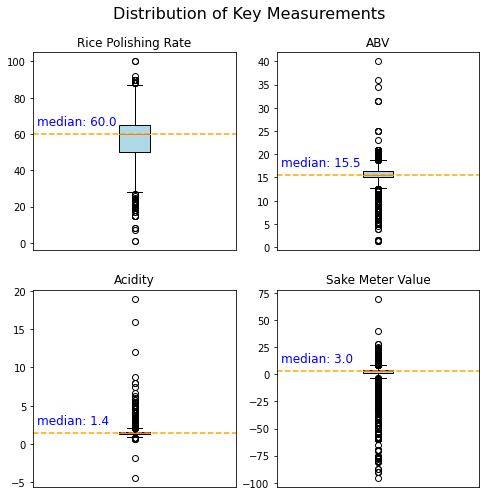

In [307]:
def make_key_measurement_boxplots():
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.suptitle("Distribution of Key Measurements", fontsize=16, y=.96)
    columns = {'rice_polishing_rate': 'Rice Polishing Rate', 
             'abv_avg': 'ABV',
             'acidity_avg': 'Acidity',
             'gravity_avg': 'Sake Meter Value'}

    for col, ax in zip(columns.items(), axs.ravel()):
        column = col[0]
        title = col[1]
        median = df_sake[column].median()
        mx = df_sake[column].max()
        mn = df_sake[column].min()

        bplot = ax.boxplot(df_sake[column].dropna(), patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
        ax.set_title(title)
        ax.axhline(median, color='orange', linestyle='--')
        ax.set_xticks([])
        ax.text(0.52, median + ((mx - mn) * .05), f'median: {median}', fontsize=12, color='blue')
        
make_key_measurement_boxplots()

### bar plots 

#### rice types

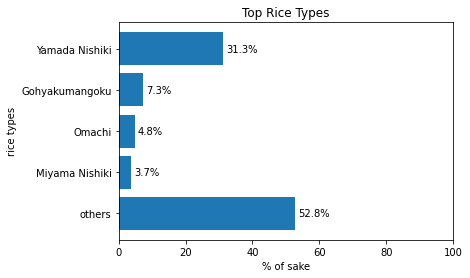

In [88]:
def make_plotdf_top_rice():
    # make dataframe of top 4 rice types as % + all other rice types put together
    total_rice_type = df_sake['rice_type'].value_counts().sum()
    top_rice_types = df_sake['rice_type'].value_counts().head(4) 
    other_rice_types = total_rice_type - top_rice_types.sum()
    dict_top_rice = dict(round(top_rice_types / total_rice_type * 100, 1))
    dict_top_rice['others'] = round(other_rice_types / total_rice_type * 100, 1)
    plotdf_top_rice = pd.DataFrame.from_dict(dict_top_rice, orient='index').rename(columns={0: '% of sake'}).reset_index()
    
    # translate sake names to English
    top4_rice = {
                '山田錦': 'Yamada Nishiki',
                '五百万石': 'Gohyakumangoku',
                '雄町': 'Omachi',
                '美山錦': 'Miyama Nishiki',
            }
    plotdf_top_rice['index'] = plotdf_top_rice['index'].replace(top4_rice)
    
    # reverse order and reset index
    return plotdf_top_rice.reindex(index=plotdf_top_rice.index[::-1]).set_index('index')
    
def make_top_rice_plot():
    plotdf_top_rice = make_plotdf_top_rice()

    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.barh(
        plotdf_top_rice.index,
        plotdf_top_rice["% of sake"]
    )
    ax.bar_label(bars, fmt="%.1f%%", padding=3)
    ax.set_xlim(0, 100)
    ax.set_title('Top Rice Types')
    ax.set_xlabel('% of sake')
    ax.set_ylabel('rice types')
    
make_top_rice_plot()

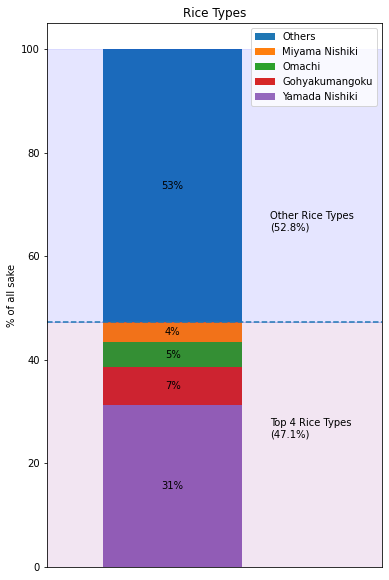

In [89]:
# stacked bar plot
def make_top_rice_stacked_plot():
    # make df
    plotdf_top_rice = make_plotdf_top_rice()
    
    # set up plot
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.set_xlim(-0.09, 0.15)
    ax.set_xticks([])

    # make bar chunks
    o = plotdf_top_rice.loc['others', '% of sake']
    mn = plotdf_top_rice.loc['Miyama Nishiki', '% of sake']
    om = plotdf_top_rice.loc['Omachi', '% of sake']
    go = plotdf_top_rice.loc['Gohyakumangoku', '% of sake']
    yn = plotdf_top_rice.loc['Yamada Nishiki', '% of sake']

    width=0.1
    p5 = ax.bar(0, o, width, bottom=100 - o, label='Others')
    p4 = ax.bar(0, mn, width, bottom=100 - o - mn, label='Miyama Nishiki')
    p3 = ax.bar(0, om, width, bottom=yn + go, label='Omachi')
    p2 = ax.bar(0, go, width, bottom=yn, label='Gohyakumangoku')
    p1 = ax.bar(0, yn, width, label='Yamada Nishiki')

    # plotting chunks
    rice_bar_chunks = [p1, p2, p3, p4, p5]

    for chunk in rice_bar_chunks:
        ax.bar_label(chunk, label_type='center', fmt="%.0f%%")

    ax.legend()

    # add labels
    ax.set_title('Rice Types')
    ax.set_ylabel("% of all sake")

    # adding background fill
    ax.axhline(y=100-o, linestyle='--')

    ax.fill_between([-1, 1], 0, 100 - o, alpha=0.1, color='purple')
    ax.fill_between([-1, 1], 100 - o, 100, alpha=0.1, color='blue')

    # add text
    text_x = .07
    ax.text(text_x, 25, f"Top 4 Rice Types \n({round(yn + go + om + mn, 1)}%)")
    ax.text(text_x, 65, f"Other Rice Types \n({round(o, 1)}%)")
    
make_top_rice_stacked_plot()

#### Yeast Types

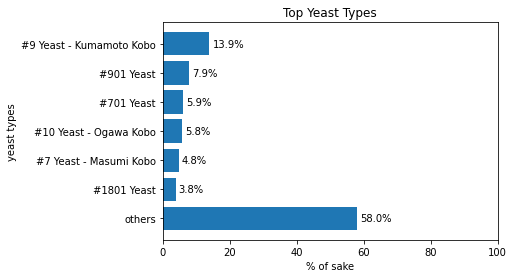

In [91]:
def make_plotdf_top_yeast():
    total_yeast_type = df_sake['yeast'].value_counts().sum()
    top_yeast_types = df_sake['yeast'].value_counts().head(6) 
    other_yeast_types = total_yeast_type - top_yeast_types.sum()
    dict_top_yeast = dict(round(top_yeast_types / total_yeast_type * 100, 1))
    dict_top_yeast['others'] = round(other_yeast_types / total_yeast_type * 100, 1)
    plotdf_top_yeast = pd.DataFrame.from_dict(dict_top_yeast, orient='index').rename(columns={0: '% of sake'}).reset_index()
    plotdf_top_yeast = plotdf_top_yeast.reindex(index=plotdf_top_yeast.index[::-1]).set_index('index')

    dict_top_yeasts = {
        "協会9号(熊本酵母・香露酵母)": "#9 Yeast - Kumamoto Kobo",
        "協会901号": "#901 Yeast",
        "協会701号": "#701 Yeast",
        "協会10号(明利小川酵母)": "#10 Yeast - Ogawa Kobo",
        "協会7号(真澄酵母)": "#7 Yeast - Masumi Kobo",
        "協会1801号": "#1801 Yeast"   
    }
    
    return plotdf_top_yeast.rename(index=dict_top_yeasts)
    
def make_top_yeast_plot():
    plotdf_top_yeast = make_plotdf_top_yeast()
    
    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.barh(
        plotdf_top_yeast.index,
        plotdf_top_yeast["% of sake"]
    )
    ax.bar_label(bars, fmt="%.1f%%", padding=3)
    ax.set_xlim(0, 100)
    ax.set_title('Top Yeast Types')
    ax.set_xlabel('% of sake')
    ax.set_ylabel('yeast types')

make_top_yeast_plot()

<AxesSubplot:title={'center':'Yeast Types'}, ylabel='% of all sake'>

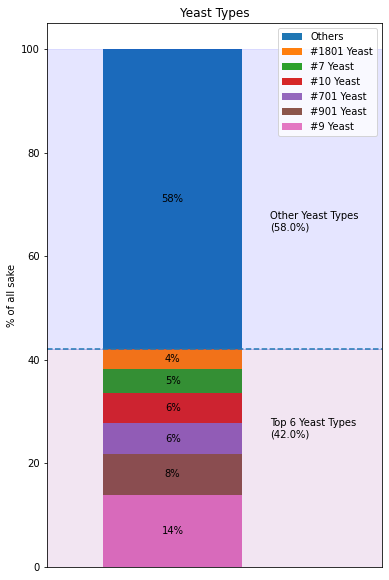

In [235]:
def make_top_yeast_plot_stacked():
    # make df
    plotdf_top_yeast = make_plotdf_top_yeast()

    # set up plot
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.set_xlim(-0.09, 0.15)
    ax.set_xticks([])

    # make bar chunks
    o = plotdf_top_yeast.loc['others', '% of sake']
    _18 = plotdf_top_yeast.loc['#1801 Yeast', '% of sake']
    _7 = plotdf_top_yeast.loc['#7 Yeast - Masumi Kobo', '% of sake']
    _10 = plotdf_top_yeast.loc['#10 Yeast - Ogawa Kobo', '% of sake']
    _701 = plotdf_top_yeast.loc['#701 Yeast', '% of sake']
    _901 = plotdf_top_yeast.loc['#901 Yeast', '% of sake']
    _9 = plotdf_top_yeast.loc['#9 Yeast - Kumamoto Kobo', '% of sake']

    width=0.1
    p7 = ax.bar(0, o, width, bottom=100 - o, label='Others')
    p6 = ax.bar(0, _18, width, bottom=100 - o - _18, label='#1801 Yeast')
    p5 = ax.bar(0, _7, width, bottom=100 - o - _18 - _7, label='#7 Yeast')
    p4 = ax.bar(0, _10, width, bottom=_9 + _901 + _701, label='#10 Yeast')
    p3 = ax.bar(0, _701, width, bottom=_9 + _901, label='#701 Yeast')
    p2 = ax.bar(0, _901, width, bottom=_9, label='#901 Yeast')
    p1 = ax.bar(0, _9, width, label='#9 Yeast')

    # plotting chunks
    yeast_bar_chunks = [p1, p2, p3, p4, p5, p6, p7]

    for chunk in yeast_bar_chunks:
        ax.bar_label(chunk, label_type='center', fmt="%.0f%%")

    ax.legend()

    # add labels
    ax.set_title('Yeast Types')
    ax.set_ylabel("% of all sake")

    # adding background fill
    ax.axhline(y=100-o, linestyle='--')

    ax.fill_between([-1, 1], 0, 100 - o, alpha=0.1, color='purple')
    ax.fill_between([-1, 1], 100 - o, 100, alpha=0.1, color='blue')

    # add text
    text_x = .07
    ax.text(text_x, 25, f"Top 6 Yeast Types \n({round(100 - o, 1)}%)")
    ax.text(text_x, 65, f"Other Yeast Types \n({round(o, 1)}%)")
    
make_top_yeast_plot_stacked()

#### yeast and rice types in one figure

In [ ]:
def make_top_rice_stacked_plot():
    # make df
    plotdf_top_rice = make_plotdf_top_rice()
    
    # set up plot
    fig, ax = plt.subplots(figsize=(6, 10))
    

    # make bar chunks
    o = plotdf_top_rice.loc['others', '% of sake']
    mn = plotdf_top_rice.loc['Miyama Nishiki', '% of sake']
    om = plotdf_top_rice.loc['Omachi', '% of sake']
    go = plotdf_top_rice.loc['Gohyakumangoku', '% of sake']
    yn = plotdf_top_rice.loc['Yamada Nishiki', '% of sake']

    width=0.1
    p5 = ax.bar(0, o, width, bottom=100 - o, label='Others')
    p4 = ax.bar(0, mn, width, bottom=100 - o - mn, label='Miyama Nishiki')
    p3 = ax.bar(0, om, width, bottom=yn + go, label='Omachi')
    p2 = ax.bar(0, go, width, bottom=yn, label='Gohyakumangoku')
    p1 = ax.bar(0, yn, width, label='Yamada Nishiki')

    # plotting chunks
    rice_bar_chunks = [p1, p2, p3, p4, p5]

    for chunk in rice_bar_chunks:
        ax.bar_label(chunk, label_type='center', fmt="%.0f%%")

    ax.legend()

    # add labels
    ax.set_title('Rice Types')
    ax.set_ylabel("% of all sake")

    # adding background fill
    ax.axhline(y=100-o, linestyle='--')

    ax.fill_between([-1, 1], 0, 100 - o, alpha=0.1, color='purple')
    ax.fill_between([-1, 1], 100 - o, 100, alpha=0.1, color='blue')

    # add text
    text_x = .07
    ax.text(text_x, 25, f"Top 4 Rice Types \n({round(yn + go + om + mn, 1)}%)")
    ax.text(text_x, 65, f"Other Rice Types \n({round(o, 1)}%)")

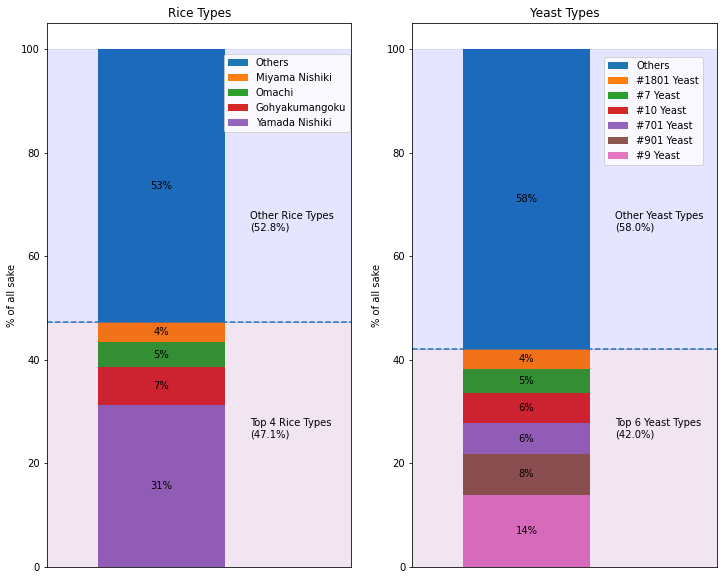

In [270]:
def make_top_yeast_rice_plot_stacked():
    # make yeast and rice df
    plotdf_top_yeast = make_plotdf_top_yeast()
    plotdf_top_rice = make_plotdf_top_rice()
        
    # set up plot - ax[0]=rice, ax[1]=yeast
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))
    axs[0].set_xlim(-0.09, 0.15)
    axs[0].set_xticks([])
    
    axs[1].set_xlim(-0.09, 0.15)
    axs[1].set_xticks([])

    
    ## make rice plot
    # make bar chunks
    ro = plotdf_top_rice.loc['others', '% of sake']
    mn = plotdf_top_rice.loc['Miyama Nishiki', '% of sake']
    om = plotdf_top_rice.loc['Omachi', '% of sake']
    go = plotdf_top_rice.loc['Gohyakumangoku', '% of sake']
    yn = plotdf_top_rice.loc['Yamada Nishiki', '% of sake']

    width=0.1
    rp5 = axs[0].bar(0, ro, width, bottom=100 - ro, label='Others')
    rp4 = axs[0].bar(0, mn, width, bottom=100 - ro - mn, label='Miyama Nishiki')
    rp3 = axs[0].bar(0, om, width, bottom=yn + go, label='Omachi')
    rp2 = axs[0].bar(0, go, width, bottom=yn, label='Gohyakumangoku')
    rp1 = axs[0].bar(0, yn, width, label='Yamada Nishiki')

    # plotting chunks
    rice_bar_chunks = [rp1, rp2, rp3, rp4, rp5]

    for chunk in rice_bar_chunks:
        axs[0].bar_label(chunk, label_type='center', fmt="%.0f%%")

    axs[0].legend(loc=(0.58, 0.8))

    # add labels
    axs[0].set_title('Rice Types')
    axs[0].set_ylabel("% of all sake")

    # adding background fill
    axs[0].axhline(y=100-ro, linestyle='--')

    axs[0].fill_between([-1, 1], 0, 100 - ro, alpha=0.1, color='purple')
    axs[0].fill_between([-1, 1], 100 - ro, 100, alpha=0.1, color='blue')

    # add text
    text_x = .07
    axs[0].text(text_x, 25, f"Top 4 Rice Types \n({round(yn + go + om + mn, 1)}%)")
    axs[0].text(text_x, 65, f"Other Rice Types \n({round(ro, 1)}%)")
    
    
    ## make yeast plot
    # make bar chunks
    yo = plotdf_top_yeast.loc['others', '% of sake']
    _18 = plotdf_top_yeast.loc['#1801 Yeast', '% of sake']
    _7 = plotdf_top_yeast.loc['#7 Yeast - Masumi Kobo', '% of sake']
    _10 = plotdf_top_yeast.loc['#10 Yeast - Ogawa Kobo', '% of sake']
    _701 = plotdf_top_yeast.loc['#701 Yeast', '% of sake']
    _901 = plotdf_top_yeast.loc['#901 Yeast', '% of sake']
    _9 = plotdf_top_yeast.loc['#9 Yeast - Kumamoto Kobo', '% of sake']

    width=0.1
    yp7 = axs[1].bar(0, yo, width, bottom=100 - yo, label='Others')
    yp6 = axs[1].bar(0, _18, width, bottom=100 - yo - _18, label='#1801 Yeast')
    yp5 = axs[1].bar(0, _7, width, bottom=100 - yo - _18 - _7, label='#7 Yeast')
    yp4 = axs[1].bar(0, _10, width, bottom=_9 + _901 + _701, label='#10 Yeast')
    yp3 = axs[1].bar(0, _701, width, bottom=_9 + _901, label='#701 Yeast')
    yp2 = axs[1].bar(0, _901, width, bottom=_9, label='#901 Yeast')
    yp1 = axs[1].bar(0, _9, width, label='#9 Yeast')

    # plotting chunks
    yeast_bar_chunks = [yp1, yp2, yp3, yp4, yp5, yp6, yp7]

    for chunk in yeast_bar_chunks:
        axs[1].bar_label(chunk, label_type='center', fmt="%.0f%%")

    axs[1].legend(loc=(0.63, 0.74))

    # add labels
    axs[1].set_title('Yeast Types')
    axs[1].set_ylabel("% of all sake")

    # adding background fill
    axs[1].axhline(y=100-yo, linestyle='--')

    axs[1].fill_between([-1, 1], 0, 100 - yo, alpha=0.1, color='purple')
    axs[1].fill_between([-1, 1], 100 - yo, 100, alpha=0.1, color='blue')

    # add text
    text_x = .07
    axs[1].text(text_x, 25, f"Top 6 Yeast Types \n({round(100 - yo, 1)}%)")
    axs[1].text(text_x, 65, f"Other Yeast Types \n({round(yo, 1)}%)")
    
    plt.show()
    
make_top_yeast_rice_plot_stacked()


#### Sake Grades

**(old) sake grades**

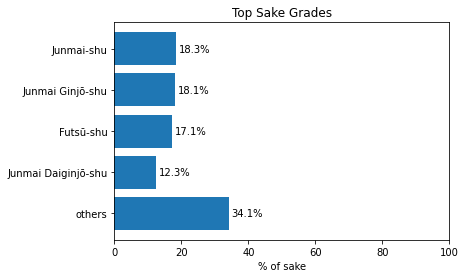

In [93]:
def make_plotdf_sake_grades():
    total_sake_type = df_sake['sake_type_eng'].value_counts().sum()
    top_sake_types = df_sake['sake_type_eng'].value_counts().head(4) 
    other_sake_types = total_sake_type - top_sake_types.sum()
    dict_top_sake = dict(round(top_sake_types / total_sake_type * 100, 1))
    dict_top_sake['others'] = round(other_sake_types / total_sake_type * 100, 1)
    plotdf_top_sake = pd.DataFrame.from_dict(dict_top_sake, orient='index').rename(columns={0: '% of sake'}).reset_index()
    return plotdf_top_sake.reindex(index=plotdf_top_sake.index[::-1]).set_index('index')

def make_sake_grades_plot():
    plotdf_top_sake = make_plotdf_sake_grades()
    
    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.barh(
        plotdf_top_sake.index,
        plotdf_top_sake["% of sake"]
    )
    ax.bar_label(bars, fmt="%.1f%%", padding=3)
    ax.set_xlim(0, 100)
    ax.set_title('Top Sake Grades')
    ax.set_xlabel('% of sake')
    ax.set_ylabel('')
    
make_sake_grades_plot()

**futsushu vs other**

In [ ]:
sd_counts

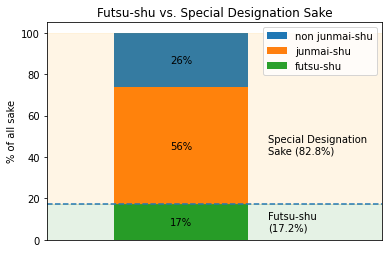

In [234]:
def make_futsu_plot_stacked():
    num_futsu = df_sake.is_futsu.sum()
    num_junmai = df_sake.is_junmai.sum()
    num_non_junmai = df_sake.is_non_junmai.sum()
    ast = num_futsu + num_junmai + num_non_junmai

    df_futsu_count = pd.DataFrame(
        {'futsu-shu': num_futsu / ast * 100,
        'junmai-shu': num_junmai / ast * 100, 
        'non junmai-shu': num_non_junmai / ast * 100},
        index = ['% of sake']
    )

    width = 0.1

    fig, ax = plt.subplots()
    ax.set_xlim(-0.1, 0.15)

    p3 = ax.bar(0, df_futsu_count['non junmai-shu'], width, bottom=df_futsu_count['futsu-shu'] + df_futsu_count['junmai-shu'], label='non junmai-shu')
    p2 = ax.bar(0, df_futsu_count['junmai-shu'], width, bottom=df_futsu_count['futsu-shu'], label='junmai-shu')
    p1 = ax.bar(0, df_futsu_count['futsu-shu'], width, label='futsu-shu')

    # splitting between futsu-shu and special designation sake
    hline = df_futsu_count['futsu-shu'].sum()
    sds = df_futsu_count['junmai-shu'].sum() + df_futsu_count['non junmai-shu'].sum()
    ax.axhline(y = hline, linestyle='--')
    ax.text(0.065, sds / 2, s=f"Special Designation \nSake ({round(sds, 1)}%)")
    ax.text(0.065, hline - 13, s=f"Futsu-shu \n({round(hline, 1)}%)")
    ax.fill_between([-1, 1], 0, hline, alpha=0.1, color='g')
    ax.fill_between([-1, 1], hline, 100, alpha=0.1, color='orange')

    # add text
    ax.set_title("Futsu-shu vs. Special Designation Sake")
    ax.set_xticks([])
    ax.set_ylabel("% of all sake")

    ax.legend()

    # add labels
    ax.bar_label(p1, label_type='center', fmt="%.0f%%")
    ax.bar_label(p2, label_type='center', fmt="%.0f%%")
    ax.bar_label(p3, label_type='center', fmt="%.0f%%")


make_futsu_plot_stacked()

In [95]:
# shows which rows are missing from plot above out of whole dataset
df_sake[(df_sake['is_futsu'] == 0) & (df_sake['is_junmai'] == 0) & (df_sake['is_non_junmai'] == 0)].shape

(82, 53)

**dai vs. non dai special designation sake**

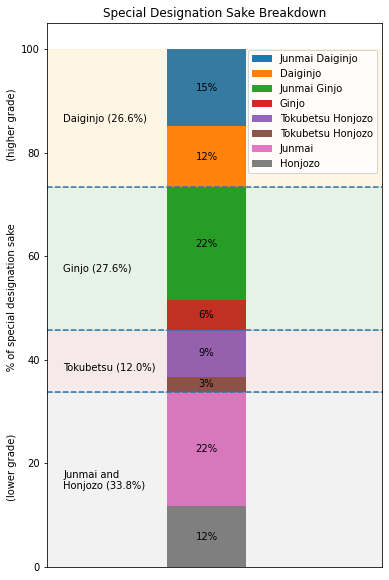

In [274]:
def make_sd_breakdown_plot_stacked():
    num_dai = df_sake.is_dai.sum()
    num_sd = df_sake.is_special_designation.sum()
    num_non_dai = num_sd - num_dai

    sd_counts = df_sake.sake_type_eng.value_counts().drop(['Futsū-shu', 'Kijō-shu'])
    sd_counts['Junmai-shu'] = sd_counts['Junmai-shu'] + 4
    sd_counts['Honjōzō-shu'] = sd_counts['Honjōzō-shu'] + 1
    sd_counts = sd_counts.drop(['Junmai-kei', 'Honjōzō-kei'])
    sd_counts = pd.DataFrame(sd_counts / num_sd * 100).T

    fig, ax = plt.subplots(figsize=(6, 10))
    ax.set_xlim(-0.2, 0.22)
    ax.set_xticks([])

    # making bar chunks for stacked bar plot
    width=0.1
    dai_count = sd_counts[['Junmai Daiginjō-shu', 'Daiginjō-shu']].sum(axis=1).sum()
    ginjo_count = sd_counts[['Junmai Ginjō-shu', 'Ginjō-shu']].sum(axis=1).sum()
    toku_count = sd_counts[['Tokubetsu Junmai-shu', 'Tokubetsu Honjōzō-shu']].sum(axis=1).sum()
    junhon_count = sd_counts[['Junmai-shu', 'Honjōzō-shu']].sum(axis=1).sum()

    p8 = ax.bar(0, sd_counts['Junmai Daiginjō-shu'], width, bottom=100 - sd_counts['Junmai Daiginjō-shu'].sum(), label='Junmai Daiginjo')
    p7 = ax.bar(0, sd_counts['Daiginjō-shu'], width, bottom=100 - dai_count, label='Daiginjo')
    p6 = ax.bar(0, sd_counts['Junmai Ginjō-shu'], width, bottom=100 - dai_count - sd_counts['Junmai Ginjō-shu'].sum(), label='Junmai Ginjo')
    p5 = ax.bar(0, sd_counts['Ginjō-shu'], width, bottom=100 - dai_count - ginjo_count, label='Ginjo')
    p4 = ax.bar(0, sd_counts['Tokubetsu Junmai-shu'], width, bottom=junhon_count + sd_counts['Tokubetsu Honjōzō-shu'].sum(), label='Tokubetsu Honjozo')
    p3 = ax.bar(0, sd_counts['Tokubetsu Honjōzō-shu'], width, bottom=junhon_count, label='Tokubetsu Honjozo')
    p2 = ax.bar(0, sd_counts['Junmai-shu'], width, bottom=sd_counts['Honjōzō-shu'].sum(), label='Junmai')
    p1 = ax.bar(0, sd_counts['Honjōzō-shu'], width, label='Honjozo')

    # plotting chunks + adding chunk labels
    sd_bar_chunks = [p1, p2, p3, p4, p5, p6, p7, p8]

    for chunk in sd_bar_chunks:
        ax.bar_label(chunk, label_type='center', fmt="%.0f%%")

    ax.legend(loc=(0.6, 0.725))

    # add labels
    ax.set_title('Special Designation Sake Breakdown')
    ylab_padding = 20
    ax.set_ylabel(f"(lower grade){' '*ylab_padding}% of special designation sake{' '*ylab_padding}(higher grade)")

    # adding background fill
    ax.axhline(y=junhon_count, linestyle='--')
    ax.axhline(y=toku_count + junhon_count, linestyle='--')
    ax.axhline(y=100 - dai_count, linestyle='--')

    ax.fill_between([-1, 1], 0, junhon_count, alpha=0.1, color='gray')
    ax.fill_between([-1, 1], junhon_count, toku_count + junhon_count, alpha=0.1, color='brown')
    ax.fill_between([-1, 1], toku_count + junhon_count, 100 - dai_count, alpha=0.1, color='green')
    ax.fill_between([-1, 1], 100 - dai_count, 100, alpha=0.1, color='orange')

    # add text
    text_x = -0.18
    ax.text(text_x, 15, f"Junmai and \nHonjozo ({round(junhon_count, 1)}%)")
    ax.text(text_x, 38, f"Tokubetsu ({round(toku_count, 1)}%)")
    ax.text(text_x, 57, f"Ginjo ({round(ginjo_count, 1)}%)")
    ax.text(text_x, 86, f"Daiginjo ({round(dai_count, 1)}%)")

make_sd_breakdown_plot_stacked()

#### sake types

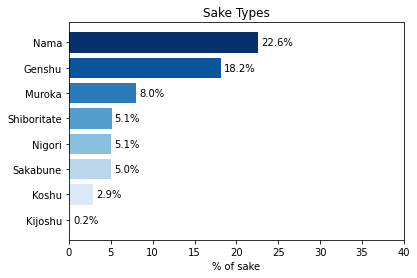

In [277]:
def make_sake_type_plot():
    num_all_sake = df_sake.categories.notna().sum()
    df_pct_sake_types = pd.DataFrame(df_sake[['is_nigori', 'is_genshu', 'is_nama', 'is_kijoshu', 'is_koshu', 'is_muroka', 'is_sakabune', 'is_shiboritate']].sum() / num_all_sake * 100, columns=['% of sake']).sort_values(by='% of sake')
    df_pct_sake_types.index = [name[3:].capitalize() for name in df_pct_sake_types.index]
    df_pct_sake_types

    fig, ax = plt.subplots(figsize=(6, 4))
    
    st_colors = cm.Blues(np.linspace(0,1,len(df_pct_sake_types)))

    bars = ax.barh(
        df_pct_sake_types.index,
        df_pct_sake_types["% of sake"],
        color=st_colors
    )
    ax.bar_label(bars, fmt="%.1f%%", padding=3)
    ax.set_xlim(0, 40)
    ax.set_title('Sake Types')
    ax.set_xlabel('% of sake')
    ax.set_ylabel('')

make_sake_type_plot()

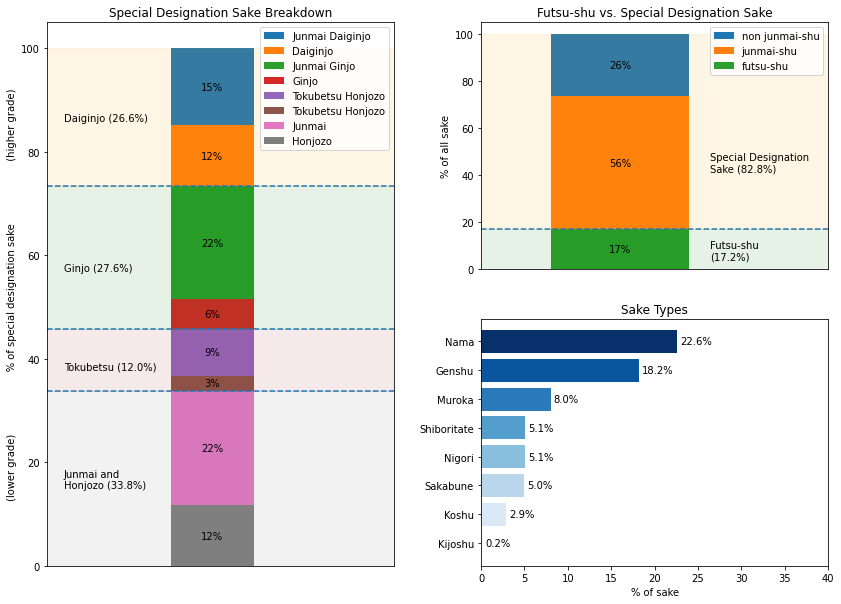

In [289]:
def sake_grades_and_types_plots():
    # setup plots
    plt.figure(figsize=(14, 10))
    ax1 = plt.subplot(1,2,1)  # special designation breakdown
    ax2 = plt.subplot(2,2,2)  # futsu-shu vs. other
    ax3 = plt.subplot(2,2,4)  # sake types
    axes = [ax1, ax2, ax3]
    
    ax1.set_xlim(-0.2, 0.22)
    ax1.set_xticks([])
    ax2.set_xlim(-0.1, 0.15)
    ax2.set_xticks([])
    ax3.set_xlim(0, 40)
    
    plt.subplots_adjust(wspace=0.25)
    
    ## special designation breakdown
    num_dai = df_sake.is_dai.sum()
    num_sd = df_sake.is_special_designation.sum()
    num_non_dai = num_sd - num_dai

    sd_counts = df_sake.sake_type_eng.value_counts().drop(['Futsū-shu', 'Kijō-shu'])
    sd_counts['Junmai-shu'] = sd_counts['Junmai-shu'] + 4
    sd_counts['Honjōzō-shu'] = sd_counts['Honjōzō-shu'] + 1
    sd_counts = sd_counts.drop(['Junmai-kei', 'Honjōzō-kei'])
    sd_counts = pd.DataFrame(sd_counts / num_sd * 100).T

    # making bar chunks for stacked bar plot
    width=0.1
    dai_count = sd_counts[['Junmai Daiginjō-shu', 'Daiginjō-shu']].sum(axis=1).sum()
    ginjo_count = sd_counts[['Junmai Ginjō-shu', 'Ginjō-shu']].sum(axis=1).sum()
    toku_count = sd_counts[['Tokubetsu Junmai-shu', 'Tokubetsu Honjōzō-shu']].sum(axis=1).sum()
    junhon_count = sd_counts[['Junmai-shu', 'Honjōzō-shu']].sum(axis=1).sum()

    p8 = ax1.bar(0, sd_counts['Junmai Daiginjō-shu'], width, bottom=100 - sd_counts['Junmai Daiginjō-shu'].sum(), label='Junmai Daiginjo')
    p7 = ax1.bar(0, sd_counts['Daiginjō-shu'], width, bottom=100 - dai_count, label='Daiginjo')
    p6 = ax1.bar(0, sd_counts['Junmai Ginjō-shu'], width, bottom=100 - dai_count - sd_counts['Junmai Ginjō-shu'].sum(), label='Junmai Ginjo')
    p5 = ax1.bar(0, sd_counts['Ginjō-shu'], width, bottom=100 - dai_count - ginjo_count, label='Ginjo')
    p4 = ax1.bar(0, sd_counts['Tokubetsu Junmai-shu'], width, bottom=junhon_count + sd_counts['Tokubetsu Honjōzō-shu'].sum(), label='Tokubetsu Honjozo')
    p3 = ax1.bar(0, sd_counts['Tokubetsu Honjōzō-shu'], width, bottom=junhon_count, label='Tokubetsu Honjozo')
    p2 = ax1.bar(0, sd_counts['Junmai-shu'], width, bottom=sd_counts['Honjōzō-shu'].sum(), label='Junmai')
    p1 = ax1.bar(0, sd_counts['Honjōzō-shu'], width, label='Honjozo')

    # plotting chunks + adding chunk labels
    sd_bar_chunks = [p1, p2, p3, p4, p5, p6, p7, p8]

    for chunk in sd_bar_chunks:
        ax1.bar_label(chunk, label_type='center', fmt="%.0f%%")

    ax1.legend()

    # add labels
    ax1.set_title('Special Designation Sake Breakdown')
    ylab_padding = 20
    ax1.set_ylabel(f"(lower grade){' '*ylab_padding}% of special designation sake{' '*ylab_padding}(higher grade)")

    # adding background fill
    ax1.axhline(y=junhon_count, linestyle='--')
    ax1.axhline(y=toku_count + junhon_count, linestyle='--')
    ax1.axhline(y=100 - dai_count, linestyle='--')

    ax1.fill_between([-1, 1], 0, junhon_count, alpha=0.1, color='gray')
    ax1.fill_between([-1, 1], junhon_count, toku_count + junhon_count, alpha=0.1, color='brown')
    ax1.fill_between([-1, 1], toku_count + junhon_count, 100 - dai_count, alpha=0.1, color='green')
    ax1.fill_between([-1, 1], 100 - dai_count, 100, alpha=0.1, color='orange')

    # add text
    text_x = -0.18
    ax1.text(text_x, 15, f"Junmai and \nHonjozo ({round(junhon_count, 1)}%)")
    ax1.text(text_x, 38, f"Tokubetsu ({round(toku_count, 1)}%)")
    ax1.text(text_x, 57, f"Ginjo ({round(ginjo_count, 1)}%)")
    ax1.text(text_x, 86, f"Daiginjo ({round(dai_count, 1)}%)")
    
    
    ## futsu-shu vs. other
    num_futsu = df_sake.is_futsu.sum()
    num_junmai = df_sake.is_junmai.sum()
    num_non_junmai = df_sake.is_non_junmai.sum()
    ast = num_futsu + num_junmai + num_non_junmai

    df_futsu_count = pd.DataFrame(
        {'futsu-shu': num_futsu / ast * 100,
        'junmai-shu': num_junmai / ast * 100, 
        'non junmai-shu': num_non_junmai / ast * 100},
        index = ['% of sake']
    )

    width = 0.1
    p3 = ax2.bar(0, df_futsu_count['non junmai-shu'], width, bottom=df_futsu_count['futsu-shu'] + df_futsu_count['junmai-shu'], label='non junmai-shu')
    p2 = ax2.bar(0, df_futsu_count['junmai-shu'], width, bottom=df_futsu_count['futsu-shu'], label='junmai-shu')
    p1 = ax2.bar(0, df_futsu_count['futsu-shu'], width, label='futsu-shu')

    # splitting between futsu-shu and special designation sake
    hline = df_futsu_count['futsu-shu'].sum()
    sds = df_futsu_count['junmai-shu'].sum() + df_futsu_count['non junmai-shu'].sum()
    ax2.axhline(y = hline, linestyle='--')
    ax2.text(0.065, sds / 2, s=f"Special Designation \nSake ({round(sds, 1)}%)")
    ax2.text(0.065, hline - 13, s=f"Futsu-shu \n({round(hline, 1)}%)")
    ax2.fill_between([-1, 1], 0, hline, alpha=0.1, color='g')
    ax2.fill_between([-1, 1], hline, 100, alpha=0.1, color='orange')

    # add text
    ax2.set_title("Futsu-shu vs. Special Designation Sake")
   
    ax2.set_ylabel("% of all sake")

    ax2.legend()

    # add labels
    ax2.bar_label(p1, label_type='center', fmt="%.0f%%")
    ax2.bar_label(p2, label_type='center', fmt="%.0f%%")
    ax2.bar_label(p3, label_type='center', fmt="%.0f%%")
    
    
    ## sake types
    num_all_sake = df_sake.categories.notna().sum()
    df_pct_sake_types = pd.DataFrame(df_sake[['is_nigori', 'is_genshu', 'is_nama', 'is_kijoshu', 'is_koshu', 'is_muroka', 'is_sakabune', 'is_shiboritate']].sum() / num_all_sake * 100, columns=['% of sake']).sort_values(by='% of sake')
    df_pct_sake_types.index = [name[3:].capitalize() for name in df_pct_sake_types.index]

    st_colors = cm.Blues(np.linspace(0,1,len(df_pct_sake_types)))

    bars = ax3.barh(
        df_pct_sake_types.index,
        df_pct_sake_types["% of sake"],
        color=st_colors
    )
    ax3.bar_label(bars, fmt="%.1f%%", padding=3)
    ax3.set_title('Sake Types')
    ax3.set_xlabel('% of sake')
    ax3.set_ylabel('')
    
sake_grades_and_types_plots()

### the extremes

In [ ]:
df_sake.columns

In [ ]:
# highest rice polishing rate
df_sake[df_sake['rice_polishing_rate'] == df_sake['rice_polishing_rate'].min()]

#### radar chart (difficult - from [mat docs](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html) - not sure how to set the xlim / ylim)

In [ ]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
df_radar_norm.loc[8314, 'name_romaji']

In [ ]:
df_radar = df_sake[['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']]
df_radar_norm = ((df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())).join(df_sake[['name_romaji', 'company']])

In [ ]:
df_radar_norm[df_radar_norm.company.str.contains('朝日')]

In [ ]:
df_radar_norm[df_radar_norm['rice_polishing_rate'] == df_radar_norm['rice_polishing_rate'].min()]
low_rpr = [
    ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg'],
    (df_radar_norm.loc[8314, 'name_romaji'],
        df_radar_norm.loc[8314, ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']].to_list()
    )
]
#     df_radar_norm.loc[8314, 'name_romaji'], (df_radar_norm.loc[8314, ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']])]
low_rpr[1][1]

In [ ]:
def get_single_sake_data(id):
    labels = ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']
    name = df_radar_norm.loc[id, 'name_romaji']
    data = df_radar_norm.loc[id, labels].to_list()
    
    return ['rice polishing rate', 'ABV', 'Sake Meter Value', 'Acidity'], name, data

In [ ]:
N = 4
theta = radar_factory(N, frame='polygon')

labels, name, data = get_single_sake_data(5)

# data = low_rpr[1]
# spoke_labels = low_rpr[0]

fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
# fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

axs.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs.set_title(name, weight='bold', size='medium', position=(0.5, 1.1),
            horizontalalignment='center', verticalalignment='center')
axs.plot(theta, data)
axs.fill(theta, data, facecolor='g', alpha=0.25, label='_nolegend_')
axs.set_varlabels(labels)


# colors = ['b', 'r', 'g', 'm', 'y']
# # Plot the four cases from the example data on separate axes
# for ax, (title, case_data) in zip(axs.flat, data):
#     ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
#     ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
#     for d, color in zip(case_data, colors):
#         ax.plot(theta, d, color=color)
#         ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
#     ax.set_varlabels(spoke_labels)

# # add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

# fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

# plt.show()


#### radar chart (simpler - from [tds](https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca))

IDs of popular sake with all 4 measurements
- 5 = Kubota Manju, from Asahi Shuzo (朝日 from Niigata, not 旭 that does Dassai)
- 11218 = ShouchikubaiShirakabegura Junmaidaiginjou, from Takara Shuzou 宝酒造
- 10102 = Junmaidaiginjo, from Nihon Sakari 日本盛
- 9647 = Hakutsuru Daiginjo, from Hakutsuru 白鶴

In [227]:
def get_amakarado(smv, acidity):
    return (193593 / (1443 + smv)) - (1.16 * acidity) - 132.57

def make_plotdf_radar():
    df_radar = df_sake.loc[:, ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']]
    df_radar['amakarado'] = df_radar.apply(lambda x: get_amakarado(x.gravity_avg, x.acidity_avg), axis=1)
    
    # normalize all data between 0 and 1 
#     df_radar_norm = ((df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())).join(df_sake[['region']])
    df_radar_norm = ((df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())).join(df_sake[['is_nama', 'is_genshu', 'is_nigori']])
    
    # maybe try other types of normalization?
    # df_radar_norm = ((df_radar-df_radar.mean())/df_radar.std()).join(df_sake[['name_romaji', 'company']])
    
#     area_dict = {"Kyūshū": "West", "Chūgoku": "West", "Shikoku": "West Central", "Kansai": "West Central",
#                  "Chūbu": "Central", "Kantō": "Central", "Tōhoku": "North", "Hokkaidō": "North"}
#     df_radar_norm['area'] = df_radar_norm['region'].map(area_dict)
    
#     df_median_measurements_by_area = df_radar_norm.groupby("area").agg(
#         rice_polishing_rate = ('rice_polishing_rate', 'median'),
#         ABV = ('abv_avg', 'median'),
#         acidity = ('acidity_avg', 'median'),
#         amakarado = ('amakarado', 'median'),
#         sake_meter_value = ('gravity_avg', 'median')
#     )
    
#     df_mean_measurements_by_area = df_radar_norm.groupby("area").agg(
#         rice_polishing_rate = ('rice_polishing_rate', 'mean'),
#         ABV = ('abv_avg', 'mean'),
#         acidity = ('acidity_avg', 'mean'),
#         amakarado = ('amakarado', 'mean'),
#         sake_meter_value = ('gravity_avg', 'mean')
#     )
    
#     df_median_measurements_by_sake_grade = df_radar_norm.groupby("sake_type_eng").agg(
#         rice_polishing_rate = ('rice_polishing_rate', 'median'),
#         ABV = ('abv_avg', 'median'),
#         acidity = ('acidity_avg', 'median'),
#         amakarado = ('amakarado', 'median'),
#         sake_meter_value = ('gravity_avg', 'median')
#     )

    df_median_measurements_by_sake_type = df_radar_norm.groupby(['is_nama', 'is_genshu', 'is_nigori']).agg(
        SMV = ('gravity_avg', 'median'),
        rice_polishing_rate = ('rice_polishing_rate', 'median'),
        ABV = ('abv_avg', 'median'),
        acidity = ('acidity_avg', 'median'),
        amakarado = ('amakarado', 'median'),
    )
    
    df_median_measurements_by_sake_type = df_median_measurements_by_sake_type.iloc[np.r_[1:3, 4]].reset_index(
        drop=True).rename(
        index={0: 'Nigori', 1: 'Genshu', 2: 'Nama'}
    )
    
#     return df_radar_norm, df_median_measurements_by_sake_type
    return df_median_measurements_by_sake_type

df_median_measurements_by_sake_type = make_plotdf_radar()
df_median_measurements_by_sake_type
    

# def get_single_sake_data(id):
#     labels = ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']
#     name = df_radar_norm.loc[id, 'name_romaji']
#     data = df_radar_norm.loc[id, labels].to_list()

#     return ['rice polishing rate', 'ABV', 'Sake Meter Value', 'Acidity'], name, data

# cats, name, data = get_single_sake_data(5)

,SMV,rice_polishing_rate,ABV,acidity,amakarado
Nigori,0.518072,0.646465,0.354005,0.259574,0.587451
Genshu,0.596386,0.585859,0.418605,0.255319,0.557380
Nama,0.596386,0.595960,0.366925,0.255319,0.559277


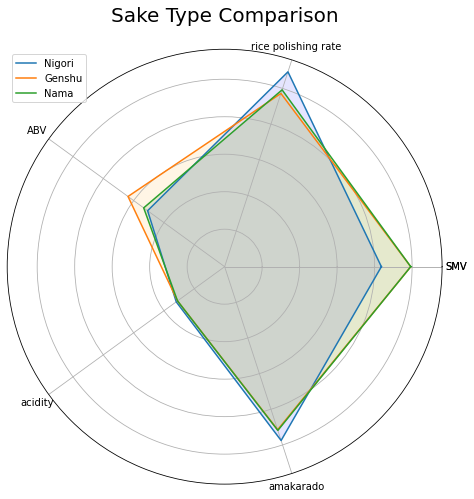

In [228]:
def make_sake_type_radar():
    # import and prepare data
    df_median_measurements_by_sake_type = make_plotdf_radar()

    categories = [cat.replace("_", " ") for cat in df_median_measurements_by_sake_type.columns]
    categories = [*categories, categories[0]]

    nigori = df_median_measurements_by_sake_type.loc['Nigori'].to_list()
    genshu = df_median_measurements_by_sake_type.loc['Genshu'].to_list()
    nama = df_median_measurements_by_sake_type.loc['Nama'].to_list()
    nigori = [*nigori, nigori[0]]
    genshu = [*genshu, genshu[0]]
    nama = [*nama, nama[0]]

    # prepare plot
    label_loc = np.linspace(start=0, stop=2 * np.pi, num = len(nigori))
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    ax.set_ylim(0.1, 0.68)
    
    # plot radar
    ax.plot(label_loc, nigori, label='Nigori')
    ax.plot(label_loc, genshu, label='Genshu')
    ax.plot(label_loc, nama, label='Nama')

    # add fill color
    ax.fill(label_loc, nigori, facecolor='b', alpha=0.1, label='_nolegend_')
    ax.fill(label_loc, genshu, facecolor='orange', alpha=0.1, label='_nolegend_')
    ax.fill(label_loc, nama, facecolor='g', alpha=0.1, label='_nolegend_')
    
    # remove tick labels
    ax.set_yticklabels([])
    
    # add text
    plt.title('Sake Type Comparison', size=20, y=1.05)
    plt.legend()
    plt.show()
    
make_sake_type_radar()

#### (OLD) Radar Chart for one sake

In [ ]:
def get_single_sake_data(id):
    labels = ['rice_polishing_rate', 'abv_avg', 'gravity_avg', 'acidity_avg']
    name = df_radar_norm.loc[id, 'name_romaji']
    data = df_radar_norm.loc[id, labels].to_list()

    return ['rice polishing rate', 'ABV', 'Sake Meter Value', 'Acidity'], name, data

cats, name, data = get_single_sake_data(5)

categories = [*cats, cats[0]]
kubota_data = [*data, data[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(kubota_data))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
# plt.subplot(polar=True)
ax.plot(label_loc, kubota_data, label=name)
plt.title(name, size=20, y=1.05)
ax.fill(label_loc, kubota_data, facecolor='b', alpha=0.25, label='_nolegend_')
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
ax.set_rmax(1.0)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)

In [ ]:
categories = ['Food Quality', 'Food Variety', 'Service Quality', 'Ambiance', 'Affordability']
categories = [*categories, categories[0]]

restaurant_1 = [4, 4, 5, 4, 3]
restaurant_2 = [5, 5, 4, 5, 2]
restaurant_3 = [3, 4, 5, 3, 5]
restaurant_1 = [*restaurant_1, restaurant_1[0]]
restaurant_2 = [*restaurant_2, restaurant_2[0]]
restaurant_3 = [*restaurant_3, restaurant_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(restaurant_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, restaurant_1, label='Restaurant 1')
plt.plot(label_loc, restaurant_2, label='Restaurant 2')
plt.plot(label_loc, restaurant_3, label='Restaurant 3')
plt.title('Restaurant comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

## Rice stuff

### top rice origin df and plot

In [ ]:
def make_top_rice_type_df(df_sake):
    rice_type_eng_dict = {
        '山田錦': 'Yamada Nishiki',
        '五百万石': 'Gohyakumangoku',
        '雄町': 'Omachi',
        '美山錦': 'Miyama Nishiki',
        'ひだほまれ': 'Hidahomare',
        '日本晴': 'Nihonbare',
        'レイホウ': 'Reihou',
        'アケボノ': 'Akebono',
        '八反錦': 'Hattan Nishiki',
        '山田錦 / 五百万石': 'Yamada Nishiki / Gohyakumangoku',
        '松山三井': 'Matsuyama Mitsui',
        '出羽燦々': 'Dewasansan',
        '秋田酒こまち': 'Akita Sake Komachi',
        '玉栄': 'Tamazakae',
        '吟風': 'Ginpu',
        '夢一献': 'Yumeikkon'
    }
    
    origin_to_pref = {
        '愛知県総合農業試験場': '愛知県',
        '山形県農業試験場': '山形県',
        '福岡県農業総合試験場': '福岡県',
        '宮崎県総合農業試験場': '宮崎県',
        '佐賀県農業試験研究センター': '佐賀県',
        '九州沖縄農業研究センター': '熊本県',
        '山形県立農業試験場': '山形県',
        '九州農業試験場': '熊本県',
        '中国': np.nan,
        'フランス': np.nan
    }
    
    # get Kumamoto as rice origin for Reihou type rice
    df_sake['rice_origin'] = np.where((df_sake.rice_type == 'レイホウ'), '熊本県', df_sake.rice_origin)
    
    # make dictionary for jp -> eng prefecture names
    wikidf_prefecture = get_wikidf_pref()
    dict_pref_jp_eng = dict(zip(wikidf_prefecture['Prefecture.1'], wikidf_prefecture['Prefecture']))
    
    # add columns
    top_rice_types = pd.DataFrame(df_sake.groupby(['rice_type', 'rice_origin']).name.count()).rename({'name': 'num_sake'}, axis=1).sort_values(by='num_sake', ascending=False).reset_index().head(16)
    top_rice_types['rice_type_eng'] = top_rice_types.rice_type.map(rice_type_eng_dict)
    top_rice_types['prefecture'] = top_rice_types.rice_origin.replace(origin_to_pref)
    top_rice_types['prefecture_eng'] = top_rice_types.prefecture.map(dict_pref_jp_eng)
    top_rice_types.loc[9, 'prefecture_eng'] = 'Hyōgo / Niigata'
    
    return top_rice_types.set_index('rice_type')[['rice_origin', 'prefecture', 'num_sake', 'rice_type_eng', 'prefecture_eng']]

top_rice_types = make_top_rice_type_df(df_sake)
top_rice_types

In [ ]:
def plot_top_rice_types(top_rice_types):
    fig, axs = plt.subplots(1, 2, figsize=(16,8), sharey=True)
    plt.subplots_adjust(wspace=0.05)

    top_rice_types = top_rice_types.drop('山田錦 / 五百万石', axis=0)
    top_rice_types['rice_type_pref'] = top_rice_types.rice_type_eng + " (" + top_rice_types.prefecture_eng + ")"
    
    top_rice_types.set_index('rice_type_pref').sort_values(by='num_sake').plot(
        kind='barh',
        ax=axs[0],
        legend=False,
        grid=True,
        fontsize=16
    )

    top_rice_types.set_index('rice_type_pref').sort_values(by='num_sake').plot(
        kind='barh',
        ax=axs[1],
        xlim=(0,750),
        legend=False,
        title='Number of Sake by Rice Type (zoomed in)',
        xlabel='rice type',
        grid=True,
        fontsize=16
    )

    axs[0].set_ylabel("rice type (prefecture of origin)", fontsize=16)
    axs[0].set_title('Number of Sake by Rice Type', fontsize=20)
    axs[0].set_xlabel("number of sake", fontsize=16)
    axs[1].set_title('Number of Sake by Rice Type (zoomed in)', fontsize=20)
    axs[1].set_xlabel("number of sake", fontsize=16)
    
plot_top_rice_types(top_rice_types)

### rice type smv / acidity

#### scatter plot

In [ ]:
df_sake.columns

In [ ]:
top4_rice = {
        '山田錦': 'Yamada Nishiki',
        '五百万石': 'Gohyakumangoku',
        '雄町': 'Omachi',
        '美山錦': 'Miyama Nishiki',
    }

df_sake.rice_type.replace(top4_rice)

In [ ]:
top4_rice_rev = {v: k for k, v in top4_rice.items()}
df_sake['rice_type'] = df_sake.rice_type.replace(top4_rice_rev)

In [ ]:
def make_scatter_of_top4_rice(df_sake):
    top4_rice = {
        '山田錦': 'Yamada Nishiki',
        '五百万石': 'Gohyakumangoku',
        '雄町': 'Omachi',
        '美山錦': 'Miyama Nishiki',
    }
    
    df_sake['rice_type'] = df_sake.rice_type.replace(top4_rice)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle("Acidity and Sake Meter Value for the Top 4 Rice Type", fontsize=22, y=0.95)

    for rice, ax in zip(top4_rice.values(), axs.ravel()):
        # plot acidity and smv
        ax.scatter(
            df_sake[df_sake['rice_type'] == rice]['gravity_avg'], 
            df_sake[df_sake['rice_type'] == rice]['acidity_avg'], 
            alpha=0.3
        )

        # plot region's median value
        ax.plot(
            df_sake[df_sake['rice_type'] == rice]['gravity_avg'].median(),
            df_sake[df_sake['rice_type'] == rice]['acidity_avg'].median(),
            marker='x',
            label=f"{rice}'s median",
            markersize=12,
            markeredgewidth=3,
            markeredgecolor='black',
            alpha=0.7
        )

        # plot overall median value
        ax.plot(
            df_sake['gravity_avg'].median(),
            df_sake['acidity_avg'].median(),
            marker='x',
            label='Overall median',
            markersize=12,
            markeredgewidth=3,
            markeredgecolor='red',
            alpha=0.5
        )
        ax.legend(loc='lower right')

        # set limit
        ax.set_xlim(-30, 30)
        ax.set_ylim(0.5, 2.5)

        # add titles
        ax.set_title(rice, fontsize=22)
        pad = 20
        ax.set_ylabel(f"(light){' ' * pad}Acidity{' ' * pad}(rich)")
        ax.set_xlabel(f"(sweet){' ' * pad}Sake Meter Value{' ' * pad}(dry)")

        # create fill colors
        ax.set_facecolor('#eafff5')
        ax.fill_between(x, y1, y2, where=y1 > y2, alpha=0.25, interpolate=True)
        ax.fill_between(x, y1, y2, where=y1 < y2, alpha=0.25, interpolate=True)
        ax.fill_between(x, y1, np.max(y2), alpha=0.25)
        ax.plot(x, y1, color='white')
        ax.plot(x, y2, color='white')

        # add all text
        ax.text(-8, 2.3, 'Dry-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
        ax.text(-28, 1.6, 'Sweet-Rich', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
        ax.text(-15, 0.75, 'Sweet-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
        ax.text(15, 1.25, 'Dry-Light', fontsize=14, bbox = dict(facecolor = 'red', alpha = 0.2))
        
    top4_rice_rev = {v: k for k, v in top4_rice.items()}
    df_sake['rice_type'] = df_sake.rice_type.replace(top4_rice_rev)
    
make_scatter_of_top4_rice(df_sake)

In [ ]:
omachi_counts = df_sake[df_sake['rice_type'] == 'Omachi'].groupby('region').name.count()
all_counts = df_sake[df_sake['rice_type'].notnull()].groupby('region').name.count()
omachi_counts / all_counts * 100

In [ ]:
miyama_counts = df_sake[df_sake['rice_type'] == 'Miyama Nishiki'].groupby('region').name.count()
miyama_counts / all_counts * 100

#### bar plot

In [ ]:
df_sake.columns

In [ ]:
def make_top4_rice_df():

    top4_rice = {
            '山田錦': 'Yamada Nishiki',
            '五百万石': 'Gohyakumangoku',
            '雄町': 'Omachi',
            '美山錦': 'Miyama Nishiki',
        }

    df_top4_rice = df_sake.groupby('rice_type').agg(
        num_sake = ('name', 'count'), 
        num_company = ('company', 'nunique'),
        abv_avg = ('abv_avg', 'mean'),
        abv_count = ('abv_avg', 'count'),
        abv_std = ('abv_avg', 'std'),
        acidity_avg = ('acidity_avg', 'mean'),
        acidity_count = ('acidity_avg', 'count'),
        acidity_std = ('acidity_avg', 'std'),
        gravity_avg = ('gravity_avg', 'mean'),
        gravity_count = ('gravity_avg', 'count'),
        gravity_std = ('gravity_avg', 'std'),
        dry_light = ('dry_light', 'sum'),
        dry_rich = ('dry_rich', 'sum'),
        sweet_light = ('sweet_light', 'sum'),
        sweet_rich = ('sweet_rich', 'sum'),
    ).loc[list(top4_rice.keys())]
    
    # total, dry, sweet, light, rich count columns
    df_top4_rice['total'] = df_top4_rice[['dry_light', 'dry_rich', 'sweet_light', 'sweet_rich']].sum(axis=1)
    df_top4_rice['dry_ratio'] = df_top4_rice[['dry_light', 'dry_rich']].sum(axis=1) / df_top4_rice['total']
    df_top4_rice['sweet_ratio'] = 1.0 - df_top4_rice['dry_ratio']
    df_top4_rice['light_ratio'] = df_top4_rice[['dry_light', 'sweet_light']].sum(axis=1) / df_top4_rice['total']
    df_top4_rice['rich_ratio'] = 1.0 - df_top4_rice['light_ratio']
    
    # English name
    df_top4_rice['rice_type_eng'] = df_top4_rice.index.map(top4_rice)
#     df_top4
    
    cols = list(df_top4_rice.columns)
    cols = cols[-1:] + cols[:-1]
    
    return df_top4_rice[cols]

df_top4_rice = make_top4_rice_df()
df_top4_rice.set_index(df_top4_rice['rice_type_eng']).rename(index={'rice_type_eng': 'butts'})

In [ ]:
def top4_rice_stacked_bar(df_top4_rice):
    top4_rice = {
            '山田錦': 'Yamada Nishiki',
            '五百万石': 'Gohyakumangoku',
            '雄町': 'Omachi',
            '美山錦': 'Miyama Nishiki',
        }
    
    # remove underscores
    columns = {name: name.replace("_", " ") for name in df_top4_rice.columns}
    rice = {name: name.replace("_", " ") for name in df_top4_rice.index}
    df_top4_rice = df_top4_rice.rename(columns, axis=1)
    df_top4_rice = df_top4_rice.rename(rice, axis=0)
    df_top4_rice = df_top4_rice.set_index(df_top4_rice['rice type eng'])
    df_top4_rice.index.name = 'rice type'

    # sort rice so order will appear most popular to least popular from top to bottom
    rice_order = ['Miyama Nishiki', 'Omachi', 'Gohyakumangoku', 'Yamada Nishiki']
    r_mapping = {rice: i for i, rice in enumerate(rice_order)}
    r_key = df_top4_rice.index.map(r_mapping)
    
    # make stacked bar plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.4)
    
    df_top4_rice.iloc[r_key.argsort()][['dry ratio', 'sweet ratio']].mul(100).plot(
        kind='barh', 
        stacked=True, 
        title="Dry : Sweet Ratio by Top 4 Rice Types",
        ylabel="% of sake",
        legend=True,
        ax=axs[0]
    )
    
    
    df_top4_rice.iloc[r_key.argsort()][['light ratio', 'rich ratio']].mul(100).plot(
        kind='barh', 
        stacked=True, 
        title="Light : Rich Ratio by Top 4 Rice Types",
        ylabel="% of sake",
        legend=True,
        ax=axs[1]
    )
    
    # calculate overall dry and light ratios
    total = df_sake[['dry_light', 'dry_rich', 'sweet_light', 'sweet_rich']].sum().sum()
    dry_total = df_sake[['dry_light', 'dry_rich']].sum().sum()
    light_total = df_sake[['dry_light', 'sweet_light']].sum().sum()
    dry_rat = dry_total / total * 100
    light_rat = light_total / total * 100
    
    # plotting overal dry and light ratios
    axs[0].axvline(dry_rat, label=f'all sake: {int(dry_rat)}%', color='r', linestyle='dashed')
    axs[1].axvline(light_rat, label=f'all sake: {int(light_rat)}%', color='r', linestyle='dashed')
    
    axs[0].legend(loc='lower left', fontsize=16)
    axs[1].legend(loc='lower left', fontsize=16)
    
    axs[0].set_xlabel("% of sake")
    axs[1].set_xlabel("% of sake")
    
top4_rice_stacked_bar(df_top4_rice)

### rice origin prefecture map
Show the number of sake that uses rice produced from each prefecture

In [ ]:
def make_rice_origin_by_prefecture_count_df():
    # get Kumamoto as rice origin for Reihou type rice
    df_sake['rice_origin'] = np.where((df_sake.rice_type == 'レイホウ'), '熊本県', df_sake.rice_origin)
    
    # count rice origins
    df_rice_origin = pd.DataFrame(df_sake.groupby('rice_origin').name.count()).rename({'name': 'num_sake'}, axis=1).reset_index()
    df_rice_origin['origins_split'] = df_rice_origin.rice_origin.str.split(" / ")

    dict_origin_counts = {}
    for origin in df_rice_origin.iterrows():
        for place in origin[1].origins_split:
            if place not in dict_origin_counts:
                dict_origin_counts[place] = origin[1].num_sake
            else:
                dict_origin_counts[place] += origin[1].num_sake

    df_rice_origin = pd.DataFrame(list(dict_origin_counts.items()), columns=['origin', 'num_sake']).sort_values(by='num_sake', ascending=False).reset_index(drop=True)
        
    # change all origins to prefectures
    origin_to_pref = {
        '愛知県総合農業試験場': '愛知県',
        '山形県農業試験場': '山形県',
        '福岡県農業総合試験場': '福岡県',
        '宮崎県総合農業試験場': '宮崎県',
        '佐賀県農業試験研究センター': '佐賀県',
        '九州沖縄農業研究センター': '熊本県',
        '山形県立農業試験場': '山形県',
        '九州農業試験場': '熊本県',
        '中国': np.nan,
        'フランス': np.nan
    }

    df_rice_origin['prefecture'] = df_rice_origin['origin'].replace(origin_to_pref)
    df_rice_origin_pref = pd.DataFrame(df_rice_origin.groupby('prefecture').num_sake.sum()).sort_values(by='num_sake', ascending=False).reset_index()
    
    # get English prefecture names
    wikidf_prefecture = get_wikidf_pref()
    dict_pref_jp_eng = dict(zip(wikidf_prefecture['Prefecture.1'], wikidf_prefecture['Prefecture']))
    df_rice_origin_pref['prefecture_eng'] = df_rice_origin_pref['prefecture'].map(dict_pref_jp_eng)

    df_rice_origin_pref['num_sake_log'] = np.log(df_rice_origin_pref['num_sake'])
    
    dict_remove_accents = {
        'Hyōgo': 'Hyogo',
        'Kyōto': 'Kyoto',
        'Kōchi': 'Kochi',
        'Ōita': 'Oita',
        'Ōsaka': 'Osaka'
    }
    
    df_rice_origin_pref['prefecture_eng'] = df_rice_origin_pref['prefecture_eng'].replace(dict_remove_accents)
    
    return df_rice_origin_pref.set_index('prefecture')[['prefecture_eng', 'num_sake', 'num_sake_log']]

df_rice_origin_pref = make_rice_origin_by_prefecture_count_df()
df_rice_origin_pref#.head()

In [ ]:
jsonData['features'][0]['properties']

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_rice_origin_pref,
    columns=["prefecture_eng", "num_sake_log"],
    key_on="properties.NAME",
#     bins=acidity_bins,
    fill_color="YlGn",
    nan_fill_color='gray',
    fill_opacity=0.7,
    line_opacity=0.2,
#     legend_name="number of sake",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

m

### most popular rice by prefecture

In [ ]:
## testing out parts of function 2 cells down

# group rice type and prefecture
pop_rice = pd.DataFrame(df_sake.groupby(['rice_type', 'prefecture_eng']).name.count()).rename({'name': 'num_sake'}, axis=1).reset_index()
pop_rice['rice_type_list'] = pop_rice['rice_type'].str.split(' / ')

# count how much each rice type is used in each prefecture
dict_pop_rice = {place: {} for place in pop_rice.prefecture_eng.unique()}

for rice_type in pop_rice.iterrows():
    for rice in rice_type[1].rice_type_list:
        if rice not in dict_pop_rice[rice_type[1].prefecture_eng]:
            dict_pop_rice[rice_type[1].prefecture_eng][rice] = rice_type[1].num_sake
        else:
            dict_pop_rice[rice_type[1].prefecture_eng][rice] += rice_type[1].num_sake

# find max rice type for each prefecture
sparse_pop_rice = pd.DataFrame(dict_pop_rice)
max_rice_list = []
for col in sparse_pop_rice.columns:
    max_rice_list.append([col, sparse_pop_rice[col].idxmax(), sparse_pop_rice[col].max()])
    
sparse_top_4 = sparse_pop_rice.loc[['山田錦', '五百万石', '雄町', '美山錦']].T

df_max_rice = pd.DataFrame(max_rice_list, columns=['prefecture', 'max_rice_type', 'num_sake']).set_index('prefecture', drop=True)

df_max_rice = df_max_rice.join(sparse_top_4).reset_index()

def find_max_top4(y, g, o, m):
    return max(y, g, o, m)
def find_max_name_top4(y, g, o, m):
    max_value = max(y, g, o, m)
    max_index = [y, g, o, m].index(max_value)
    return df_max_rice.columns[max_index + 3]

def distance_from_y(y, g, o, m):
    return y - max(g, o, m)
#     max_index = [g, o, m].index(max_value)
    

df_max_rice.apply(lambda row: distance_from_y(row.山田錦, row.五百万石, row.雄町, row.美山錦), axis=1)

In [ ]:
df_max_rice

In [ ]:
def make_most_popular_rice_df():
    # group rice type and prefecture
    pop_rice = pd.DataFrame(df_sake.groupby(['rice_type', 'prefecture_eng']).name.count()).rename({'name': 'num_sake'}, axis=1).reset_index()
    pop_rice['rice_type_list'] = pop_rice['rice_type'].str.split(' / ')

    # count how much each rice type is used in each prefecture
    dict_pop_rice = {place: {} for place in pop_rice.prefecture_eng.unique()}

    for rice_type in pop_rice.iterrows():
        for rice in rice_type[1].rice_type_list:
            if rice not in dict_pop_rice[rice_type[1].prefecture_eng]:
                dict_pop_rice[rice_type[1].prefecture_eng][rice] = rice_type[1].num_sake
            else:
                dict_pop_rice[rice_type[1].prefecture_eng][rice] += rice_type[1].num_sake

    # find max rice type for each prefecture
    sparse_pop_rice = pd.DataFrame(dict_pop_rice)
    max_rice_list = []
    for col in sparse_pop_rice.columns:
        max_rice_list.append([col, sparse_pop_rice[col].idxmax(), sparse_pop_rice[col].max()])
        
    # find amount for top 4 rice types for each prefecture
    sparse_top_4 = sparse_pop_rice.loc[['山田錦', '五百万石', '雄町', '美山錦']].T

    # make max rice by prefecture df
    df_max_rice = pd.DataFrame(max_rice_list, columns=['prefecture', 'max_rice_type', 'num_sake']).set_index('prefecture', drop=True)

    # join max_rice and top_4 dfs
    df_max_rice = df_max_rice.join(sparse_top_4).reset_index()
    
    # find max out of top 4
    def find_max_top4(y, g, o, m):
        return max(y, g, o, m)
    def find_max_name_top4(y, g, o, m):
        max_value = max(y, g, o, m)
        max_index = [y, g, o, m].index(max_value)
        return df_max_rice.columns[max_index + 3]
    
    # remove accents from English names
    dict_remove_accents = {
        'Hyōgo': 'Hyogo',
        'Kyōto': 'Kyoto',
        'Kōchi': 'Kochi',
        'Ōita': 'Oita',
        'Ōsaka': 'Osaka',
        'Tōkyō': 'Tokyo'
    }
    df_max_rice['prefecture'] = df_max_rice['prefecture'].replace(dict_remove_accents)

    # add English names for rice types
    rice_type_eng_dict = {
        '山田錦': 'Yamada Nishiki',
        '五百万石': 'Gohyakumangoku',
        '雄町': 'Omachi',
        '美山錦': 'Miyama Nishiki',
        'ひだほまれ': 'Hidahomare',
        '日本晴': 'Nihonbare',
        'レイホウ': 'Reihou',
        'アケボノ': 'Akebono',
        '八反錦': 'Hattan Nishiki',
        '山田錦 / 五百万石': 'Yamada Nishiki / Gohyakumangoku',
        '松山三井': 'Matsuyama Mitsui',
        '出羽燦々': 'Dewasansan',
        '秋田酒こまち': 'Akita Sake Komachi',
        '玉栄': 'Tamazakae',
        '吟風': 'Ginpu',
        '夢一献': 'Yumeikkon',
        'オオセト': 'Ooseto',
        '吟ぎんが': 'Ginginga',
        '華吹雪': 'Hanafubuki'
    }

    df_max_rice['max_rice_type_eng'] = df_max_rice['max_rice_type'].map(rice_type_eng_dict)

    # create mapping numbers for rice types (from 0-12, least to most)
    rice_group = pd.DataFrame(df_max_rice.groupby('max_rice_type_eng').num_sake.sum()).sort_values(by='num_sake')
    rice_idx_dict = {rice: i for i, rice in enumerate(rice_group.index)}
    df_max_rice['max_rice_idx'] = df_max_rice['max_rice_type_eng'].map(rice_idx_dict)
    
    # find max out of top 4
    def find_max_top4(y, g, o, m):
        return max(y, g, o, m)
    def find_max_name_top4(y, g, o, m):
        max_value = max(y, g, o, m)
        max_index = [y, g, o, m].index(max_value)
        return df_max_rice.columns[max_index + 3]
    
    df_max_rice['max_top4_name'] = df_max_rice.apply(lambda row: find_max_name_top4(row.山田錦, row.五百万石, row.雄町, row.美山錦), axis=1)
    df_max_rice['max_top4_name_eng'] = df_max_rice['max_top4_name'].map(rice_type_eng_dict)
    df_max_rice['max_top4_num'] = df_max_rice.apply(lambda row: find_max_top4(row.山田錦, row.五百万石, row.雄町, row.美山錦), axis=1)
    
    # map top4 rice column to numbers
    df_max_rice['max_top4_idx'] = df_max_rice['max_top4_name_eng'].map(rice_idx_dict)
    
    # find distance from yamadanishiki
    def difference_from_y(y, g, o, m):
        return y - max(g, o, m)
    df_max_rice['diff_from_ymd'] = df_max_rice.apply(lambda row: difference_from_y(row.山田錦, row.五百万石, row.雄町, row.美山錦), axis=1)
    
    # log num_sake column - for choropleth map colors
    df_max_rice['num_sake_log'] = np.log(df_max_rice['num_sake'])


    return df_max_rice

df_max_rice = make_most_popular_rice_df()
df_max_rice

In [ ]:
# top 4 
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_max_rice,
    columns=["prefecture", "diff_from_ymd"],
    key_on="properties.NAME",
#     bins=acidity_bins,
    fill_color="YlGn",
    nan_fill_color='gray',
    fill_opacity=0.7,
    line_opacity=0.2,
#     legend_name="number of sake",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['NAME']).add_to(cp.geojson)

m

In [ ]:
for pref in jsonData['features']:
    if pref['properties']['NAME'] == 'Naoasaki':
        pref['properties']['NAME'] = 'Nagasaki'
        pref['properties']['PREFECTURE'] = 'Nagasaki'
        print(pref['properties']['NAME'])
        print(pref['properties']['PREFECTURE'])

## prefecture and company dfs

### prefecture df

In [ ]:
df_sake.groupby('prefecture').company.nunique().sum()

In [ ]:
def get_df_prefecture(df_sake):
    df_prefecture = df_sake.groupby('prefecture').agg(
        num_sake = ('name', 'count'), 
        num_company = ('company', 'nunique'),
        abv_avg = ('abv_avg', 'mean'),
        abv_count = ('abv_avg', 'count'),
        abv_std = ('abv_avg', 'std'),
        acidity_avg = ('acidity_avg', 'mean'),
        acidity_count = ('acidity_avg', 'count'),
        acidity_std = ('acidity_avg', 'std'),
        gravity_avg = ('gravity_avg', 'mean'),
        gravity_count = ('gravity_avg', 'count'),
        gravity_std = ('gravity_avg', 'std'),
    )

    df_pref = get_wikidf_pref()
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)

    df_prefecture['prefecture_eng'] = df_prefecture.index.map(pref_mapping)
    df_prefecture['region'] = df_prefecture.index.map(region_mapping)

    cols = df_prefecture.columns.to_list()
    cols = cols[-2:] + cols[:-2]
    cols

    return df_prefecture[cols]

In [ ]:
df_prefecture = get_df_prefecture(df_sake)
df_prefecture.head()

In [ ]:
df_prefecture.to_csv('../data/prefecture_list.csv')

### company df

In [ ]:
def get_df_company(df_sake):
    df_company = df_sake.groupby('company').agg(
            num_sake = ('name', 'count'), 
            abv_avg = ('abv_avg', 'mean'),
            abv_count = ('abv_avg', 'count'),
            abv_std = ('abv_avg', 'std'),
            acidity_avg = ('acidity_avg', 'mean'),
            acidity_count = ('acidity_avg', 'count'),
            acidity_std = ('acidity_avg', 'std'),
            gravity_avg = ('gravity_avg', 'mean'),
            gravity_count = ('gravity_avg', 'count'),
            gravity_std = ('gravity_avg', 'std'),
        )


    # get prefecture, city, address, and website columns
    company_mapping_1 = dict(df_sake[['company', 'prefecture']].values)
    company_mapping_2 = dict(df_sake[['company', 'city']].values)
    company_mapping_3 = dict(df_sake[['company', 'address']].values)
    company_mapping_4 = dict(df_sake[['company', 'website']].values)

    df_company['prefecture'] = df_company.index.map(company_mapping_1)
    df_company['city'] = df_company.index.map(company_mapping_2)
    df_company['address'] = df_company.index.map(company_mapping_3)
    df_company['website'] = df_company.index.map(company_mapping_4)

    # get prefecture and region columns in English
    df_pref = get_wikidf_pref()
    pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
    region_mapping = dict(df_pref[['Prefecture.1', 'Region']].values)
    df_company['region'] = df_company.prefecture.map(region_mapping)
    df_company['prefecture_eng'] = df_company.prefecture.map(pref_mapping)

    # rearrange columns
    cols = list(df_company.columns)
    cols = cols[-2:] + cols[10:11] + cols[11:14] + cols[:10]

    return df_company[cols]

In [ ]:
df_company = get_df_company(df_sake)

**NOTE: next function uses google maps api**

In [ ]:
def get_coordinates(df_company):
    gmaps = googlemaps.Client(key=creds.API_KEY)
    lat = []
    lon = []
    eng_address = []
    counter = 0
    for address in df_company.address:
        if isinstance(address, str) == False:
            lat.append(np.nan)
            lon.append(np.nan)
            eng_address.append(np.nan)
            counter += 1
            continue
        geocode_result = gmaps.geocode(address)
        lat.append(geocode_result[0]['geometry']['location']['lat'])
        lon.append(geocode_result[0]['geometry']['location']['lng'])
        eng_address.append(geocode_result[0]['formatted_address'])
        counter += 1
        if counter % 50 == 0:
            print(f'{counter} addresses complete')
    df_company['lat'] = lat
    df_company['lon'] = lon
    df_company['eng_address'] = eng_address
    
    return df_company

In [ ]:
df_company = get_coordinates(df_company)
df_company.head(3)

In [ ]:
df_company.to_csv('../data/company_list.csv')

#### experimenting with googlemaps geocode api

In [ ]:
gmaps = googlemaps.Client(key=creds.API_KEY)

# Geocoding an address
geocode_result = gmaps.geocode('〒508-0041岐阜県中津川市本町4丁目1番51号')

geocode_result

In [ ]:
geocode_result[0].keys()

In [ ]:
geocode_result[0]['geometry']['location']['lng']

## folium maps

### map ideas
- avg abv by region
- show majority rice type by region (maybe besides yamadanishiki if it's the majority everywhere)
- show futsuu-shu : special designated ratio by region (could also do nigori / genshu / nama?)
- majority sake type by region (besides futsuu-shu?)

### imports

In [161]:
df_prefecture = pd.read_csv('../data/prefecture_list.csv')
df_company = pd.read_csv('../data/company_list.csv')
df_sake = pd.read_csv('../data/sake_list_final.csv')#.drop(columns=("Unnamed: 0"))

In [162]:
df_prefecture['num_sake_per_company'] = df_prefecture['num_sake'] / df_prefecture['num_company']
df_prefecture.head(3)

,prefecture,prefecture_eng,region,num_sake,num_company,abv_avg,abv_count,abv_std,acidity_avg,acidity_count,acidity_std,gravity_avg,gravity_count,gravity_std,num_sake_per_company
0,三重県,Mie,Kansai,393,25,15.750000,298,1.724087,1.575379,132,0.485692,0.986829,205,8.675081,15.720000
1,京都府,Kyoto,Kansai,760,35,15.512574,672,1.933465,1.515365,260,0.575453,0.185598,368,10.368969,21.714286
2,佐賀県,Saga,Kyūshū,460,24,15.978109,386,1.165124,1.577778,198,0.396381,0.861220,254,4.840291,19.166667


In [163]:
df_company.head(2)

,company,region,prefecture_eng,prefecture,city,address,website,num_sake,abv_avg,abv_count,abv_std,acidity_avg,acidity_count,acidity_std,gravity_avg,gravity_count,gravity_std,lat,lon,eng_address
0,あい娘酒造合資会社,Kyūshū,Nagasaki,長崎県,雲仙市,〒854-0301長崎県雲仙市愛野町甲137,NaN,10,15.500000,1,NaN,NaN,0,NaN,1.0,1,NaN,32.820673,130.163188,"Ainomachiko, Unzen, Nagasaki 854-0301, Japan"
1,かち鶴酒造株式会社,Shikoku,Ehime,愛媛県,伊予郡,〒791-2120愛媛県伊予郡砥部町宮内542番地,http://www.kachizuru.com/,9,18.555556,9,1.509231,NaN,0,NaN,0.5,8,3.854496,33.754130,132.787398,"542 Miyauchi, Tobe, Iyo District, Ehime 791-21..."


### preparing regional / area data (df_prefecture and geojson)

#### add region, area, and prefecture to geojson

In [165]:
df_sake['region'].value_counts()

Kansai      3663
Tōhoku      3113
Chūgoku     2233
Chūbu       1992
Kyūshū      1617
Kantō       1029
Shikoku      939
Hokkaidō     220
Name: region, dtype: int64

In [166]:
# putting tohoku and hokkaido together - may do this later if they seem similar enough, as Hokkaido doesn't have much data

# df_sake['region'] = df_sake['region'].replace(['Tōhoku', 'Hokkaidō'], 'Tōhoku and Hokkaidō')
# df_sake['region'].value_counts()

In [167]:
def load_geojson_pref():
    """
    Load and return the prefecture geojson file as a dictionary.
    """
    
    geojson_pref = '../data/jp_prefs.geojson'
    with open(geojson_pref, "r") as file:
        jsonData = json.load(file)
        
    return jsonData

In [168]:
def add_field_to_geojson(geojson, geojson_new_field_name, prefecture_df, column_name):
    """
    Adds a new field to prefecture geojson using a dataframe. 
    NOTE 1: prefecture_df must have the prefecture's name in Japanese (with 県) set to the index
    NOTE 2: The value for the geojson field will be the value in the df's 'column_name'
    
    """
        
    # add new field to geojson
    for pref in geojson['features']:
        pref['properties'][geojson_new_field_name] = prefecture_df.loc[pref['properties']['NAME_JP'], column_name]
        
    return geojson

**add region**

In [169]:
geojson_pref = load_geojson_pref()
map_pref_region = get_wikidf_pref()[['Prefecture.1', 'Region']].set_index('Prefecture.1')
jsonData = add_field_to_geojson(geojson_pref, 'REGION', map_pref_region, 'Region')
jsonData['features'][0]['properties']

NameError: name 'get_wikidf_pref' is not defined

**add area**

In [ ]:
area_dict = {
    "Kyūshū": 'West', 
    "Chūgoku": 'West',
    "Shikoku": "West_Central", 
    "Kansai": "West_Central",
    "Chūbu": "Central", 
    "Kantō": "Central",
    "Tōhoku": "North", 
    "Hokkaidō": "North"
}

In [ ]:
map_pref_region['Area'] = map_pref_region.Region.map(area_dict)
jsonData = add_field_to_geojson(jsonData, 'AREA', map_pref_region, 'Area')
jsonData['features'][0]['properties']

In [ ]:
map_pref_region.head()

**add prefecture (ie rename NAME to PREFECTURE)**

In [ ]:
for pref in jsonData['features']:
    pref['properties']['PREFECTURE'] = pref['properties']['NAME']
jsonData['features'][0]['properties']

#### remove outliers from df_sake and make new df_prefecture

In [ ]:
df_sake.gravity_avg.plot(kind='box')

In [ ]:
def remove_outliers(df_sake):
    # duplicate df
    df2 = df_sake.copy()
    
    # abv - between 5 and 25
    df2[df2['abv_avg'] < 5] = np.nan
    df2[df2['abv_avg'] > 25] = np.nan

    # acidity - between 1 and 5
    df2[df2['acidity_avg'] < 1] = np.nan
    df2[df2['acidity_avg'] > 5] = np.nan

    # gravity - between -10 and 15
    ### lower gravity = more sugar, higher gravity = less sugar
    ### low gravity sake = nigori, kijoshu
    df2[df2['gravity_avg'] < -30] = np.nan
    df2[df2['gravity_avg'] > 20] = np.nan
    
    return df2

In [ ]:
df2 = remove_outliers(df_sake)

In [ ]:
df2.to_csv('../data/sake_list_no_outliers.csv')

In [ ]:
df_prefecture.to_csv('../data/prefecture_list_no_outliers.csv')

#### add columns to df_prefecture:
- prefecture names without accents
- regional acidity / smv (avg and median)
- area acidity / smv (avg and median)

In [ ]:
def add_eng_pref_names_wo_accents(geojson, df_prefecture):
    """
    Gets prefecture names in English from geojson and adds them as a new column to df_prefecture
    """
    # make sure 'prefecture' (ie Japanese name with 県) is the index
    df_prefecture.set_index('prefecture', inplace=True)
    
    # make dictionary mapping Japanese names to English names
    dict_pref_names = {}
    for pref in geojson['features']:
        dict_pref_names[pref['properties']['NAME_JP']] = pref['properties']['NAME']
    
    # add column to df_prefecture
    df_prefecture['prefecture_eng2'] = df_prefecture.index.map(dict_pref_names)
    
    return df_prefecture

In [ ]:
df_prefecture = pd.read_csv('../data/prefecture_list.csv')
df_prefecture = add_eng_pref_names_wo_accents(jsonData, df_prefecture)
df_prefecture.head()

In [ ]:
def make_region_df(df_prefecture):
    df_region = df_prefecture.groupby('region').agg(
        num_sake = ('num_sake', 'sum'), 
        num_company = ('num_company', 'sum'),
        abv_avg = ('abv_avg', 'mean'),
        abv_med = ('abv_avg', 'median'),
        abv_count = ('abv_count', 'sum'),
        abv_std = ('abv_avg', 'std'),
        acidity_avg = ('acidity_avg', 'mean'),
        acidity_med = ('acidity_avg', 'median'),
        acidity_count = ('acidity_count', 'sum'),
        acidity_std = ('acidity_avg', 'std'),
        gravity_avg = ('gravity_avg', 'mean'),
        gravity_med = ('gravity_avg', 'median'),
        gravity_count = ('gravity_count', 'sum'),
        gravity_std = ('gravity_avg', 'std'),
    )
    
    return df_region

def add_region_acidity_smv_to_df_pref(df_prefecture):
    df_region = make_region_df(df_prefecture)
    
    dict_region_acidity_avg = pd.Series(df_region['acidity_avg'].values, index=df_region.index).to_dict()
    dict_region_gravity_avg = pd.Series(df_region['gravity_avg'].values, index=df_region.index).to_dict()
    
    dict_region_acidity_med = pd.Series(df_region['acidity_med'].values, index=df_region.index).to_dict()
    dict_region_gravity_med = pd.Series(df_region['gravity_med'].values, index=df_region.index).to_dict()
    
    # average acidity and gravity by region - 
    df_prefecture['region_acidity_avg'] = df_prefecture.region.map(dict_region_acidity_avg)
    df_prefecture['region_gravity_avg'] = df_prefecture.region.map(dict_region_gravity_avg)
    
    df_prefecture['region_acidity_med'] = df_prefecture.region.map(dict_region_acidity_med)
    df_prefecture['region_gravity_med'] = df_prefecture.region.map(dict_region_gravity_med)
    
    return df_prefecture

In [ ]:
df_prefecture = add_region_acidity_smv_to_df_pref(df_prefecture)
df_prefecture.head()

In [ ]:
def make_area_df(df_prefecture):
    area_dict = {
        "Kyūshū": 'West', 
        "Chūgoku": 'West',
        "Shikoku": "West_Central", 
        "Kansai": "West_Central",
        "Chūbu": "Central", 
        "Kantō": "Central",
        "Tōhoku": "North", 
        "Hokkaidō": "North"
    }
    
    df_prefecture['area'] = df_prefecture.region.map(area_dict)
    
    df_area = df_prefecture.groupby('area').agg(
        num_sake = ('num_sake', 'sum'), 
        num_company = ('num_company', 'sum'),
        abv_avg = ('abv_avg', 'mean'),
        abv_med = ('abv_avg', 'median'),
        abv_count = ('abv_count', 'sum'),
        abv_std = ('abv_avg', 'std'),
        acidity_avg = ('acidity_avg', 'mean'),
        acidity_med = ('acidity_avg', 'median'),
        acidity_count = ('acidity_count', 'sum'),
        acidity_std = ('acidity_avg', 'std'),
        gravity_avg = ('gravity_avg', 'mean'),
        gravity_med = ('gravity_avg', 'median'),
        gravity_count = ('gravity_count', 'sum'),
        gravity_std = ('gravity_avg', 'std'),
    )
    
    return df_area

def add_area_acidity_smv_to_df_pref(df_prefecture):
    df_area = make_area_df(df_prefecture)
    
    dict_area_acidity_avg = pd.Series(df_area['acidity_avg'].values, index=df_area.index).to_dict()
    dict_area_gravity_avg = pd.Series(df_area['gravity_avg'].values, index=df_area.index).to_dict()
    
    dict_area_acidity_med = pd.Series(df_area['acidity_med'].values, index=df_area.index).to_dict()
    dict_area_gravity_med = pd.Series(df_area['gravity_med'].values, index=df_area.index).to_dict()
    
    # average acidity and gravity by area - 
    df_prefecture['area_acidity_avg'] = df_prefecture.area.map(dict_area_acidity_avg)
    df_prefecture['area_gravity_avg'] = df_prefecture.area.map(dict_area_gravity_avg)
    
    df_prefecture['area_acidity_med'] = df_prefecture.area.map(dict_area_acidity_med)
    df_prefecture['area_gravity_med'] = df_prefecture.area.map(dict_area_gravity_med)
    
    return df_prefecture

In [ ]:
df_prefecture = add_area_acidity_smv_to_df_pref(df_prefecture)
df_prefecture.head()

### acidity / smv maps

#### some prefectures are missing from my sake data

In [308]:
df_prefecture.shape

NameError: name 'df_prefecture' is not defined

In [ ]:
wikidf_prefecture = get_wikidf_pref()
wikidf_prefecture.shape

In [ ]:
list1 = wikidf_prefecture['Prefecture.1'].tolist()
list2 = df_prefecture.index.tolist()
list(set(list1) - set(list2))

#### add median acidity and gravity (region)

In [ ]:
# add regional acidity / gravity values to map_pref_region (because it has every prefecture)
dict_reg_acidity_med = df_prefecture[['region', 'region_acidity_med']].drop_duplicates().set_index('region').to_dict()['region_acidity_med']
dict_reg_gravity_med = df_prefecture[['region', 'region_gravity_med']].drop_duplicates().set_index('region').to_dict()['region_gravity_med']

map_pref_region['region_acidity_med'] = map_pref_region.Region.map(dict_reg_acidity_med).round(3)
map_pref_region['region_gravity_med'] = map_pref_region.Region.map(dict_reg_gravity_med).round(3)

map_pref_region.head()

In [ ]:
jsonData['features'][0]['properties']

In [ ]:
jsonData = add_field_to_geojson(jsonData, 'median acidity (region)', map_pref_region, 'region_acidity_med')
jsonData = add_field_to_geojson(jsonData, 'median gravity (region)', map_pref_region, 'region_gravity_med')

jsonData['features'][0]['properties']

In [ ]:
region_locs = {
    'Kyūshū': [32.5, 125.2],
    'Chūgoku': [36.5, 130.5],
    'Shikoku': [33.3, 133.0],
    'Kansai': [34.3, 136.2],
    'Chūbu': [38.3, 135.8],
    'Kantō': [36.5, 141.0],
    'Tōhoku': [39.5, 142.2],
    'Hokkaidō': [42.8, 144.2]
}

acidity_bins = np.arange(1.2, 1.9, 0.1)


In [ ]:
test_coord = [38, 140]
tile_light_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_light_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'


m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Region", "region_acidity_med"],
    key_on="properties.REGION",
    bins=acidity_bins,
    fill_color="YlGn",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="acidity",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
# folium.GeoJsonTooltip(['REGION', 'median acidity (region)']).add_to(cp.geojson)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)


# add labels to the map
for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}: {round(dict_reg_acidity_med[region], 2)}</div>',
            )
        ).add_to(m)
    
# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Median Acidity (by region)") 

m.get_root().html.add_child(folium.Element(title_html))



m

In [ ]:
#gravity_bins = np.arange(0, 4, 0.6)
gravity_bins = np.arange(0, 4.5, 0.7)

m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Region", "region_gravity_med"],
    key_on="properties.REGION",
    bins=gravity_bins,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="gravity",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
# folium.GeoJsonTooltip(['REGION', 'median gravity (region)']).add_to(cp.geojson)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)


# add labels to the map
for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}: {round(dict_reg_gravity_med[region], 2)}</div>',
            )
        ).add_to(m)
    
# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Median Sake Meter Value (by region)") 

m.get_root().html.add_child(folium.Element(title_html))

m

#### add acidity and gravity (area)

In [ ]:
# add area acidity / gravity values to map_pref_region (because it has every prefecture)
dict_area_acidity_med = df_prefecture[['area', 'area_acidity_med']].drop_duplicates().set_index('area').to_dict()['area_acidity_med']
dict_area_gravity_med = df_prefecture[['area', 'area_gravity_med']].drop_duplicates().set_index('area').to_dict()['area_gravity_med']

map_pref_region['area_acidity_med'] = map_pref_region.Area.map(dict_area_acidity_med).round(3)
map_pref_region['area_gravity_med'] = map_pref_region.Area.map(dict_area_gravity_med).round(3)

map_pref_region.head()

In [ ]:
# add area acidity / gravity to geojson
jsonData = add_field_to_geojson(jsonData, 'median acidity (area)', map_pref_region, 'area_acidity_med')
jsonData = add_field_to_geojson(jsonData, 'median gravity (area)', map_pref_region, 'area_gravity_med')

jsonData['features'][0]['properties']

In [ ]:
area_locs = {
    'West': [32.5, 125.5],
    'West_Central': [33.3, 133.5],
    'Central': [36.0, 141.0],
    'North': [40.8, 142.2],
}

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Area", "area_acidity_med"],
    key_on="properties.AREA",
    bins=acidity_bins,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="acidity",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add labels to the map
for area, loc in area_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{area.replace("_", " ")}: {round(dict_area_acidity_med[area], 2)}</div>',
            )
        ).add_to(m)

m

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Area", "area_gravity_med"],
    key_on="properties.AREA",
    bins=gravity_bins,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="gravity",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add labels to the map
for area, loc in area_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{area.replace("_", " ")}: {round(dict_area_gravity_med[area], 2)}</div>',
            )
        ).add_to(m)


m

#### add flavor profile ratios to geojson and map it

In [ ]:
df_flavor

In [ ]:
dict_reg_dry_ratio = df_flavor['dry_ratio'].to_dict()
dict_reg_light_ratio = df_flavor['light_ratio'].to_dict()

map_pref_region['region_dry_ratio'] = map_pref_region.Region.map(dict_reg_dry_ratio).round(3)
map_pref_region['region_light_ratio'] = map_pref_region.Region.map(dict_reg_light_ratio).round(3)

map_pref_region.head()

In [ ]:
jsonData = add_field_to_geojson(jsonData, 'dry:sweet ratio (region)', map_pref_region, 'region_dry_ratio')
jsonData = add_field_to_geojson(jsonData, 'light:rich ratio (region)', map_pref_region, 'region_light_ratio')

jsonData['features'][0]['properties']

In [ ]:
#dry_bins = np.arange(.685, 1.085, 0.05)
#dry_bins = np.arange(.815, 1.035, 0.035)
dry_bins = [.80, .87, .895, .92, .95, .98, 1.00]

m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Region", "region_dry_ratio"],
    key_on="properties.REGION",
    bins=dry_bins,
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
#     legend_name="% of sake with dry flavor profile",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percent of sake with a dry flavor profile (as opposed to sweet)") 

m.get_root().html.add_child(folium.Element(title_html))

# add labels to the map
for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}: {int(round(dict_reg_dry_ratio[region], 2) * 100)}%</div>',
            )
        ).add_to(m)

m

In [ ]:
light_bins = [0.73, 0.77, 0.79, 0.82, 0.85, 0.88, 0.92]

m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Region", "region_light_ratio"],
    key_on="properties.REGION",
    bins=light_bins,
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="% of sake with light flavor profile",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['REGION', 'light:rich ratio (region)']).add_to(cp.geojson)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percent of sake with a light flavor profile (as opposed to rich)") 

m.get_root().html.add_child(folium.Element(title_html))

# add labels to the map
for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}: {int(round(dict_reg_light_ratio[region], 2) * 100)}%</div>',
            )
        ).add_to(m)

m

#### flavor profiles by area

In [164]:
df_flavor_area

NameError: name 'df_flavor_area' is not defined

In [ ]:
dict_area_dry_ratio = df_flavor_area['dry_ratio'].to_dict()
dict_area_light_ratio = df_flavor_area['light_ratio'].to_dict()

map_pref_region['area_dry_ratio'] = map_pref_region.Area.map(dict_area_dry_ratio).round(3)
map_pref_region['area_light_ratio'] = map_pref_region.Area.map(dict_area_light_ratio).round(3)

map_pref_region.head()

In [ ]:
jsonData = add_field_to_geojson(jsonData, 'dry:sweet ratio (area)', map_pref_region, 'area_dry_ratio')
jsonData = add_field_to_geojson(jsonData, 'light:rich ratio (area)', map_pref_region, 'area_light_ratio')

jsonData['features'][0]['properties']

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Area", "area_dry_ratio"],
    key_on="properties.AREA",
    bins=dry_bins,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
#     legend_name="dry:sweet ratio",
    highlight=True
)#.add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percent of sake with a dry flavor profile (by area)") 

m.get_root().html.add_child(folium.Element(title_html))

# add labels to the map
for area, loc in area_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{area.replace("_", " ")}: {int(round(dict_area_dry_ratio[area], 2)*100)}%</div>',
            )
        ).add_to(m)

m

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Area", "area_light_ratio"],
    key_on="properties.AREA",
    bins=light_bins,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
#     legend_name="light:rich ratio",
    highlight=True
).add_to(m)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])
        
cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Percent of sake with a light flavor profile (by area)") 

m.get_root().html.add_child(folium.Element(title_html))

# add labels to the map
for area, loc in area_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{area.replace("_", " ")}: {int(round(dict_area_light_ratio[area], 2)*100)}%</div>',
            )
        ).add_to(m)

m

### basic region / area maps with labels

#### preparing the data

In [ ]:
dict_region_codes = {
    "Kyūshū": 0,
    "Chūgoku": 1,
    "Shikoku": 2,
    "Kansai": 3,
    "Chūbu": 4,
    "Kantō": 5,
    "Tōhoku": 6,
    "Hokkaidō": 7
}

dict_area_codes = {
    "West": 0,
    "West_Central": 1,
    "Central": 2,
    "North": 3
}

In [ ]:
map_pref_region["region_code"] = map_pref_region.Region.map(dict_region_codes)
map_pref_region["area_code"] = map_pref_region.Area.map(dict_area_codes)

map_pref_region.head()

In [ ]:
# need the region_code and area_code to be strings in jsonData for folium.GeoJson to work
map_pref_region[['region_code', 'area_code']] = map_pref_region[['region_code', 'area_code']].astype(str)
map_pref_region.dtypes

In [ ]:
jsonData = add_field_to_geojson(jsonData, 'region_code', map_pref_region, 'region_code')
jsonData = add_field_to_geojson(jsonData, 'area_code', map_pref_region, 'area_code')

jsonData['features'][0]['properties']

#### create map of regions

In [ ]:
# custom colors for region map
def region_color_function(feature):
    if feature['properties']['region_code'] == str(0):
        return '#FF5F5A'
    elif feature['properties']['region_code'] == str(1):
        return '#FF5A9B'
    elif feature['properties']['region_code'] == str(2):
        return '#E95AFF'
    elif feature['properties']['region_code'] == str(3):
        return '#695AFF'
    elif feature['properties']['region_code'] == str(4):
        return '#5AFFFD'
    elif feature['properties']['region_code'] == str(5):
        return '#5AFF71'
    elif feature['properties']['region_code'] == str(6):
        return '#FDFF5A'
    else:
        return '#FFB45A'

In [ ]:
# base map
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

# adding geojson
gj = folium.GeoJson(
    jsonData,
    style_function=lambda feature: {
        'fillColor': region_color_function(feature),
        'color' : 'gray',
        'weight' : 1,
        }
    )

# show prefecture name when hovering over it
folium.GeoJsonTooltip(['NAME']).add_to(gj)

gj.add_to(m)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Regions of Japan") 

m.get_root().html.add_child(folium.Element(title_html))

# add region names to map
region_locs = {
    'Kyūshū': [32.5, 127.0],
    'Chūgoku': [36.5, 130.5],
    'Shikoku': [33.3, 133.0],
    'Kansai': [34.3, 136.2],
    'Chūbu': [38.3, 135.8],
    'Kantō': [36.5, 141.0],
    'Tōhoku': [39.5, 142.2],
    'Hokkaidō': [42.8, 144.2]
}


for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}</div>',
            )
        ).add_to(m)

m

#### create map of areas

In [ ]:
# custom colors for area map
def area_color_function(feature):
    if feature['properties']['area_code'] == str(0):
        return '#FF5F5A'
    elif feature['properties']['area_code'] == str(1):
        return '#E95AFF'
    elif feature['properties']['area_code'] == str(2):
        return '#5AFFFD'
    else:
        return '#FDFF5A'

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

gj = folium.GeoJson(
    jsonData,
    style_function=lambda feature: {
        'fillColor': area_color_function(feature),
        'color' : 'gray',
        'weight' : 1,
        }
    )
folium.GeoJsonTooltip(['NAME']).add_to(gj)

gj.add_to(m)

# add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Areas of Japan") 

m.get_root().html.add_child(folium.Element(title_html))

# add area names
area_locs = {
    'West': [32.5, 127.0],
    'West Central': [33.3, 133.5],
    'Central': [36.0, 141.0],
    'North': [40.8, 142.2],
}


for area, loc in area_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{area}</div>',
            )
        ).add_to(m)

m

#### map with arrows

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

gj = folium.GeoJson(
    jsonData,
    style_function=lambda feature: {
        'fillColor': area_color_function(feature),
        'color' : 'gray',
        'weight' : 1,
        }
    )
folium.GeoJsonTooltip(['NAME']).add_to(gj)

gj.add_to(m)


# triangle - northeast
folium.RegularPolygonMarker(
    location=(43.5, 139.0), 
    fill_color='blue', 
    number_of_sides=3, 
    radius=30, 
    rotation=-50
).add_to(m)

folium.map.Marker(
        location=(45, 129.5),
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 22pt; text-align: center">light <br> and dry?</div>',
            )
        ).add_to(m)

# triangle - southwest
folium.RegularPolygonMarker(
    location=(35.5, 130.0), 
    fill_color='blue', 
    number_of_sides=3, 
    radius=30, 
    rotation=10
).add_to(m)

folium.map.Marker(
        location=(40.0, 123.5),
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 22pt; text-align: center">rich and <br> sweet?</div>',
            )
        ).add_to(m)

points=[(43.0, 138.5), (36.0, 130.5)]
folium.PolyLine(points).add_to(m)

# # png from internet? - maybe can't rotate
# arrow_url = 'https://icones.pro/wp-content/uploads/2021/06/icone-fleche-droite-noir-300x300.png'
# icon = folium.features.CustomIcon(
#     arrow_url, 
#     icon_size=(75, 75)
# )

# folium.Marker(
#     location=[36, 132],
#     icon=icon,
# ).add_to(m)

m


### Daiginjo rate by region / area

In [357]:
geojson_pref = '../data/prefs_final.geojson'
with open(geojson_pref, 'r') as file:
    jsonData = geojson.load(file)

In [310]:
map_pref_region = pd.read_csv("../data/map_pref_region.csv", index_col='Prefecture.1')
map_pref_region.head()

,Region,Area,region_acidity_med,region_gravity_med,area_acidity_med,area_gravity_med,region_dry_ratio,region_light_ratio,area_dry_ratio,area_light_ratio,region_code,area_code
Prefecture.1,,,,,,,,,,,,
愛知県,Chūbu,Central,1.512,1.461,1.496,2.016,0.901,0.769,0.912,0.797,4,2
秋田県,Tōhoku,North,1.488,1.401,1.488,1.467,0.906,0.794,0.910,0.803,6,3
青森県,Tōhoku,North,1.488,1.401,1.488,1.467,0.906,0.794,0.910,0.803,6,3
千葉県,Kantō,Central,1.468,2.509,1.496,2.016,0.937,0.859,0.912,0.797,5,2
愛媛県,Shikoku,West_Central,1.460,3.301,1.489,1.700,0.927,0.884,0.920,0.773,2,1


In [379]:
map_pref_region.to_csv('../data/map_pref_region.csv')

In [356]:
map_pref_region['region_num_sake'] = map_pref_region.Region.map(df_sake.groupby('region').name.count().to_dict())
area_num_sake_dict = map_pref_region.groupby(['Area', 'region_num_sake']).size().reset_index().groupby('Area').region_num_sake.sum().to_dict()
map_pref_region['area_num_sake'] = map_pref_region.Area.map(area_num_sake_dict)

map_pref_region['region_num_dai'] = map_pref_region.Region.map(df_sake.groupby('region').is_dai.sum().to_dict())
area_num_dai_dict = map_pref_region.groupby(['Area', 'region_num_dai']).size().reset_index().groupby('Area').region_num_dai.sum().to_dict()
map_pref_region['area_num_dai'] = map_pref_region.Area.map(area_num_dai_dict)

map_pref_region['region_dai_ratio'] = map_pref_region['region_num_dai'] / map_pref_region['region_num_sake']
map_pref_region['area_dai_ratio'] = map_pref_region['area_num_dai'] / map_pref_region['area_num_sake']
                                  
map_pref_region.head()

,Region,Area,region_acidity_med,region_gravity_med,area_acidity_med,area_gravity_med,region_dry_ratio,region_light_ratio,area_dry_ratio,area_light_ratio,region_code,area_code,region_num_sake,area_num_sake,region_num_dai,area_num_dai,region_dai_ratio,area_dai_ratio
Prefecture.1,,,,,,,,,,,,,,,,,,
愛知県,Chūbu,Central,1.512,1.461,1.496,2.016,0.901,0.769,0.912,0.797,4,2,1992,3021,451,714,0.226406,0.236346
秋田県,Tōhoku,North,1.488,1.401,1.488,1.467,0.906,0.794,0.910,0.803,6,3,3113,3333,695,735,0.223257,0.220522
青森県,Tōhoku,North,1.488,1.401,1.488,1.467,0.906,0.794,0.910,0.803,6,3,3113,3333,695,735,0.223257,0.220522
千葉県,Kantō,Central,1.468,2.509,1.496,2.016,0.937,0.859,0.912,0.797,5,2,1029,3021,263,714,0.255588,0.236346
愛媛県,Shikoku,West_Central,1.460,3.301,1.489,1.700,0.927,0.884,0.920,0.773,2,1,939,4602,204,1000,0.217252,0.217297


In [364]:
map_pref_region.drop_duplicates(subset='Region').set_index('Region').region_dai_ratio.to_dict()
# dict_reg_dai_ratio

{'Chūbu': 0.22640562248995985,
 'Tōhoku': 0.22325730806296176,
 'Kantō': 0.2555879494655005,
 'Shikoku': 0.21725239616613418,
 'Kyūshū': 0.20037105751391465,
 'Chūgoku': 0.21271831616659204,
 'Hokkaidō': 0.18181818181818182,
 'Kansai': 0.2173082173082173}

In [375]:
# dry_bins = [.80, .87, .895, .92, .95, .98, 1.00]
# dict_reg_dry_ratio = df_flavor['dry_ratio'].to_dict()
tile_light_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_light_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'
test_coord = [39, 140]

region_locs = {
    'Kyūshū': [32.5, 125.2],
    'Chūgoku': [36.5, 130.5],
    'Shikoku': [33.3, 133.0],
    'Kansai': [34.3, 136.2],
    'Chūbu': [38.3, 135.8],
    'Kantō': [36.5, 141.0],
    'Tōhoku': [39.5, 142.2],
    'Hokkaidō': [42.8, 144.2]
}

dict_reg_dai_ratio = map_pref_region.drop_duplicates(subset='Region').set_index('Region').region_dai_ratio.to_dict()

m = folium.Map(
    location=test_coord,
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=map_pref_region,
    columns=["Region", "region_dai_ratio"],
    key_on="properties.REGION",
    fill_color="BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True
)

# removing legend
for key in cp._children:
    if key.startswith("color_map"):
        del(cp._children[key])

cp.add_to(m)

folium.LayerControl().add_to(m)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

# add title
title_html = '''
            <h3 align="center" style="font-size:16px"><b>{}</b></h3>
            '''.format("Highest Grade Sake: Percent of sake that is daiginjo or junmai daiginjo (by region)")

m.get_root().html.add_child(folium.Element(title_html))

# add labels to the map
for region, loc in region_locs.items():
    folium.map.Marker(
        loc,
        icon=DivIcon(
            icon_size=(250,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 14pt">{region}: {int(round(dict_reg_dai_ratio[region], 2) * 100)}%</div>',
            )
        ).add_to(m)

m

In [377]:
def make_dai_map_area():

    area_locs = {
        'West': [32.5, 125.5],
        'West_Central': [33.3, 133.5],
        'Central': [36.0, 141.0],
        'North': [40.8, 142.2],
    }


    dict_area_dai_ratio = map_pref_region.drop_duplicates(subset='Area').set_index('Area').region_dai_ratio.to_dict()

    m = folium.Map(
        location=test_coord,
        zoom_start=5,
        tiles=tile_light_gray,
        attr=attr_light_gray
    )

    cp = folium.Choropleth(
        geo_data=jsonData,
        name="choropleth",
        data=map_pref_region,
        columns=["Area", "region_dai_ratio"],
        key_on="properties.AREA",
        fill_color="BuPu",
        fill_opacity=0.7,
        line_opacity=0.2,
        highlight=True
    )

    # removing legend
    for key in cp._children:
        if key.startswith("color_map"):
            del(cp._children[key])

    cp.add_to(m)

    folium.LayerControl().add_to(m)

    # and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
    folium.GeoJsonTooltip(['PREFECTURE']).add_to(cp.geojson)

    # add title
    title_html = '''
                <h3 align="center" style="font-size:16px"><b>{}</b></h3>
                '''.format("Highest Grade Sake: Percent of sake that is daiginjo or junmai daiginjo (by area)")

    m.get_root().html.add_child(folium.Element(title_html))

    # add labels to the map
    for area, loc in area_locs.items():
        folium.map.Marker(
            loc,
            icon=DivIcon(
                icon_size=(250,36),
                icon_anchor=(0,0),
                html=f'<div style="font-size: 14pt">{area}: {round(dict_area_dai_ratio[area], 3) * 100}%</div>',
                )
            ).add_to(m)

    return m

dai_map = make_dai_map_area()
dai_map

### export map_pref_region and jsonData

**map_pref_region**

In [ ]:
map_pref_region.to_csv("../data/map_pref_region.csv")

In [ ]:
map_pref_region.head()

In [ ]:
test_df = pd.read_csv("../data/map_pref_region.csv", index_col='Prefecture.1')
test_df.head()

**jsonData**

In [ ]:
jsonData['features'][0]['properties']

In [ ]:
with open("../data/prefs_final.geojson", "w") as gj:
    geojson.dump(jsonData, gj)

In [ ]:
with open("../data/prefs_final.geojson", "r") as file:
    testjson = geojson.load(file)

In [ ]:
testjson['features'][0]['properties']

### (old) test folium map

#### basic prefecture map

In [ ]:
coord_tokyo = [35.689722, 139.692222]
test_coord = [38, 140]

tile_world_image = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr_world_image = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
tile_dark_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_dark_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'
tile_light_gray = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}'
attr_light_gray = 'Esri, HERE, Garmin, (c) OpenStreetMap contributors, and the GIS user community'

geojson_pref = '../data/jp_prefs.geojson'

m = folium.Map(
    location=test_coord,
    zoom_start=5,
    tiles=tile_dark_gray,
    attr=attr_dark_gray
)

g = folium.GeoJson(
    geojson_pref,
    name='GeoJson'
).add_to(m)

folium.GeoJsonTooltip(fields=["NAME"]).add_to(g)

m

#### number of companies by prefecture

In [ ]:
import json
f = open(geojson_pref,)
jap_json = json.load(f)
dict_pref_names = {}
for pref in jap_json['features']:
    dict_pref_names[pref['properties']['NAME_JP']] = pref['properties']['NAME']
# print(jap_json['features'][0]['properties'])#['NAME'])
f.close()

In [ ]:
df_prefecture['prefecture_eng2'] = df_prefecture.prefecture.map(dict_pref_names)
df_prefecture.head()

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tilesa=tile_dark_gray,
    attr=attr_dark_gray
)

cp = folium.Choropleth(
    geo_data=geojson_pref,
    name="choropleth",
    data=df_prefecture,
    columns=["prefecture_eng2", "num_company"],
    key_on="properties.NAME",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="number of breweries",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('prefecture_eng2')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    try:
        s['properties']['num_company'] = float(pref_data_indexed.loc[s['properties']['NAME'], 'num_company'])
    except KeyError:
        s['properties']['num_company'] = float(0)

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['NAME', 'num_company']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

m


### plotly map

In [ ]:
fig = px.choropleth(df_prefecture, geojson=geojson_pref, locations='prefecture_eng', color='num_company',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
#                            scope="japan",
                           labels={'num_company':'number of breweries'}
                          )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## maps for dashboard

### acidity and gravity maps

In [ ]:
df_prefecture.head()

In [ ]:
jsonData['features'][0]['properties']

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_prefecture,
    columns=["region", "average acidity (region)"],
    key_on="properties.REGION",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="acidity",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('region')

# looping thru the geojson object and adding a new property(acidity) and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    # find regional acidity value for prefecture in df and save it to variable 'acidity'
    acidity = pref_data_indexed.loc[s['properties']['REGION'], 'average acidity (region)']
    
    # deal with prefectures missing from df (for some reason, the above code returns a list instead of a single value)
    if isinstance(acidity, float) == False:
        acidity = float(acidity[0])
        
    # add acidity to geojson file (choose name for geojson field here)
    s['properties']['average acidity'] = round(acidity, 3)

# and finally adding a tooltip/hover to the choropleth's geojson (match name with field name in the previous line)
folium.GeoJsonTooltip(['REGION', 'average acidity']).add_to(cp.geojson)

m

In [ ]:
m = folium.Map(
    location=test_coord, 
    zoom_start=5,
    tiles=tile_light_gray,
    attr=attr_light_gray
)

cp = folium.Choropleth(
    geo_data=jsonData,
    name="choropleth",
    data=df_prefecture,
    columns=["region", "average_gravity"],
    key_on="properties.REGION",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="gravity",
).add_to(m)

folium.LayerControl().add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
pref_data_indexed = df_prefecture.set_index('region')

# looping thru the geojson object and adding a new property(acidity) and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    acidity = pref_data_indexed.loc[s['properties']['REGION'], 'average_gravity']
    if isinstance(acidity, float) == False:
        acidity = float(acidity[0])
    s['properties']['average_gravity'] = round(acidity, 3)

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['REGION', 'average_gravity']).add_to(cp.geojson)

m

### rice map

In [ ]:
rice_df = pd.DataFrame(df_sake.groupby(['rice_origin', 'rice_type']).name.count().sort_values(ascending=False))
rice_df.head(10)

## Statistical analysis
- so far haven't found anything useful...

### p-values for dry/light

In [213]:
csv_path = "../data/df_flavor_area.csv"
df_fa = pd.read_csv(csv_path, index_col='region')
df_fa

,num_sake,num_company,dry_light,dry_rich,sweet_light,sweet_rich,total,dry,sweet,light,rich,dry_ratio,sweet_ratio,light_ratio,rich_ratio,dry_light_ratio,dry_rich_ratio,sweet_light_ratio,sweet_rich_ratio
region,,,,,,,,,,,,,,,,,,,
West,3850,237,1036,283,107,56,1482,1319,163,1143,339,0.890013,0.109987,0.771255,0.228745,0.699055,0.190958,0.072200,0.037787
West_Central,4602,244,1196,345,98,36,1675,1541,134,1294,381,0.920000,0.080000,0.772537,0.227463,0.714030,0.205970,0.058507,0.021493
Central,3021,172,828,199,69,30,1126,1027,99,897,229,0.912078,0.087922,0.796625,0.203375,0.735346,0.176732,0.061279,0.026643
North,3333,186,1112,265,103,33,1513,1377,136,1215,298,0.910112,0.089888,0.803040,0.196960,0.734964,0.175149,0.068077,0.021811


In [240]:
from scipy import stats

west_total = df_fa.loc["West", "total"]
north_total = df_fa.loc["North", "total"]

west_dry = df_fa.loc["West", "dry"]
north_dry = df_fa.loc["North", "dry"]
west_light = df_fa.loc["West", "light"]
north_light = df_fa.loc["North", "light"]

west_dry_dist = [1] * west_dry + [0] * (west_total-west_dry)
north_dry_dist = [1] * north_dry + [0] * (north_total-north_dry)
west_light_dist = [1] * west_light + [0] * (west_total-west_light)
north_light_dist = [1] * north_light + [0] * (north_total-north_light)

all_dry_ratio = df_fa.loc[:, "dry"].sum() / df_fa.loc[:, "total"].sum()
all_light_ratio = df_fa.loc[:, "light"].sum() / df_fa.loc[:, "total"].sum()

dist_dict = {
    'west dry distribution': [west_dry_dist, all_dry_ratio],
    'north dry distribution': [north_dry_dist, all_dry_ratio],
    'west light distribution': [west_light_dist, all_light_ratio],
    'north light distribution': [north_light_dist, all_light_ratio]
}

west_dry_ratio = df_fa.loc["West", "dry_ratio"]
north_dry_ratio = df_fa.loc["North", "dry_ratio"]
west_light_ratio = df_fa.loc["West", "light_ratio"]
north_light_ratio = df_fa.loc["North", "light_ratio"]


**1 sample t-test**

Compare distribution of west / north light / dry sake to total population

In [254]:
pval_df = pd.DataFrame(columns=['p-value'], index=dist_dict.keys())

def cond_formatting(x):
    if x < 0.05:
        return 'background-color: lightgreen'
    else:
        return None

for k, v in dist_dict.items():
    pval = stats.ttest_1samp(v[0], v[1])[1]
    pval_df.loc[k, 'p-value'] = round(pval, 3)
pval_df = pval_df.style.applymap(cond_formatting)
pval_df

,p-value
west dry distribution,0.025000
north dry distribution,0.796000
west light distribution,0.213000
north light distribution,0.076000


**2 sample t-test**

Compare distribution of west / north light / dry sake against each other

In [244]:
dist_dict_2 = {
    'west vs. north dry distributions': [west_dry_dist, north_dry_dist],
    'west vs. north light distributions': [west_light_dist, north_light_dist],
}

In [255]:
pval_df_2 = pd.DataFrame(columns=['p-value'], index=dist_dict_2.keys())

for k, v in dist_dict_2.items():
    pval = stats.ttest_ind(v[0], v[1])[1]
    pval_df_2.loc[k, 'p-value'] = round(pval, 3)

pval_df_2 = pval_df_2.style.applymap(cond_formatting)
pval_df_2

,p-value
west vs. north dry distributions,0.067000
west vs. north light distributions,0.034000


### load data

In [172]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler

def load_data_for_stats():
    csv_path = "../data/sake_list_final.csv"
    df = pd.read_csv(csv_path, index_col='id')
    
    # drop unneeded columns
    drop_col = [
        'name', 'name_kana', 'name_romaji', 'sake_type', 'rice_origin', 'yeast', 'amino', 'amino_low', 'amino_high',
        'amino_avg', 'company', 'address', 'website', 'brand', 'categories', 'volume', 'abv_low', 'abv_high', 
        'acidity_low', 'acidity_high', 'gravity_low', 'gravity_high', 'abv', 'acidity', 'gravity'
    ]
    df.drop(drop_col, axis=1, inplace=True)
    
    # drop rows with missing values
    df.dropna(inplace=True)
    
    # create column for area
    areas_dict = {'Kyūshū': 'West', 'Chūgoku': 'West', 
                  'Shikoku': 'West Central', 'Kansai': 'West Central', 
                  'Kantō': 'Central', 'Chūbu': 'Central', 
                  'Tōhoku': 'North', 'Hokkaidō': 'North'}
    df['area'] = df['region'].map(areas_dict)
    
    # OneHotEncode area
    area_ohe = OneHotEncoder(sparse_output=False).fit(df[['area']])
    area_col_names = [area.lstrip('area_').replace(' ', '_') for area in list(area_ohe.get_feature_names_out())]
    df[area_col_names] = area_ohe.transform(df[['area']])
    
    # scale
    num_cols = df.select_dtypes(include=['int', 'float']).columns
    
#     rb_scaler = RobustScaler()
#     df[num_cols] = rb_scaler.fit_transform(df[num_cols])
    
    mm_scaler = MinMaxScaler()
    df[num_cols] = mm_scaler.fit_transform(df[num_cols])

    
    
#     # ohe for areas - easier than sklearn's ohe!
#     areas = ['West', 'West Central', 'Central', 'North']
#     for area in areas:
#         df[area] = df['area'].map(lambda x: 1 if x==area else 0)
    
    return df

In [173]:
df = load_data_for_stats()
df.head(2)

,rice_type,rice_polishing_rate,prefecture,city,abv_avg,acidity_avg,gravity_avg,prefecture_eng,region,sake_type_eng,is_nama,is_genshu,is_kijoshu,is_futsu,is_special_designation,is_junmai,is_non_junmai,is_dai,is_nigori,is_koshu,is_muroka,is_sakabune,is_shiboritate,flavor_category,dry_light,dry_rich,sweet_light,sweet_rich,area,Central,North,West,West_Central
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,五百万石,0.343434,新潟県,長岡市,0.354005,0.144231,0.809917,Niigata,Chūbu,Junmai Daiginjō-shu,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,dry-light,1.0,0.0,0.0,0.0,Central,1.0,0.0,0.0,0.0
6,松山三井 / 中生新千本,0.494949,高知県,高知市,0.379845,0.168269,0.847107,Kōchi,Shikoku,Junmai Ginjō-shu,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dry-light,1.0,0.0,0.0,0.0,West Central,0.0,0.0,0.0,1.0


### check sum and mean by prefecture / area

/Users/Stephen/.pyenv/versions/3.8.12/envs/sake_dashboard/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.1, 0.3)

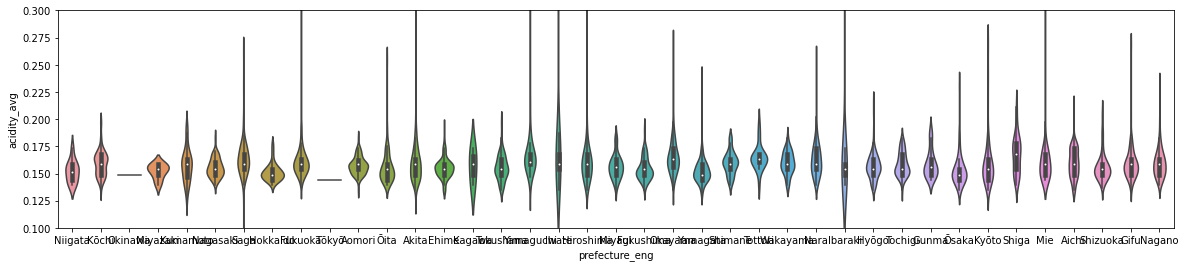

In [141]:
plt.figure(figsize=(20, 4))
sns.violinplot(df['prefecture_eng'], df['acidity_avg'])
plt.ylim([0.1, 0.3])

In [152]:
df.groupby('area').agg({
    'rice_type': 'count',
    'abv_avg': 'mean',
    'acidity_avg': 'mean',
    'gravity_avg': 'mean',
    'is_nama': ['mean', 'sum'],
    'is_genshu': ['mean', 'sum'],
    'is_kijoshu': ['mean', 'sum'],
    'is_futsu': ['mean', 'sum'],
    'is_special_designation': ['mean', 'sum'],
    'is_non_junmai': ['mean', 'sum'],
    'is_junmai': ['mean', 'sum'],
    'is_dai': ['mean', 'sum'],
    'is_nigori': ['mean', 'sum'],
    'is_koshu': ['mean', 'sum'],
    'is_muroka': ['mean', 'sum'],
    'is_sakabune': ['mean', 'sum'],
    'is_shiboritate': ['mean', 'sum'],
}).rename(columns={"rice_type":"num_sake"})#.sort_values(by='acidity_avg')

num_sake   abv_avg acidity_avg gravity_avg   is_nama         \
                count      mean        mean        mean      mean    sum   
area                                                                       
Central           780  0.380166    0.159526    0.808564  0.296154  231.0   
North             999  0.373054    0.157442    0.809112  0.183183  183.0   
West             1107  0.378423    0.161220    0.808248  0.239386  265.0   
West Central      949  0.378761    0.159186    0.812073  0.193888  184.0   

             is_genshu        is_kijoshu       is_futsu        \
                  mean    sum       mean  sum      mean   sum   
area                                                            
Central       0.256410  200.0   0.000000  0.0  0.079487  62.0   
North         0.142142  142.0   0.002002  2.0  0.050050  50.0   
West          0.186089  206.0   0.004517  5.0  0.075881  84.0   
West Central  0.149631  142.0   0.003161  3.0  0.089568  85.0   

             is_special_designation         is_non_junmai        is_junmai  \
                               mean     sum          mean    sum      mean   
area                                                                         
Central                    0.920513   718.0      0.301282  235.0  0.619231   
North                      0.947948   947.0      0.284284  284.0  0.663664   
West                       0.919603  1018.0      0.281843  312.0  0.637760   
West Central               0.907271   861.0      0.260274  247.0  0.646997   

                       is_dai        is_nigori        is_koshu        \
                sum      mean    sum      mean   sum      mean   sum   
area                                                                   
Central       483.0  0.335897  262.0  0.071795  56.0  0.020513  16.0   
North         663.0  0.311311  311.0  0.028028  28.0  0.019019  19.0   
West          706.0  0.241192  267.0  0.041554  46.0  0.031617  35.0   
West Central  614.0  0.301370  286.0  0.035827  34.0  0.028451  27.0   

             is_muroka        is_sakabune       is_shiboritate        
                  mean    sum        mean   sum           mean   sum  
area                                                                  
Central       0.133333  104.0    0.030769  24.0       0.060256  47.0  
North         0.037037   37.0    0.037037  37.0       0.040040  40.0  
West          0.111111  123.0    0.056007  62.0       0.037940  42.0  
West Central  0.064278   61.0    0.060063  57.0       0.055848  53.0

### check correlation

In [94]:
corr_matrix = df.corr()

<AxesSubplot:>

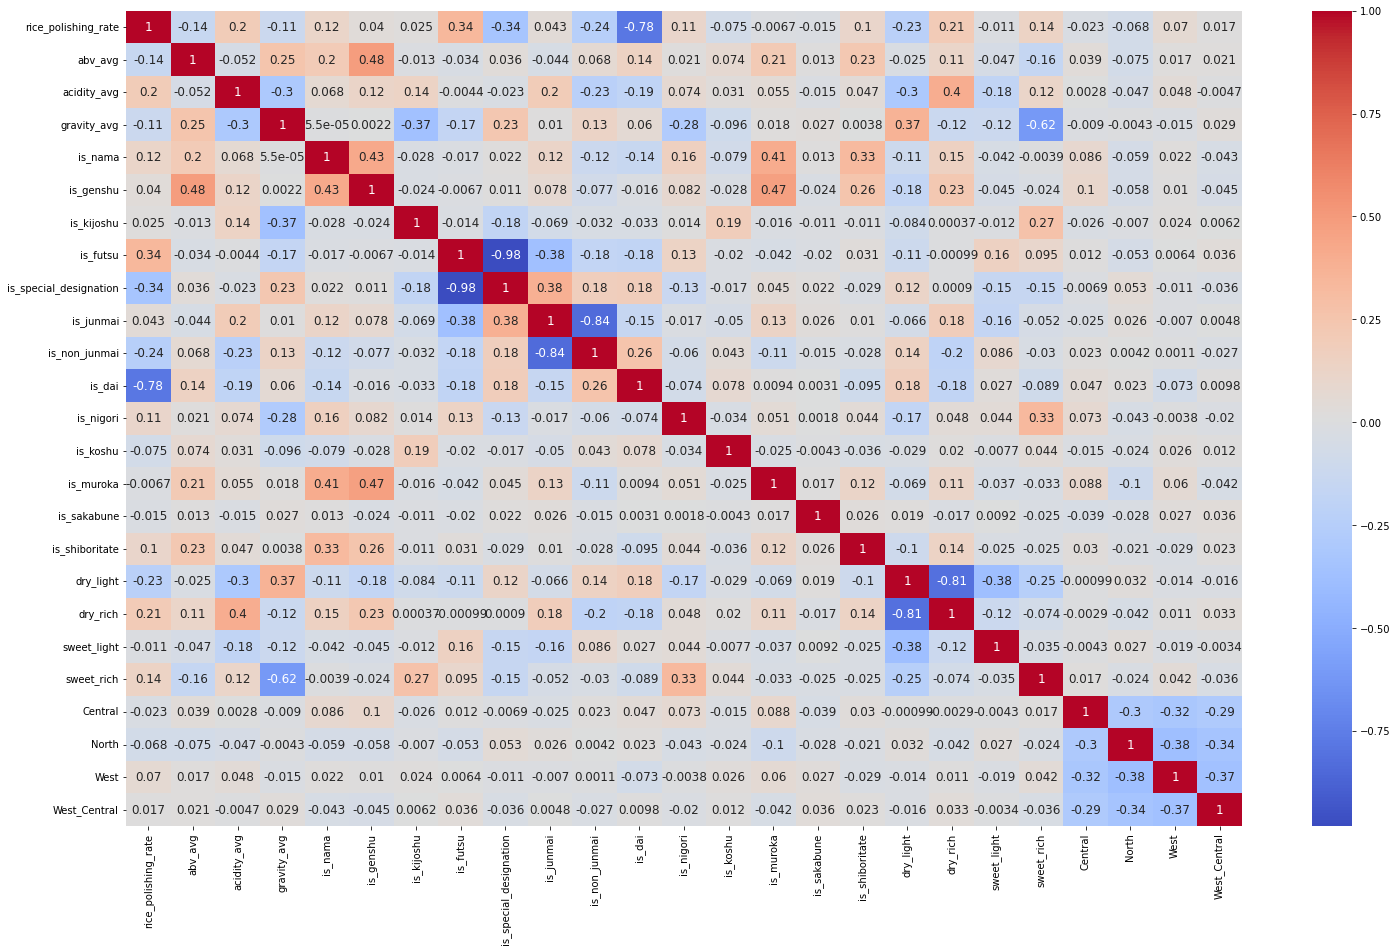

In [95]:
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot = True, annot_kws={"size": 12})

In [106]:
corr_df = corr_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df = corr_df.sort_values(by="absolute_correlation", ascending=False)

In [108]:
corr_df[corr_df['feature_1'] == 'North']

,feature_1,feature_2,correlation,absolute_correlation
573,North,West,-0.378078,0.378078
574,North,West_Central,-0.340341,0.340341
571,North,Central,-0.299896,0.299896
564,North,is_muroka,-0.101671,0.101671
551,North,abv_avg,-0.074643,0.074643
550,North,rice_polishing_rate,-0.068470,0.068470
554,North,is_nama,-0.059478,0.059478
555,North,is_genshu,-0.058374,0.058374
558,North,is_special_designation,0.053406,0.053406
557,North,is_futsu,-0.052892,0.052892


In [102]:
df = df[(df['acidity_avg'] < 0.8) & (df['gravity_avg'] > 0.2)]

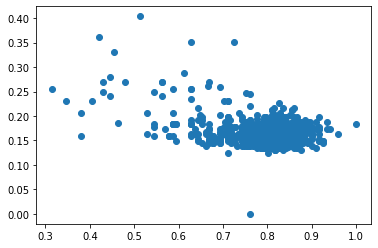

In [104]:
plt.scatter(df['gravity_avg'], df['acidity_avg'])

In [91]:
df['gravity_avg'].describe()

count    3835.000000
mean       -0.350813
std         2.081093
min       -33.000000
25%        -0.666667
50%         0.000000
75%         0.333333
max         7.333333
Name: gravity_avg, dtype: float64

## useful code

In [ ]:
# create a mapping dictionary between two columns - two versions

# version 1
dict_company_pref = pd.Series(df_sake['prefecture'].values,index=df_sake.company).to_dict()
dict_company_pref

In [ ]:
# version 2
pref_mapping = dict(df_pref[['Prefecture.1', 'Prefecture']].values)
pref_mapping